#  Project, Part01: predict California housing values, circa 1990

I first came upon the California housing dataset in Aurelien Geron's book, *Hands-On Machine Learning with Scikit-Learn & Tensorflow*.  See https://github.com/ageron/handson-ml/tree/master/datasets/housing.  Geron writes:

"This dataset appeared in a 1997 paper titled *Sparse Spatial Autoregressions* by Pace, R. Kelley and Ronald Barry, published in the Statistics and Probability Letters journal. They built it using the 1990 California census data. It contains one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people)."

The original data for this project can be found at https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html, a web page maintained by Luís Torgo (University of Porto).  Geron notes that "the dataset may also be downloaded from StatLib mirrors."  

Geron slightly modifies the dataset.  He randomly removes 207 values for the variable, total_bedrooms, in order to discuss in his book how to handle missing data.  Also, he adds the categorical variable, ocean_proximity, in order to show how to handle categorical data in a machine learning pipeline.  When modeling the data with a linear model, only 2 of the 5 levels for ocean_proximity significantly help to predict median house values for the 20K-plus districts in the dataset.  A special transformation of the longitude values in the dataset greatly diminishes the need for this variable.  For this project I make use of Geron's modified dataset.


                                        * * * * * 

Two objectives of this project are: (A) to explore how to best impute values for the capped, or censored, data.  (housing_median_age, a predictor, is capped at 52 years and median house values are capped at $500K; about 10\% of the 20,640 records are capped); and (B) to find a "best" model for predicting the median house values of the 20K districts.

Part01 of this project focuses on finding a "best" *linear* model.  Model performance is measured in terms of the root mean squared error (rmse). 


                                        * * * * * 



# Section 1: Preliminary housekeeping

In what follows, I address issues which I already know from previous work exist with the data.  In this section only main decision points with respect to data cleaning are shown.  I also show a couple of very important enhancements to the dataset.



In [ ]:
# Some packages we will need.

require(corrgram)
require(GGally)  # for scatterplot "tool"
require(repr)    # allows us to resize the plots
require(stringr)
require(ggplot2)
require(car)     # needed for diagnostic tools
require(arm)     # needed for Gibbs sampling used in imputation


In [2]:
options(digits = 5, show.signif.stars = F, 
        mc.cores=parallel::detectCores())


In [51]:
# Bring in the original dataset.  There are 9 predictors and
# one response variable, median_house_value.

dat <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/housing.csv", 
                header= TRUE, colClasses= c(rep("numeric", 9), "character"))
dim(dat)
# 20,640    10

colnames(dat)


[1] 20640    10

[1] "longitude"          "latitude"           "housing_median_age"
 [4] "total_rooms"        "total_bedrooms"     "population"        
 [7] "households"         "median_income"      "median_house_value"
[10] "ocean_proximity"

## Modify categorical variable, ocean_proximity

The ISLAND level of ocean_proximity has a very small number of records, too small to be of much help lowering the overall rmse of our model.  It might also interfere with the cross-validation scores used to identify the best parameters for our machine learning models.  For these reasons I combine the ISLAND records with the OCEAN group.

In [52]:
# Get counts for levels of ocean_proximity.

table(as.factor(dat$ocean_proximity))



 <1H OCEAN     INLAND     ISLAND   NEAR BAY NEAR OCEAN 
      9136       6551          5       2290       2658 

In [53]:
str(dat$ocean_proximity)


 chr [1:20640] "NEAR BAY" "NEAR BAY" "NEAR BAY" "NEAR BAY" "NEAR BAY" ...


In [54]:
# Change ocean_proximity to a factor.

dat$ocean_proximity <- as.factor(dat$ocean_proximity)
levels(dat$ocean_proximity) <- c("OCEAN", levels(dat$ocean_proximity)[2:5])


In [32]:
# Find out the degree to which the median house values differ
# in each of the ocean_proximity levels.

tmpdat <- dat
tmpdat$dummyvar <- 1
cat_counts <- aggregate(dummyvar ~ ocean_proximity, sum, data=tmpdat)
rm(tmpdat)
cat_medians <- aggregate(median_house_value ~ ocean_proximity, median, data=dat)
cat_means <- aggregate(median_house_value ~ ocean_proximity, mean, data=dat)
cat_stddevs <- aggregate(median_house_value ~ ocean_proximity, sd, data=dat)
df <- cbind(cat_counts, cat_medians$median_house_value, 
            cat_means$median_house_value, cat_stddevs$median_house_value)
colnames(df) <- c("ocean_proximity", "count", "group_median", "group_avg", "sd")
df$avg.se <- round(df$sd/sqrt(df$count))
df


ocean_proximity,count,group_median,group_avg,sd,avg.se
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
OCEAN,9136,214850,240084,106124,1110
INLAND,6551,108500,124805,70008,865
ISLAND,5,414700,380440,80560,36027
NEAR BAY,2290,233800,259212,122819,2567
NEAR OCEAN,2658,229450,249434,122477,2376


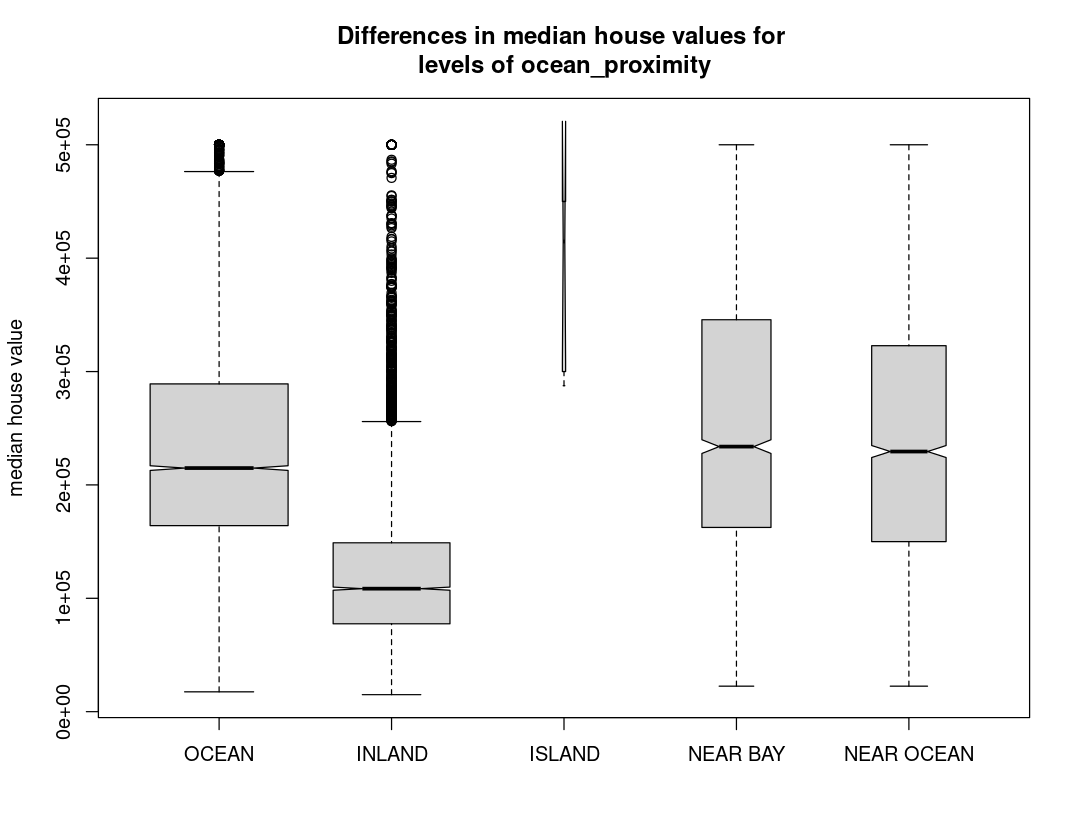

In [33]:
# A boxplot is also useful here.

options(repr.plot.width= 9, repr.plot.height= 7)

suppressWarnings(boxplot(median_house_value ~ ocean_proximity, data=dat, 
        main="Differences in median house values for 
levels of ocean_proximity", xlab="",
        ylab="median house value", notch=TRUE, varwidth=TRUE))


In [ ]:
### COMMENTS: 

# The most important difference lies between OCEAN and INLAND.
# About 75% of the records in our dataset belong to one or the 
# other of these 2 levels.  Notice that values tend to increase 
# as one moves closer to the ocean.

# The 5 ISLAND districts are quite different from the other groups
# in terms of average and median median house values, but 
# keeping this level in the analysis will do very little to improve
# our models' rmse scores.  The problem is the extremely low
# number of ISLAND districts.  When constructing models using
# cross-validation, we would like to have records from each of the
# groups in both the training and validation sets.  With only 5
# records in the group, there is no guarantee this will happen.

# For this reason, I combine the ISLAND records with the OCEAN
# group.


In [55]:
# Combine ISLAND and OCEAN categories.

dat[which(dat$ocean_proximity == "ISLAND"), c("ocean_proximity")] <- "OCEAN"

# Drop the unused level.
dat$ocean_proximity <- factor(dat$ocean_proximity)
table(dat$ocean_proximity)



     OCEAN     INLAND   NEAR BAY NEAR OCEAN 
      9141       6551       2290       2658 

## Fill in the missing values that Geron created

In [56]:
# The total_bedrooms variable has missing values.

summary(dat[, 1:9])


   longitude       latitude    housing_median_age  total_rooms   
 Min.   :-124   Min.   :32.5   Min.   : 1.0       Min.   :    2  
 1st Qu.:-122   1st Qu.:33.9   1st Qu.:18.0       1st Qu.: 1448  
 Median :-118   Median :34.3   Median :29.0       Median : 2127  
 Mean   :-120   Mean   :35.6   Mean   :28.6       Mean   : 2636  
 3rd Qu.:-118   3rd Qu.:37.7   3rd Qu.:37.0       3rd Qu.: 3148  
 Max.   :-114   Max.   :42.0   Max.   :52.0       Max.   :39320  
                                                                 
 total_bedrooms   population      households   median_income  
 Min.   :   1   Min.   :    3   Min.   :   1   Min.   : 0.50  
 1st Qu.: 296   1st Qu.:  787   1st Qu.: 280   1st Qu.: 2.56  
 Median : 435   Median : 1166   Median : 409   Median : 3.53  
 Mean   : 538   Mean   : 1425   Mean   : 500   Mean   : 3.87  
 3rd Qu.: 647   3rd Qu.: 1725   3rd Qu.: 605   3rd Qu.: 4.74  
 Max.   :6445   Max.   :35682   Max.   :6082   Max.   :15.00  
 NA's   :207                   

In [57]:
# Compute correlation betw. log(total_bedrooms) and
# log(median_house_value).  

tmpdat <- dat[, c("median_house_value", "total_bedrooms")]
tmpdat <- na.omit(tmpdat)
tmpdat$total_bedrooms <- log(tmpdat$total_bedrooms)
tmpdat$median_house_value <- log(tmpdat$median_house_value)
round(cor(tmpdat), 3)


,median_house_value,total_bedrooms
median_house_value,1.000,0.087
total_bedrooms,0.087,1.000


In [60]:
rows_to_exclude <- rownames(dat[which(!(rownames(dat) %in% rownames(tmpdat))),])
length(rows_to_exclude)


[1] 207

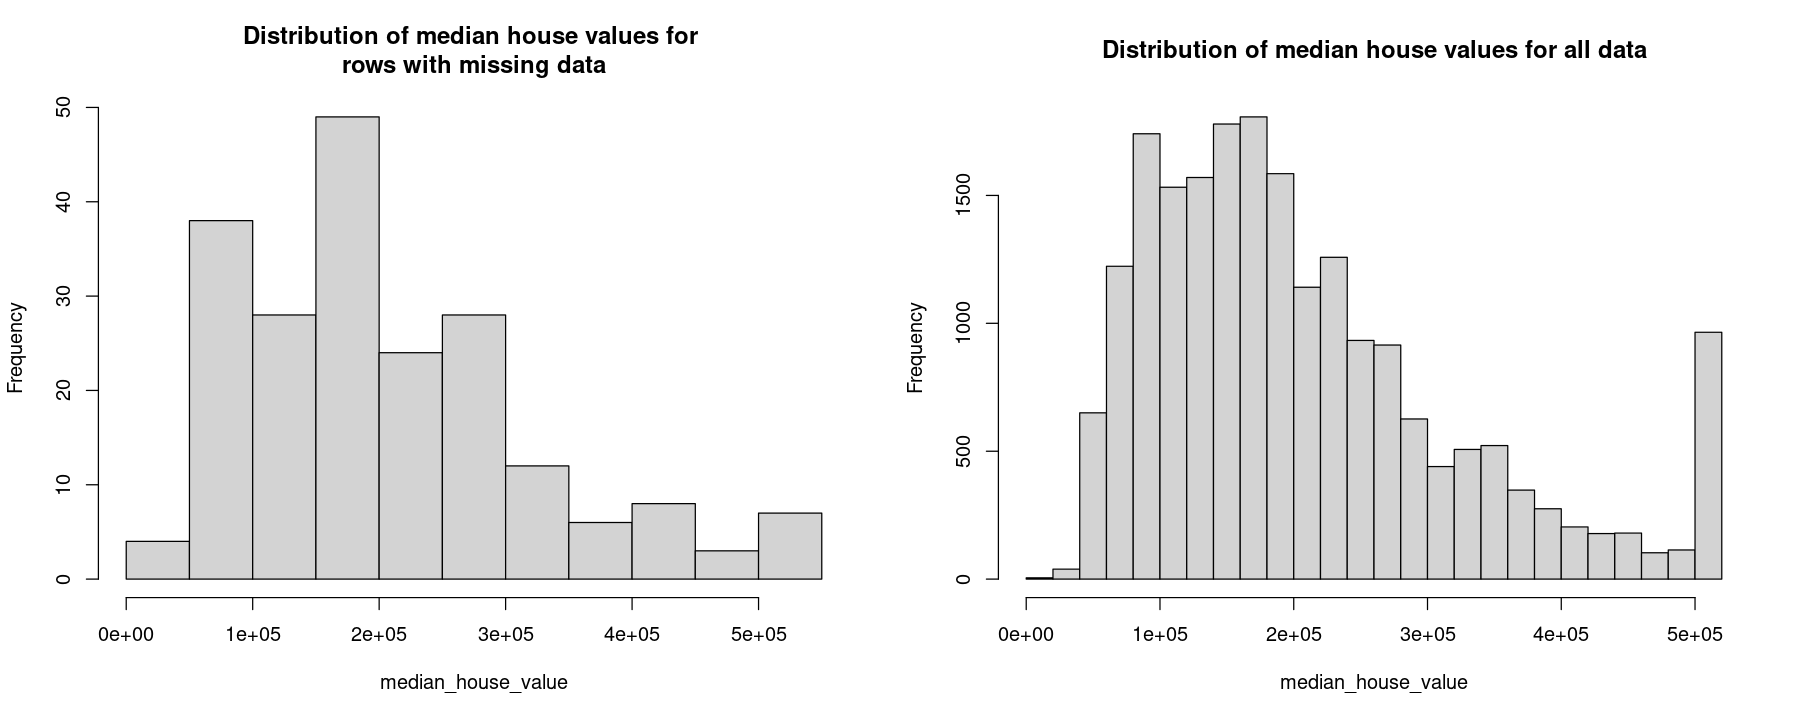

In [61]:
# total_bedrooms has 207 missing values.  Given the
# low linear correlation it has with median_house_value,
# it will not be an especially strong predictor in our
# model.  207 is also only 1% of the 20.6K records that
# we have to work with.  It follows from these two facts
# that we can assign the median value for total_bedrooms 
# to each of the records with a missing value without 
# making a mess of things.

options(repr.plot.width= 15, repr.plot.height= 6)

mat <- t(as.matrix(c(1,2)))
layout(mat, widths = rep.int(20, ncol(mat)),
       heights = rep.int(7, nrow(mat)), respect = FALSE)

hist(dat[rows_to_exclude,]$median_house_value, 
     main="Distribution of median house values for 
rows with missing data", breaks=10, xlab="median_house_value")

hist(dat$median_house_value, 
     main="Distribution of median house values for all data", 
     breaks=30, xlab="median_house_value")


In [62]:
dat[rows_to_exclude, c("total_bedrooms")] <- round(median(dat$total_bedrooms, na.rm=TRUE))
summary(dat$total_bedrooms)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1     297     435     537     643    6445 

In [63]:
# Copy dat.

dat.copy <- dat


## Add some variables that might help predict median house values

In [64]:
# As Geron points out in his book, it is worth investigating the 
# value certain combinations of the predictors might have for
# predicting the response variable.  Following Geron, then, let's
# add the variables rooms per household, population per
# household, and bedrooms per room.

dat$rooms_per_hh <- dat$total_rooms/dat$households
dat$bdrms_per_room <- dat$total_bedrooms/dat$total_rooms
dat$pop_per_hh <- dat$population/dat$households

summary(dat[, c("rooms_per_hh","bdrms_per_room","pop_per_hh")])


  rooms_per_hh     bdrms_per_room     pop_per_hh     
 Min.   :  0.846   Min.   :0.0372   Min.   :   0.69  
 1st Qu.:  4.441   1st Qu.:0.1752   1st Qu.:   2.43  
 Median :  5.229   Median :0.2032   Median :   2.82  
 Mean   :  5.429   Mean   :0.2138   Mean   :   3.07  
 3rd Qu.:  6.052   3rd Qu.:0.2401   3rd Qu.:   3.28  
 Max.   :141.909   Max.   :2.8247   Max.   :1243.33  

## Remove records with extreme values

A virtue of linear models is their simplicity.  This is achieved through parameterization of the relationships between the response variable and its predictors.  If done properly, little information is lost through this simplification process.  In fact, if done properly, a linear model can shed light on some of the most important relationships between the response variable and its predictors.  The best models are those which offer the clearest picture of these relationships.  Extreme values often detract from such clarity.

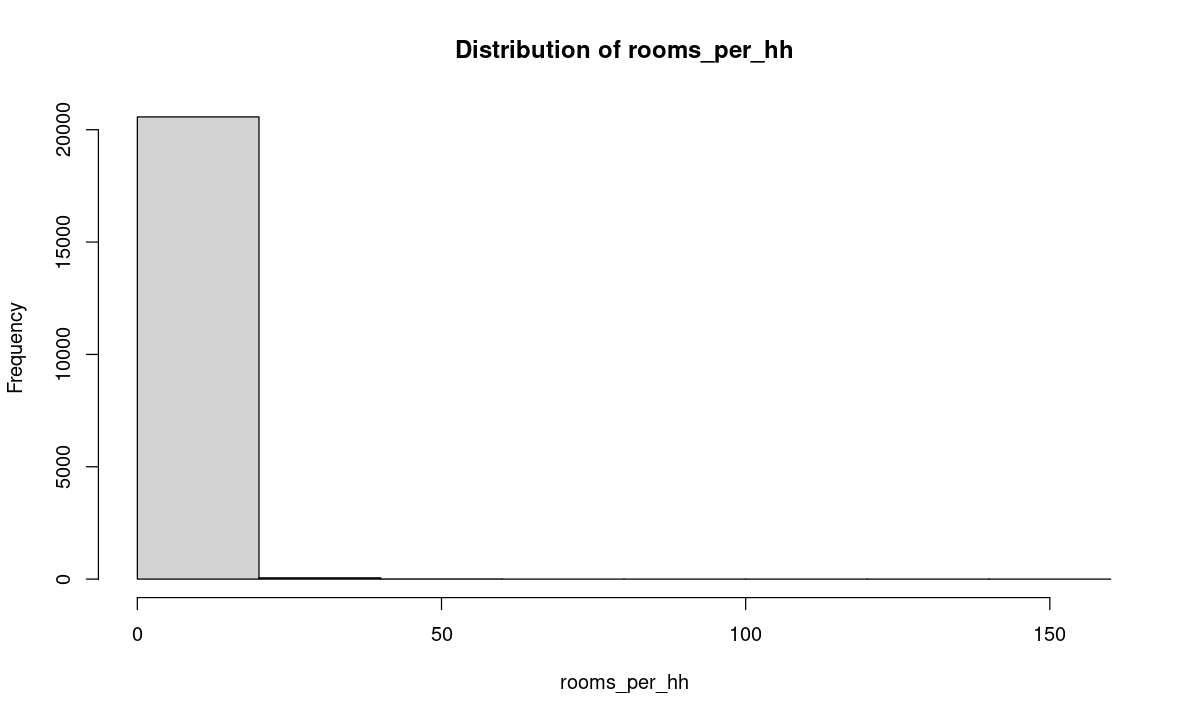

In [66]:
# We see in the above summary output that we have a district 
# in which rooms_per_hh is about 142.  And we have a district
# in which pop_per_hh is over 1,243.  Both these values might
# belong to the same district, perhaps one on an island which
# has many hotels on it.  We shouldn't expect our models to be
# able to handle this extreme data because we simply do not 
# have enough extreme data to work with to make good predictions.
# (If we did have enough such data, the data is arguably no 
# longer extreme.)

options(repr.plot.width= 10, repr.plot.height= 6)

hist(dat$rooms_per_hh, breaks=10, main="Distribution of rooms_per_hh",
     xlab="rooms_per_hh")


In [67]:
# Remove extreme values for rooms_per_hh.

dim(dat)
# 20,640
dat <- dat[which(dat$rooms_per_hh <= 40),]
dim(dat)
# 20,629

# 11 records removed.


[1] 20640    13

[1] 20629    13

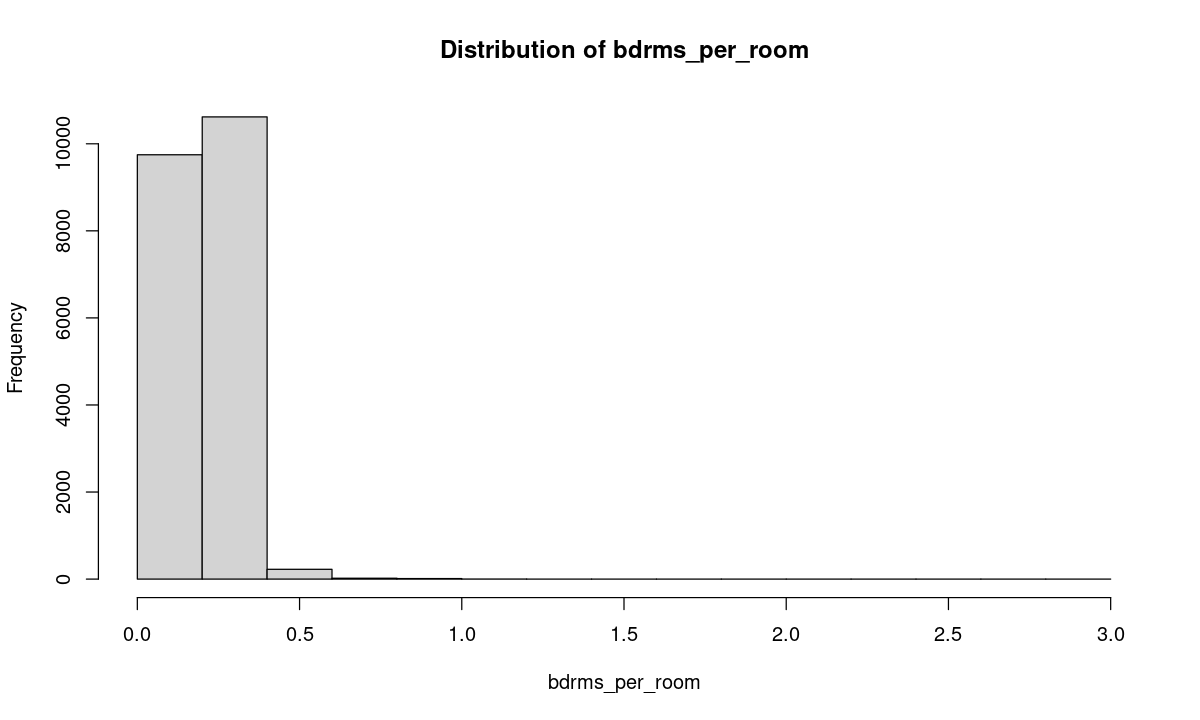

In [68]:
options(repr.plot.width= 10, repr.plot.height= 6)

hist(dat$bdrms_per_room, breaks=10, main="Distribution of bdrms_per_room",
     xlab="bdrms_per_room")


In [69]:
# Remove extreme values for bdrms_per_room.

dim(dat)
# 20,629
dat <- dat[which(dat$bdrms_per_room <= 0.95),]
dim(dat)
# 20,621

# 8 records removed.


[1] 20629    13

[1] 20621    13

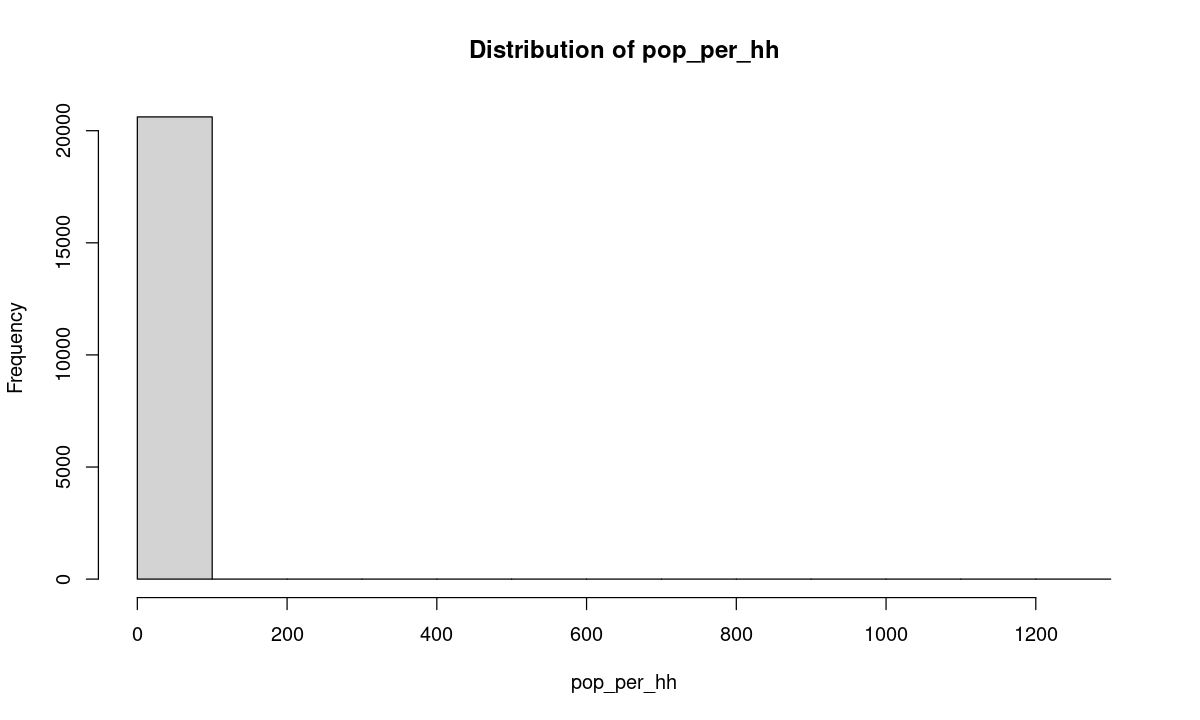

In [70]:
options(repr.plot.width= 10, repr.plot.height= 6)

hist(dat$pop_per_hh, breaks=10, main="Distribution of pop_per_hh",
     xlab="pop_per_hh")


In [71]:
# Remove extreme values for pop_per_hh.

dim(dat)
# 20,621
dat <- dat[which(dat$pop_per_hh <= 15),]
dim(dat)
# 20,603

# 18 records removed.


[1] 20621    13

[1] 20603    13

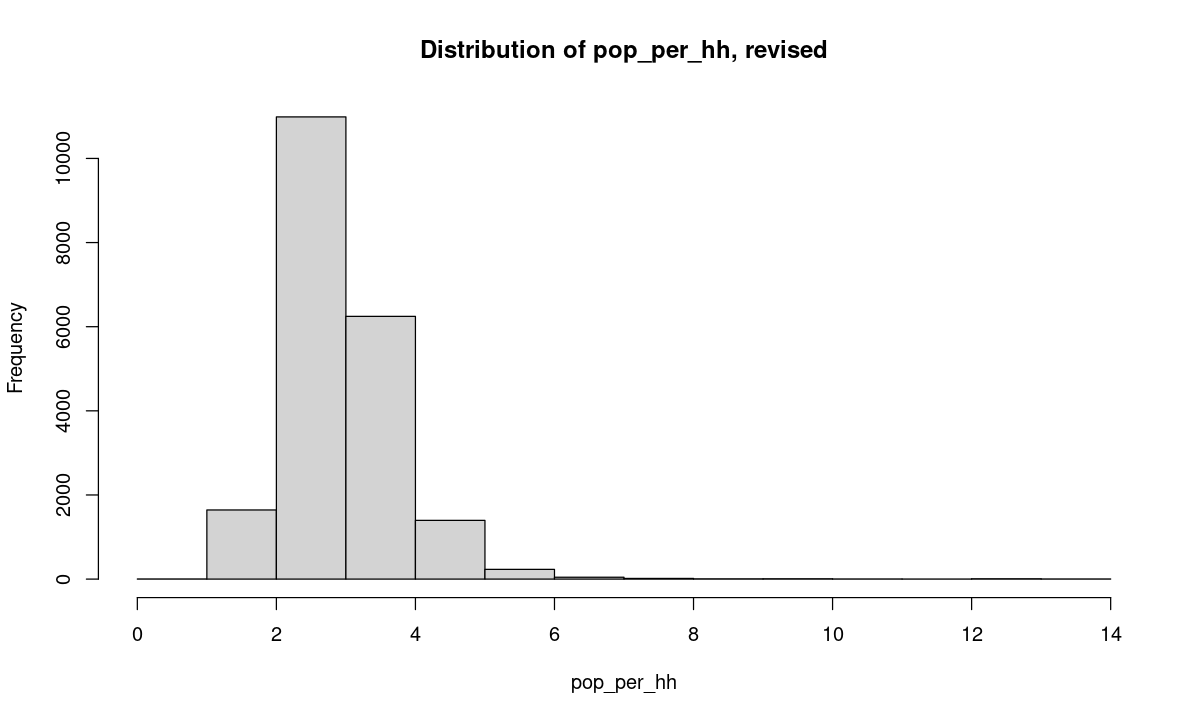

In [72]:
options(repr.plot.width= 10, repr.plot.height= 6)

hist(dat$pop_per_hh, breaks=10, main="Distribution of pop_per_hh, revised",
     xlab="pop_per_hh")


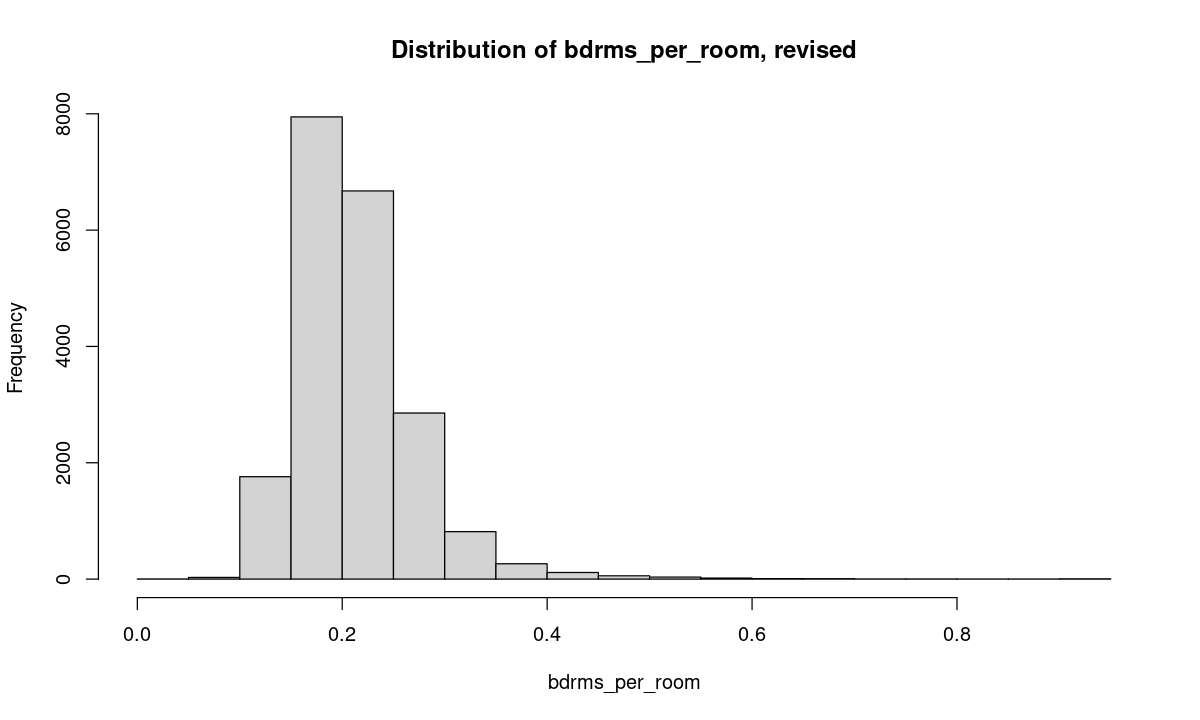

In [76]:
options(repr.plot.width= 10, repr.plot.height= 6)

hist(dat$bdrms_per_room, breaks=20, main="Distribution of bdrms_per_room, revised",
     xlab="bdrms_per_room")


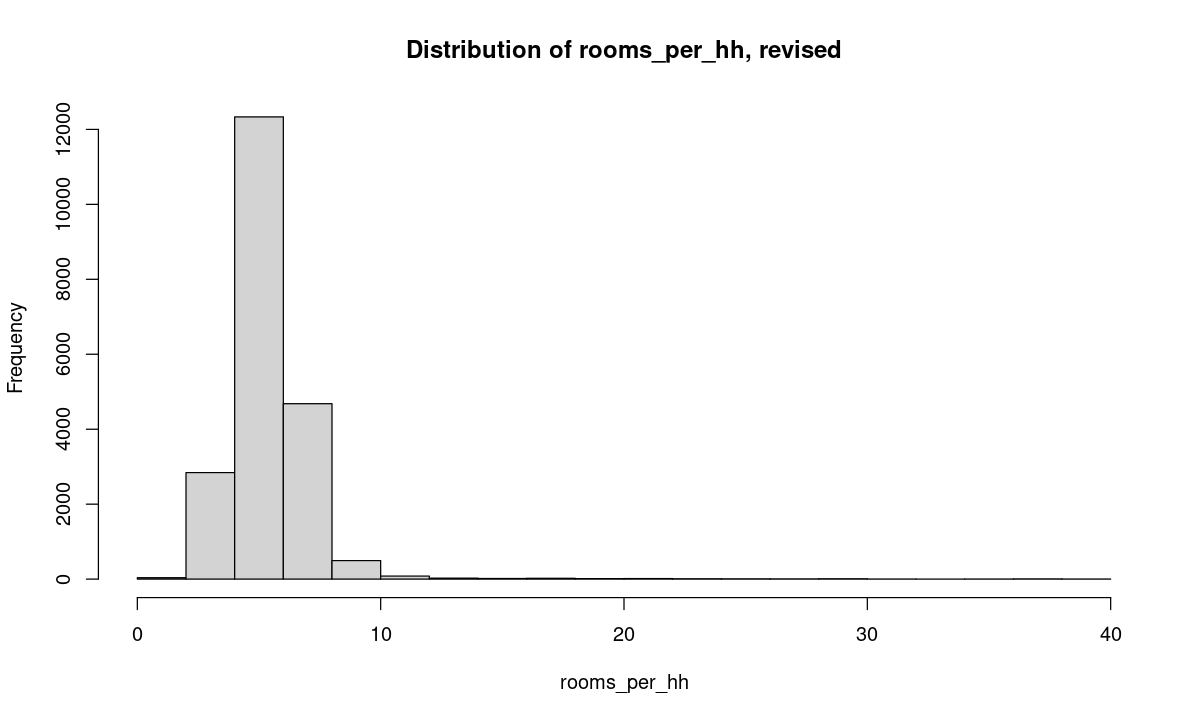

In [75]:
options(repr.plot.width= 10, repr.plot.height= 6)

hist(dat$rooms_per_hh, breaks=20, main="Distribution of rooms_per_hh, revised",
     xlab="rooms_per_hh")


### Write to disk

In [77]:
# We currently have 20,603 records.  37 records with
# extreme values have been removed from the dataset.

write.csv(dat, 
          file="/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v01.csv",
          row.names=TRUE)


In [78]:
colnames(dat)


[1] "longitude"          "latitude"           "housing_median_age"
 [4] "total_rooms"        "total_bedrooms"     "population"        
 [7] "households"         "median_income"      "median_house_value"
[10] "ocean_proximity"    "rooms_per_hh"       "bdrms_per_room"    
[13] "pop_per_hh"

## Attach HHdensity variable

We can increase the power of our models by adding an urbanacity metric---households per square mile---as another predictor.  I do this by bringing in Census data on household density in Census block groups.  Since I was not able to get Census tract data from the 1990 Census, I am using the 2000 Census instead.  Also, since I am not sure that the 2000 Census tracts align with those from the 1990 Census, I use the lat-long for each district in the California housing data to find the nearest year 2000 Census tract and then assign the household density of that tract to its matching district in the California housing data.  

Of course, it would have been preferable to have Census 1990 data since it is from this Census that the California housing dataset is constructed.  Some, or many, of the 1990 districts will have had an HHdensity value quite different from what I am assigning.  This means that my HHdensity predictor will not be as powerful as it could have been. 


In [17]:
# Bring in the semi-prepped data.

hhdat <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v01.csv",
                row.names=1,
                header=TRUE, colClasses= c("character", rep("numeric", 9), "character",
                                           rep("numeric", 3)))
dim(hhdat)
# 20,603   13


[1] 20603    13

In [18]:
head(hhdat)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_hh,bdrms_per_room,pop_per_hh
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
1,-122.23,37.88,41,880,129,322,126,8.3252,452600,NEAR BAY,6.9841,0.14659,2.5556
2,-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,6.2381,0.15580,2.1098
3,-122.24,37.85,52,1467,190,496,177,7.2574,352100,NEAR BAY,8.2881,0.12952,2.8023
4,-122.25,37.85,52,1274,235,558,219,5.6431,341300,NEAR BAY,5.8174,0.18446,2.5479
5,-122.25,37.85,52,1627,280,565,259,3.8462,342200,NEAR BAY,6.2819,0.17210,2.1815
6,-122.25,37.85,52,919,213,413,193,4.0368,269700,NEAR BAY,4.7617,0.23177,2.1399


In [ ]:
### COMMENT: 

# Unfortunately the CA housing data has highly rounded
# lat-longs; this might lead to some inaccuracies when  
# assigning an HHdensity to each rcd.


### Wrangle Census tract 2000 data

In [11]:
# Load raw data.

# The read.table does not work if we have sep = "\t" (even though the file
# is tab-delimited).
dat <- read.table(file= "/home/greg/datasets/CA_housing/Census2000/ustracts2k/ustracts2k.txt", 
                  sep= "",
                  colClasses = c("character", rep("numeric", 8)))
dim(dat)
# 66304    9


[1] 66304     9

In [12]:
colnames(dat) <- c("code", "population", "households", "landArea_meters", 
                   "waterArea_meters", "land_area_sqMiles", 
                   "water_area_sqMiles", "lat", "long")

newdat <- dat[, c("code", "households", "land_area_sqMiles", "lat", "long")]
newdat[c(1:3, 66302:66304),]
colnames(newdat) <- c("code", "hh_count", "LandArea", "lat", "long")

dat <- newdat
rm(newdat)
dat$state <- substr(dat$code, 1, 2)
head(dat)


,code,households,land_area_sqMiles,lat,long
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,AL01001020100,769,3.7750,32.471,-86.487
2,AL01001020200,731,1.2905,32.466,-86.473
3,AL01001020300,1263,2.0869,32.474,-86.458
66302,PR72153750503,873,1.2791,18.027,-66.873
66303,PR72153750601,1785,4.2410,18.019,-66.840
66304,PR72153750602,1273,6.7715,17.996,-66.852


,code,hh_count,LandArea,lat,long,state
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,AL01001020100,769,3.7750,32.471,-86.487,AL
2,AL01001020200,731,1.2905,32.466,-86.473,AL
3,AL01001020300,1263,2.0869,32.474,-86.458,AL
4,AL01001020400,1871,2.4657,32.467,-86.446,AL
5,AL01001020500,2277,4.4570,32.455,-86.425,AL
6,AL01001020600,1352,3.2463,32.440,-86.478,AL


In [13]:
# More data cleaning.

dat <- dat[which(dat$state == 'CA'),]

# The LandArea for a census tract is from the 
# land_area_sqMiles field.  I did not add in the water
# area that the census tracts include because I want my 
# urbanacity metric to be land-focused only.
dat <- dat[which(dat$LandArea != 0),]
dim(dat)
# 7049   6


[1] 7049    6

In [14]:
# Construct the urbanacity metric.

dens <- round(dat$hh_count/dat$LandArea, 4)
summary(dens)
#    Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
#       0     815    2103    2876    3453   66174 

HHdens_ln <- log(dens + 1)
summary(HHdens_ln)
#   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
#   0.00    6.70    7.65    7.12    8.15   11.10 


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0     815    2103    2876    3453   66174 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    6.70    7.65    7.12    8.15   11.10 

In [15]:
dat$HHdens_ln <- HHdens_ln

write.csv(dat, 
          file="/home/greg/datasets/CA_housing/Census2000/ustracts2k/ustracts2k_wrangled_CA_only.csv.csv", 
          row.names= FALSE)


### Attach HHdensity values to the CA housing dataset

In [19]:
# For the state of California, the following distance
# function should work fairly well.  Distance is in
# miles.  (Different distance functions have different
# degrees of accuracy depending on the location of
# the points on the earth's surface---e.g., location 
# from the equator.)

get_distance <- function(hh_lat, hh_long, blk_lat, blk_long) {
  
  # blk_lat and blk_long are the lat-long for the Census tracts
  a <- hh_lat/57.2957795130824
  b <- hh_long/57.2957795130824
  c <- blk_lat/57.2957795130824
  d <- blk_long/57.2957795130824
  
  x <- ((sin(a)*sin(c))+(cos(a)*cos(c)*cos(b-d)))
  distance <- round(3959 * (2 * atan(1) - asin(x)), 2)
  
  return(distance)
}


In [20]:
# Order the census tract data by longitude, then latitude; this 
# should allow for quicker lookup into this reference dataframe.
dat <- dat[order(dat$long, dat$lat),]

# All of the codes in dat are unique; this allows us to uniquely 
# identify each row in dat, and thus uniquely tag each lat-long 
# combination.
length(dat$code)
# [1] 7049
length(unique(dat$code))
# [1] 7049


[1] 7049

[1] 7049

In [21]:
# Attach HHdens_ln values to the appropriate district
# in hhdat.

hhlats <- hhdat$latitude
hhlongs <- hhdat$longitude
hhdat$HHdens_ln = NA

offsets <- c(0.02, 0.04, 0.08, 0.12, 0.2, 0.3, 0.5, 1)

start <- Sys.time()
for(i in 1:dim(hhdat)[1]) {
  
  curlat <- hhlats[i]
  curlong <- hhlongs[i]
  
  flag <- TRUE
  indx <- 1
  while((flag == TRUE) & (indx <= length(offsets))) {
    
    cur_offset <- offsets[indx]
    indx <- indx + 1
    candidates <- dat[which((dat$long > curlong - cur_offset & dat$long < curlong + cur_offset) &
                              (dat$lat > curlat - cur_offset & dat$lat < curlat + cur_offset)),
                      c("code", "lat", "long")]
    if(nrow(candidates) > 0) {
      flag <- FALSE
    }
  }
  
  if(nrow(candidates) > 0) {
    
    ans <- mapply(get_distance, candidates$lat, candidates$long, curlat, curlong)
    names(ans) <- candidates$code
    
    # Assign the HHdensity of the district that is closest to
    # the CA housing record.
    val <- names(ans[as.numeric(ans) == min(as.numeric(ans))])[1]
    hhdat$HHdens_ln[i] <- as.numeric(dat[which(dat$code == val),]$HHdens_ln)
  }
}
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 6.62 secs


Time difference of 6.62 secs

In [22]:
# Make sure there are no missing values.

summary(dat$HHdens_ln)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    6.70    7.65    7.12    8.15   11.10 

### Save out enhanced CA housing dataset

In [25]:
rm(dat)

write.csv(hhdat,
          file="/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v02.csv",
          row.names=TRUE)


In [24]:
colnames(hhdat)


[1] "longitude"          "latitude"           "housing_median_age"
 [4] "total_rooms"        "total_bedrooms"     "population"        
 [7] "households"         "median_income"      "median_house_value"
[10] "ocean_proximity"    "rooms_per_hh"       "bdrms_per_room"    
[13] "pop_per_hh"         "HHdens_ln"

In [27]:
dat <- hhdat; rm(hhdat)


In [28]:
# Get correlations betw. our current set of variables
# and log(median_house_value).

cols <- colnames(dat)[which(!(colnames(dat) %in% c("ocean_proximity")))]

tmpdat <- dat[, cols]
tmpdat$median_house_value <- log(tmpdat$median_house_value)
tmpdat$population <- log(tmpdat$population)
tmpdat$total_bedrooms <- log(tmpdat$total_bedrooms)
tmpdat$total_rooms <- log(tmpdat$total_rooms)

ans <- as.data.frame(cor(tmpdat[, ])[, "median_house_value"])
colnames(ans) <- c("median_house_value")
round(ans[order(ans$median_house_value, decreasing = TRUE), , 
          drop = FALSE], 3)
                     

,median_house_value
,<dbl>
median_house_value,1.000
median_income,0.659
HHdens_ln,0.276
total_rooms,0.186
rooms_per_hh,0.172
households,0.098
total_bedrooms,0.086
housing_median_age,0.075
population,0.026


In [ ]:
### COMMENTS:

# Notice that after median_income, HHdens_ln is the 
# variable most highly correlated with median_house_value.

# Notice the weak linear correlation between longitude
# and median_house_value.  Something is amiss here because
# we already know from the ocean_proximity summaries above
# that districts' median house values increase as we move
# west from INLAND to OCEAN districts.  We would expect 
# longitude's correlation with median_house_value to be
# even stronger than that of latitude's.


## Transform longitude so that it has stronger correlation with median_house_value

The linear correlation between longitude and log(median_house_value) is -2.3%.  But for latitude this same correlation is -19.3%, more than an eight-fold increase.  Yet the ranges for the two variables are equal: latitude's range is just shy of 10 degrees, whereas longitude's is exactly 10 degrees.  Why such a large difference in the correlation, then?  Shouldn't the correlation between longitude and median house value also be at least -19%?  In fact, we would expect it to be stronger than -19% because the data shows very clearly that as we move toward the ocean, median house prices tend to increase.  The trend isn't nearly so strong as we move from north to south.  (Although north of the 39th parallel, median home values drop significantly, only around 5% of the records in the dataset are north of the 39th parallel.)

Is there a transformation we can apply to longitude so that it has at least as strong a linear correlation with the response as latitude?  It turns out that there is.


                                        * * * * *


A look at the shape of the state of California shows us why longitude under-performs in this state.  California basically has parallel east-west borders (in the sense that the distance between these two borders remains about the same as we move from north to south) and, roughly-speaking, parallel north-south borders.  But south of the 39th parallel, the state veers to the right.  In Lake Tahoe there is a point of rotation: exactly 39 degrees north and 120 degrees west.  Below the 39th parallel, the oceanside border of California is roughly parallel to the inland border with Nevada.  Thus, if California can be straightened into a rectangle using the point of rotation just mentioned, each longitudinal should carry the same information throughout the state, namely the distance from the ocean, when trying to predict median house values.

When longitude is transformed to change the shape of California in this way, its linear correlation with median_house_value increases 23X, making longitude second only to median_income in this measure.  With longitude newly transformed, one can model the dataset with latitude, longitude, median income, housing median age, and 4 other variables for a 70% R-sqrd AND do so without bringing ocean_proximity into the model.  This new transformation for longitude thus adds to our options for model selection because we can still have a strong model without relying on the categories of ocean_proximity; all or our model terms can then be numeric.


In [29]:
# Code for transforming longitude into a much stronger predictor.

#################################################

# Apply transformation to all longitudes tied to any latitude < 39.00.

# The formula is as follows: 

# origin at Lake Tahoe: (39.00, -120.00)
# origin oceanside: (39.00, -123.684)

# delta.lat = 39.00 - lat
# slope = 1.086706
# delta.long = slope * delta.lat = 1.086706 * (39 - lat)
# new.long = original.long - delta.long = long - [1.086706 * (39 - lat)]

#################################################


origLats <- dat$latitude
origLongs <- dat$longitude

summary(origLongs)
# Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
# -124    -122    -118    -120    -118    -114 

# Transform longitude:
for(i in 1:length(origLats)) {
  if(origLats[i] < 39) {
    origLongs[i] <- origLongs[i] - (1.086706 * (39 - origLats[i]))
  } 
}

summary(origLongs)
# Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
# -125    -124    -124    -123    -123    -119


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   -124    -122    -118    -120    -118    -114 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   -125    -124    -124    -123    -123    -119 

In [30]:
# Create a new column for the transformed longitude data.

dat$long_transf <- origLongs

# make the predictor positive
dat$long_transf <- dat$long_transf + 127

rm(origLats, origLongs)


In [31]:
# Get new set of correlations.

cols <- colnames(dat)[which(!(colnames(dat) %in% c("ocean_proximity","longitude")))]

tmpdat <- dat[, cols]
tmpdat$median_house_value <- log(tmpdat$median_house_value)
tmpdat$population <- log(tmpdat$population)
tmpdat$total_bedrooms <- log(tmpdat$total_bedrooms)
tmpdat$total_rooms <- log(tmpdat$total_rooms)

ans <- as.data.frame(cor(tmpdat[, ])[, "median_house_value"])
colnames(ans) <- c("median_house_value")
round(ans[order(ans$median_house_value, decreasing = TRUE), , 
          drop = FALSE], 3)


,median_house_value
,<dbl>
median_house_value,1.000
median_income,0.659
HHdens_ln,0.276
total_rooms,0.186
rooms_per_hh,0.172
households,0.098
total_bedrooms,0.086
housing_median_age,0.075
population,0.026


In [ ]:
### COMMENT: 

# The transformation increases the linear correlation with
# log(median_house_value) 23X, from -2.3% to -53%.

# For linear modeling, this is a big deal.  It essentially 
# obviates the need for the ocean_proximity categorical 
# predictor.


### Write to disk

In [32]:
# Here I overwrite housing_cleaned_v02.csv.

write.csv(dat,
          file="/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v02.csv",
          row.names=TRUE)
dim(dat)


[1] 20603    15

In [33]:
colnames(dat)


[1] "longitude"          "latitude"           "housing_median_age"
 [4] "total_rooms"        "total_bedrooms"     "population"        
 [7] "households"         "median_income"      "median_house_value"
[10] "ocean_proximity"    "rooms_per_hh"       "bdrms_per_room"    
[13] "pop_per_hh"         "HHdens_ln"          "long_transf"

# Section 2: Impute values for censored data

housing_median_age is capped at 52 years, and median_house_value is capped at \$500K.  Around 10\% of the records have censored data.  When modeling, we are not doing ourselves any favors by throwing out this amount of data; nor are we doing ourselves any favors by keeping the records with the censored data, but at the capped values.  The  best approach is to impute values, assuming we have a good method for doing so.  This is especially true for median_house_value, since it is our response variable and we want our models to accurately predict median house values.  (housing_median_age also has less importance because age is only a very weak predictor of median_house_value.)  The censored values, if not properly treated, add noise to the data, making it more difficult to obtain accurate predictions.  Ideally, we want our models to accurately predict median_house_value even when a district has a median house value >= 500K since such districts actually exist in our dataset.

Andrew Gelman and Jennifer Hill offer several closely related approaches for addressing censored data in Section 18.5 of their book, *Data Analysis Using Regression and Multilevel/Heirarchical Models*.  I follow their method of using a Gibbs sampler.  The process for imputing values for housing_median_age is worked out in Appendix A.  The process for imputing values for median_house_value is found in Appendix B.  This section tackles some of the preliminaries and stitches together the results from the two appendices.

I first impute values for the records with a censored housing_median_age since I use this variable as a predictor when modeling the response variable, median_house_value.  The first step is to find a model for predicting housing_median_age.  Some of the steps in model selection are shown below.  Once we have imputed values for housing_median_age, we can follow a similar process for imputing values for the censored median_house_values.



                                        * * * * *
                                        

I am imputing values prior to constructing training and test sets because I do not want to impute values when applying cross-validation methods.  Not only would that be messy, I am not sure it even makes sense since there are no true (i.e., observed) values (above 52 years of age; above \$500K) to work with for getting rmse scores.  

For the purpose of finding a "best" predictive model for median_house_value given the predictors we have, it is best to impute values for the censored data because (i) if we keep the capped values as is, we will get a false sense of what our models can actually do; the models perform much worse with the capped values, and this will be especially true for a linear model; yet, (ii) if we remove the records with censored values, we also get a false sense of model performance for ALL Census districts in California.  

Including imputed values in our data, however, means that for the purposes of getting rmse scores for model comparison, *we need to treat the imputed values as we do the non-censored data, i.e., as if they are true, or observed*.  When comparing model scores, this presents no issue.  It is only when we look at a score by itself that we have to be cautious; e.g., if a model rmse score is 75K we have to keep in mind that around 20K of this error is due to including predictions for the range of imputation.  Although only 4.8\% of the median house value data has been imputed, the imputed values are in a range for which we have the least amount of information and for which the median values are greatest.  Error scores are thus greatly inflated when we work with all of the data at once.  This means, among other things, that if we want a prediction for a district which we *know* will have a median house value below, say, 150K, and we need an error estimate for the prediction, we should estimate the error using test data which only includes districts with a median house value <= 150K.  (For this example we should expect an rmse score much closer to 35K than to 75K.)



                                       * * * * *



In [19]:
dat <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v02.csv",
                header=TRUE, row.names=1,
                colClasses= c("character", rep("numeric", 9), "character",
                              rep("numeric", 5)))
dim(dat)


[1] 20603    15

In [7]:
# Get percent of records with censored data.

tmpdat <- dat[which((dat$median_house_value >= 500000) | (dat$housing_median_age >= 52)),]
ans <- 100*round(nrow(tmpdat)/nrow(dat), 3)
paste0("Percent of data that has a cap: ", as.character(ans))
# 'Percent of data that has a cap: 10.1'

# Thus, around 2,081 records have censored data.


[1] "Percent of data that has a cap: 10.1"

In [8]:
# Get percent of records with censored data for median_house_value.

tmpdat <- dat[which(dat$median_house_value >= 500000),]
ans <- 100*round(nrow(tmpdat)/nrow(dat), 3)
paste0("Percent of median_house_value rcds that are censored: ", as.character(ans))
# 'Percent of median_house_value rcds that are censored: 4.8'

# Thus, around 987 records have median_house_value censored at 500K.


[1] "Percent of median_house_value rcds that are censored: 4.8"

In [ ]:
### NOTE:

# Around 60 records, or 0.3% of the districts appear to
# be censored at either $350K or $450K.  I am not going
# to worry about imputing values for these districts.


In [11]:
# Get percent of records with censored data for housing_median_age.

tmpdat <- dat[which(dat$housing_median_age >= 52),]
ans <- 100*round(nrow(tmpdat)/nrow(dat), 3)
paste0("Percent of rcds that have censored housing_median_age: ", as.character(ans))
# 'Percent of rcds that have censored housing_median_age: 6.2'


[1] "Percent of rcds that have censored housing_median_age: 6.2"

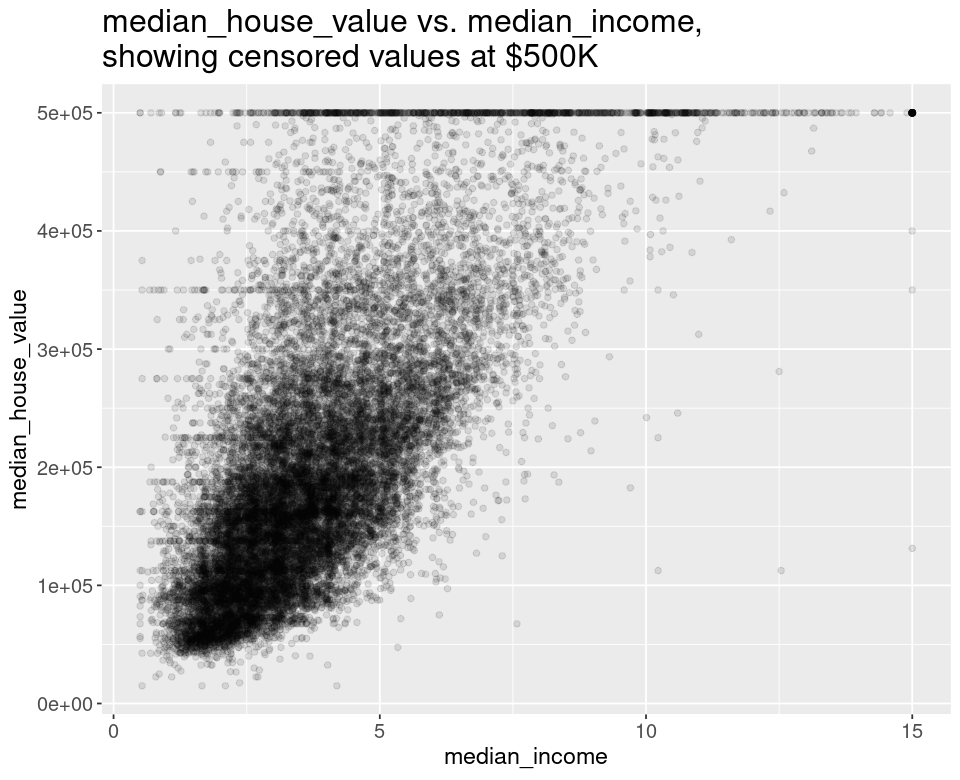

In [10]:
# Plot of median_house_value vs. median_income (the most
# important predictor).  4.8% of the data is censored at
# $500K.

options(repr.plot.width= 8, repr.plot.height= 6.5)

p <- ggplot(dat, aes(median_income, median_house_value)) +
  geom_point(alpha= 0.1) + xlab("median_income") + ylab("median_house_value") +
  ggtitle("median_house_value vs. median_income, 
showing censored values at $500K") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
  
p


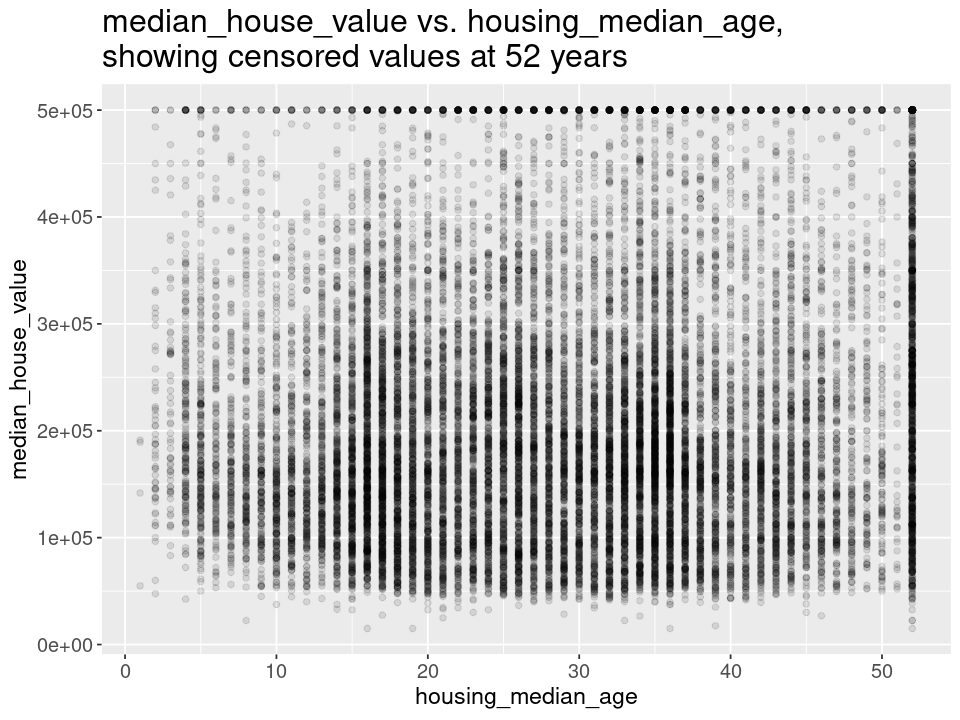

In [12]:
# Plot of median_house_value vs. housing_median_age. 
# 6.15% of the data is censored at age 52.

options(repr.plot.width= 8, repr.plot.height= 6)

p <- ggplot(dat, aes(housing_median_age, median_house_value)) +
  geom_point(alpha= 0.1) + xlab("housing_median_age") + ylab("median_house_value") +
  ggtitle("median_house_value vs. housing_median_age, 
showing censored values at 52 years") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
  
p


## Construct a model for imputing housing_median_age

In [50]:
colnames(dat)
summary(dat$housing_median_age)


[1] "longitude"          "latitude"           "housing_median_age"
 [4] "total_rooms"        "total_bedrooms"     "population"        
 [7] "households"         "median_income"      "median_house_value"
[10] "ocean_proximity"    "rooms_per_hh"       "bdrms_per_room"    
[13] "pop_per_hh"         "HHdens_ln"          "long_transf"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0    18.0    29.0    28.6    37.0    52.0 

In [4]:
# Initial model for age imputation.  Note that median_house_value
# is a predictor in this model; it has censored data.

# Weighted Least Squares (WLS) works well.  The weights help
# us avoid non-constant variance.

a01 <- lm(housing_median_age ~ long_transf + latitude +
            I(latitude^2) +
            I(latitude^3) + 
            I(latitude^4) +
            I(log(total_rooms)) +
            I(log(total_bedrooms)) + 
            I(population^0.05) +
            I(households^0.25) +
            I(households^0.5) +
            households +
            I(sqrt(median_income)) +
            I(sqrt(median_house_value)) +
            median_house_value +
            ocean_proximity + 
            HHdens_ln +
            I(HHdens_ln^2) + 
            bdrms_per_room + 
            I(bdrms_per_room^2) +
            I(sqrt(pop_per_hh)) +
            rooms_per_hh +
            latitude:long_transf +
            ocean_proximity:latitude +
            ocean_proximity:latitude:long_transf,
          data= dat, weights= dat$households^0.39)
ans <- summary(a01); 
ans[[1]] <- ""; round(ans$adj.r.squared, 3)
# Adj. R-sqrd of 43.5%


[1] 0.433

In [5]:
# Check for constant variance.

ncvTest(a01)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.0013839, Df = 1, p = 0.97

In [6]:
# Check for curvature, namely linearity with respect to
# the fitted values (since obtaining linearity with respect
# to each of the terms is too difficult).

# The Tukey test passes.  This means a01 has linearity
# with respect to the fitted values.

residualPlots(a01, plot= FALSE)


                            Test stat Pr(>|Test stat|)
long_transf                     -2.90          0.00370
latitude                        -3.58          0.00035
I(latitude^2)                   -3.27          0.00109
I(latitude^3)                   -3.23          0.00124
I(latitude^4)                   -3.28          0.00104
I(log(total_rooms))              3.93          8.5e-05
I(log(total_bedrooms))           1.75          0.08078
I(population^0.05)              -1.40          0.16012
I(households^0.25)              -4.87          1.1e-06
I(households^0.5)                6.16          7.6e-10
households                      -7.50          6.9e-14
I(sqrt(median_income))           5.46          4.9e-08
I(sqrt(median_house_value))     -2.28          0.02252
median_house_value              -3.15          0.00162
HHdens_ln                        3.52          0.00044
I(HHdens_ln^2)                   0.67          0.50597
bdrms_per_room                  -5.48          4.2e-08
I(bdrms_pe

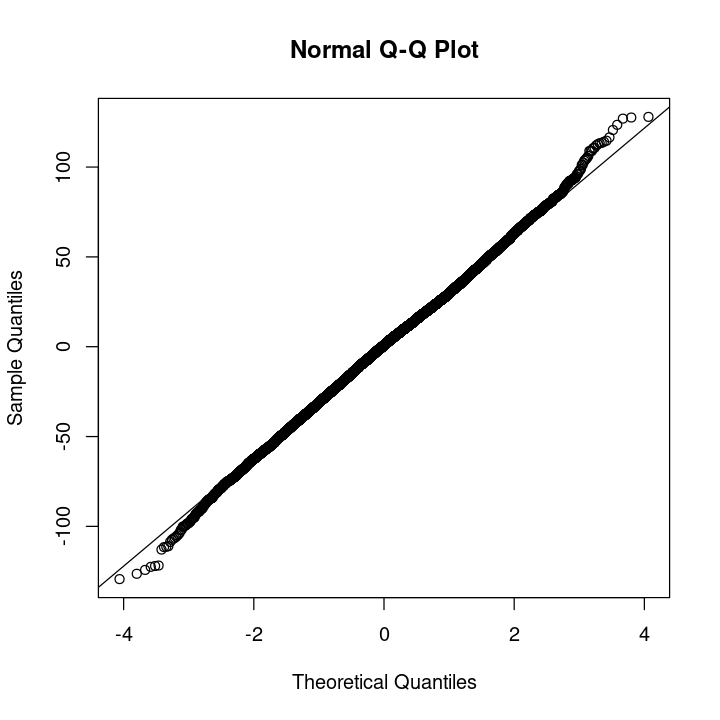

In [66]:
# Because of the weights, we need to use pearson residuals.

options(repr.plot.width= 6, repr.plot.height= 6)

qqnorm(residuals(a01, type= "pearson"))
qqline(residuals(a01, type= "pearson"))


In [7]:
# With 31 coefficients in the model, the Gibbs sampler
# has a lot of work to do.  

dim(ans$coefficients)[1]
# 31


[1] 31

In [8]:
# We can greatly reduce the number of coefficients if we
# model without using ocean_proximity.  (The adjusted
# R-sqrd drops by 3.2%.)

a02 <- lm(housing_median_age ~ long_transf + latitude +
            I(latitude^2) +
            I(latitude^3) + 
            I(latitude^4) +
            I(log(total_rooms)) +
            I(log(total_bedrooms)) + 
            I(population^0.25) +
            I(households^0.4) +
            I(sqrt(median_income)) +
            I(sqrt(median_house_value)) +
            median_house_value +
            HHdens_ln +
            I(HHdens_ln^2) + 
            bdrms_per_room + 
            I(bdrms_per_room^2),
          data= dat, weights= dat$households^0.52)
a02.summary <- summary(a02); 
a02.summary[[1]] <- ""; a02.summary



Call:
""

Weighted Residuals:
    Min      1Q  Median      3Q     Max 
-183.49  -33.07    1.03   31.44  212.95 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)
(Intercept)                 -7.33e+04   5.59e+03  -13.12  < 2e-16
long_transf                 -2.89e+00   1.36e-01  -21.35  < 2e-16
latitude                     8.01e+03   6.15e+02   13.03  < 2e-16
I(latitude^2)               -3.27e+02   2.53e+01  -12.90  < 2e-16
I(latitude^3)                5.92e+00   4.63e-01   12.78  < 2e-16
I(latitude^4)               -4.01e-02   3.17e-03  -12.67  < 2e-16
I(log(total_rooms))         -4.20e+01   2.78e+00  -15.11  < 2e-16
I(log(total_bedrooms))       3.90e+01   2.71e+00   14.39  < 2e-16
I(population^0.25)           1.04e+00   1.96e-01    5.32  1.1e-07
I(households^0.4)           -1.17e+00   8.53e-02  -13.73  < 2e-16
I(sqrt(median_income))      -1.02e+01   3.30e-01  -30.78  < 2e-16
I(sqrt(median_house_value)) -7.92e-02   4.31e-03  -18.39  < 2e-16
median_house_v

In [9]:
ncvTest(a02)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.0404, Df = 1, p = 0.841

In [10]:
residualPlots(a02, plot= FALSE)


                            Test stat Pr(>|Test stat|)
long_transf                     -4.70          2.6e-06
latitude                        -6.40          1.6e-10
I(latitude^2)                   -5.69          1.3e-08
I(latitude^3)                   -5.14          2.7e-07
I(latitude^4)                   -4.81          1.5e-06
I(log(total_rooms))              3.91          9.3e-05
I(log(total_bedrooms))           5.11          3.2e-07
I(population^0.25)               0.24            0.810
I(households^0.4)                5.94          3.0e-09
I(sqrt(median_income))           1.78            0.075
I(sqrt(median_house_value))     -4.16          3.2e-05
median_house_value              -4.70          2.6e-06
HHdens_ln                        8.02          1.1e-15
I(HHdens_ln^2)                   9.03          < 2e-16
bdrms_per_room                  -7.21          5.7e-13
I(bdrms_per_room^2)             -5.61          2.1e-08
Tukey test                      -0.49            0.621


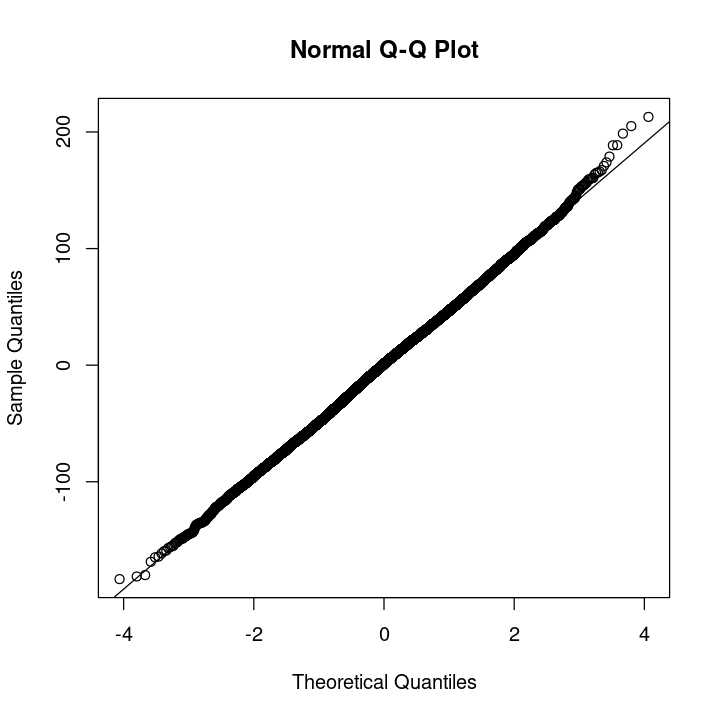

In [104]:
options(repr.plot.width= 6, repr.plot.height= 6)

qqnorm(residuals(a02, type= "pearson"))
qqline(residuals(a02, type= "pearson"))


In [ ]:
### COMMENT:

# The a02 model can still be improved.  Some of the predictors
# used in the model are highly correlated: population is highly
# correlated with households; median_income is highly correlated
# with median_house_value; and bdrms_per_room is highly correlated
# with median_income.


In [11]:
# Create data for checking correlations.  Leave out latitude
# and long_transf terms since I know I want these predictors 
# in the model.

tmpdat <- dat[, c("housing_median_age","total_rooms","total_bedrooms",
                  "population","households","median_income",
                  "median_house_value","HHdens_ln","bdrms_per_room")]


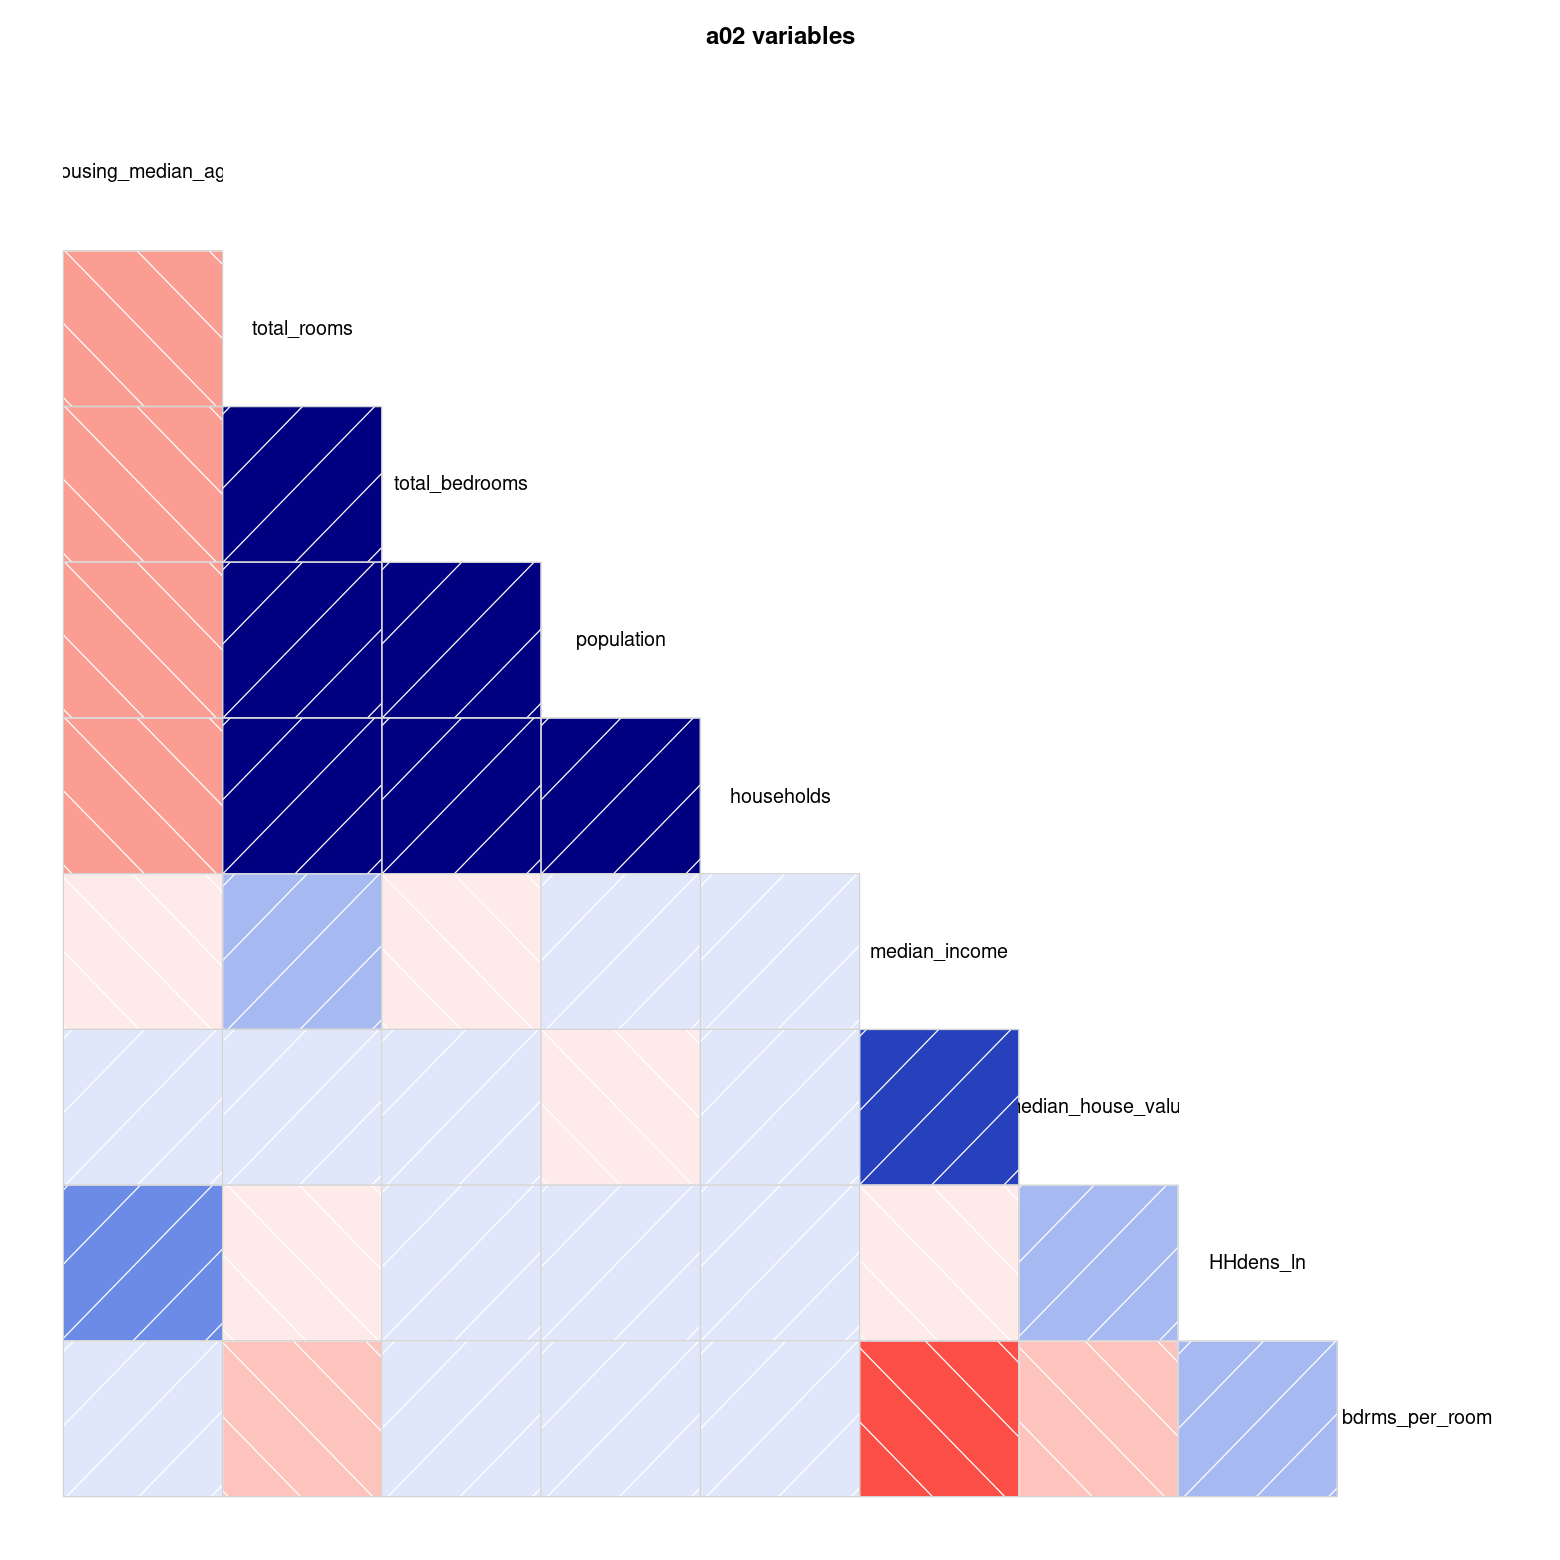

In [14]:
# Darker colors represent higher correlations.  Blue is for
# positive correlations; red is for negative correlations.

options(repr.plot.width= 13, repr.plot.height= 13)

# The following function is from package corrgram.
corrgram(tmpdat, lower.panel=panel.shade, upper.panel=NULL,
        text.panel=panel.txt, main="a02 variables", cex=1.5)


In [15]:
# Correlation between households and population:

print(round(cor(tmpdat$households, tmpdat$population), 3))
# [1] 0.912


[1] 0.912


In [16]:
# Correlation between households and total_rooms:

print(round(cor(tmpdat$households, tmpdat$total_rooms), 3))
# [1] 0.919


[1] 0.919


In [17]:
# Correlation between population and total_rooms:

print(round(cor(tmpdat$population, tmpdat$total_rooms), 3))
# [1] 0.862


[1] 0.862


In [18]:
# I could replace population and households with pop_per_hh.
# pop_per_hh is not highly correlated with total_rooms.
# But I am using weights based on households, so should
# probably keep households in the model.  Also when I model
# with pop_per_hh, the term has a p-value of 0.73.

print(round(cor(dat$pop_per_hh, dat$total_rooms), 3))
# -0.109


[1] -0.109


In [113]:
print(round(cor(dat$households, dat$total_bedrooms), 3))
# 0.975


[1] 0.975


In [20]:
# If we include households in the model, we ought to
# exclude total_bedrooms, total_rooms, and population.
# Otherwise we have collinearity, which can greatly
# increase the standard errors for our coefficient 
# estimates.


# bdrms_per_room is difficult to add to the model and still
# maintain linearity with respect to the fitted values.  So
# it, too, does not appear in a03.

a03 <- lm(housing_median_age ~ 

            I(long_transf^-1) +
            I(long_transf^-1.5) +
          
            latitude +
            I(latitude^2) +
            I(latitude^3) + 
            I(latitude^4) +
          
            I(households^0.55) +
            I(households^1.1) +
          
            I(median_house_value^0.48) +
            I(median_house_value^0.24) +
          
            I(HHdens_ln^1.35) +
            I(HHdens_ln^2.7),
          
          data= dat, weights= dat$households^0.55)

## REMINDER: dat has censored housing_median_age values.

a03.summary <- summary(a03); 
a03.summary[[1]] <- ""; a03.summary



Call:
""

Weighted Residuals:
    Min      1Q  Median      3Q     Max 
-229.00  -36.97    1.64   35.26  239.57 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)
(Intercept)                -8.92e+04   5.71e+03   -15.6   <2e-16
I(long_transf^-1)           4.43e+02   1.78e+01    24.9   <2e-16
I(long_transf^-1.5)        -4.93e+02   2.13e+01   -23.1   <2e-16
latitude                    9.73e+03   6.28e+02    15.5   <2e-16
I(latitude^2)              -3.97e+02   2.59e+01   -15.3   <2e-16
I(latitude^3)               7.19e+00   4.73e-01    15.2   <2e-16
I(latitude^4)              -4.88e-02   3.23e-03   -15.1   <2e-16
I(households^0.55)         -6.26e-01   1.96e-02   -31.9   <2e-16
I(households^1.1)           2.73e-03   2.15e-04    12.7   <2e-16
I(median_house_value^0.48)  2.69e-01   1.05e-02    25.7   <2e-16
I(median_house_value^0.24) -1.04e+01   3.97e-01   -26.2   <2e-16
I(HHdens_ln^1.35)          -9.87e-01   7.66e-02   -12.9   <2e-16
I(HHdens_ln^2.7)           

In [21]:
ncvTest(a03)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.13688, Df = 1, p = 0.711

In [22]:
residualPlots(a03, plot=FALSE)


                           Test stat Pr(>|Test stat|)
I(long_transf^-1)              -6.43          1.3e-10
I(long_transf^-1.5)            -6.53          6.7e-11
latitude                      -10.83          < 2e-16
I(latitude^2)                  -9.83          < 2e-16
I(latitude^3)                  -8.94          < 2e-16
I(latitude^4)                  -8.36          < 2e-16
I(households^0.55)             -8.07          7.2e-16
I(households^1.1)               5.08          3.8e-07
I(median_house_value^0.48)     -5.82          5.9e-09
I(median_house_value^0.24)     -7.61          2.8e-14
I(HHdens_ln^1.35)               7.57          3.8e-14
I(HHdens_ln^2.7)                5.70          1.2e-08
Tukey test                      0.05             0.96


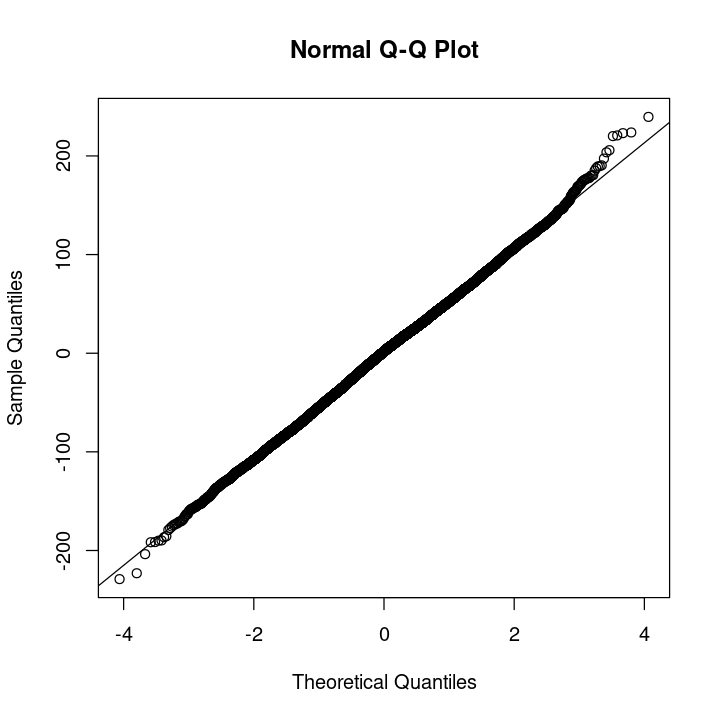

In [160]:
options(repr.plot.width= 6, repr.plot.height= 6)

qqnorm(residuals(a03, type= "pearson"))
qqline(residuals(a03, type= "pearson"))


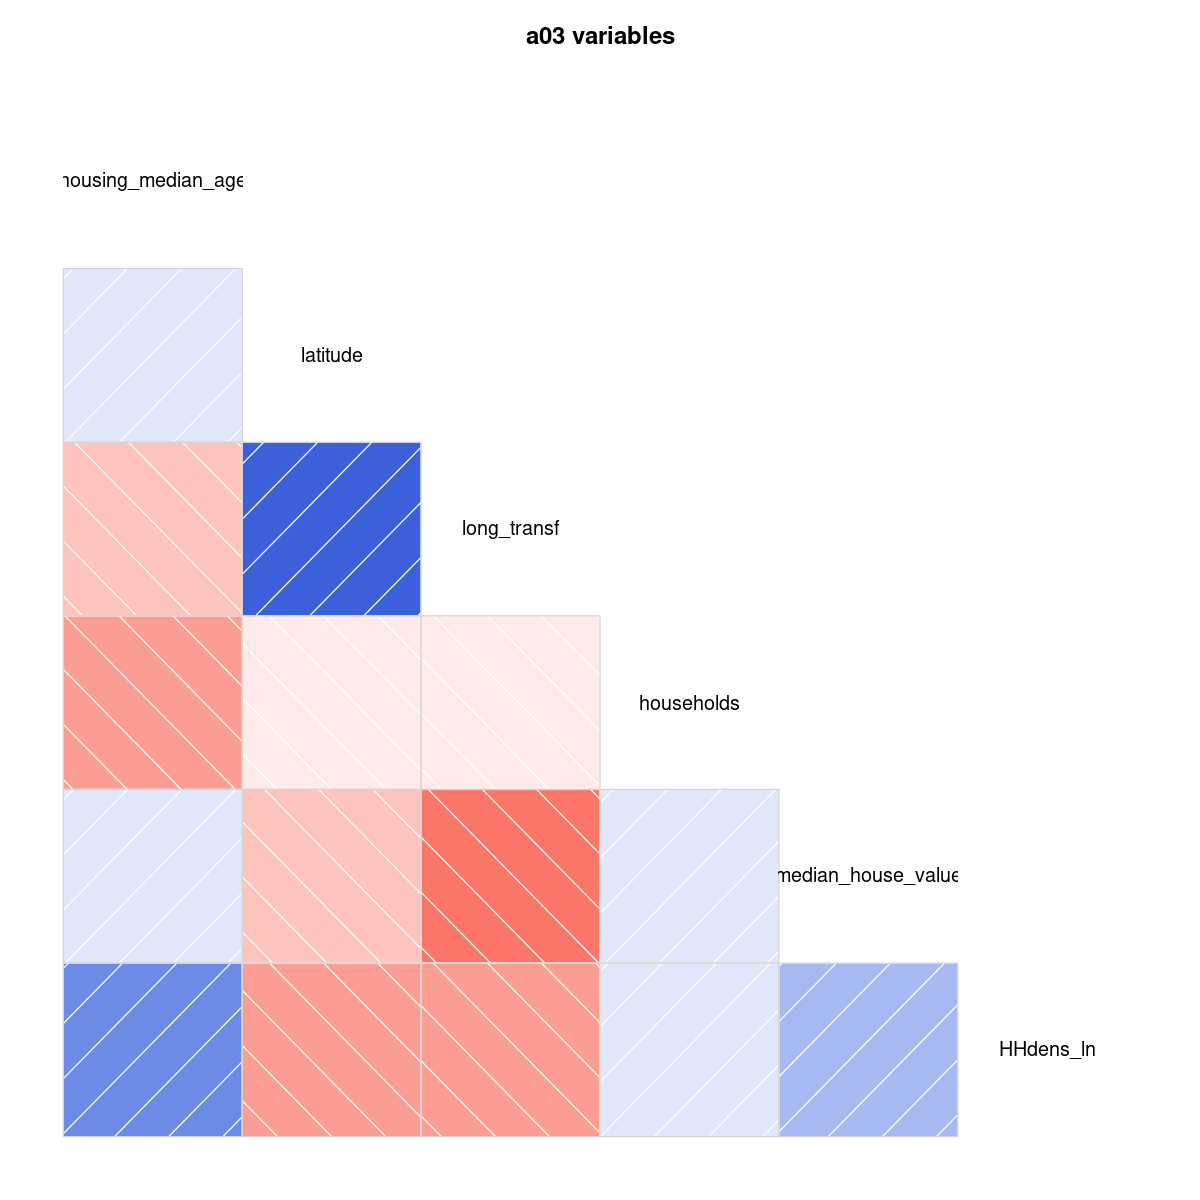

In [157]:
# Another check for correlation betw. the predictors, and
# the degree of correlation with the response variable.

tmpdat <- dat[, c("housing_median_age","latitude","long_transf",
                  "households","median_house_value",
                  "HHdens_ln")]

options(repr.plot.width= 10, repr.plot.height= 10)

# The following function is from package corrgram.
corrgram(tmpdat, lower.panel=panel.shade, upper.panel=NULL,
        text.panel=panel.txt, main="a03 variables", cex=1.5)


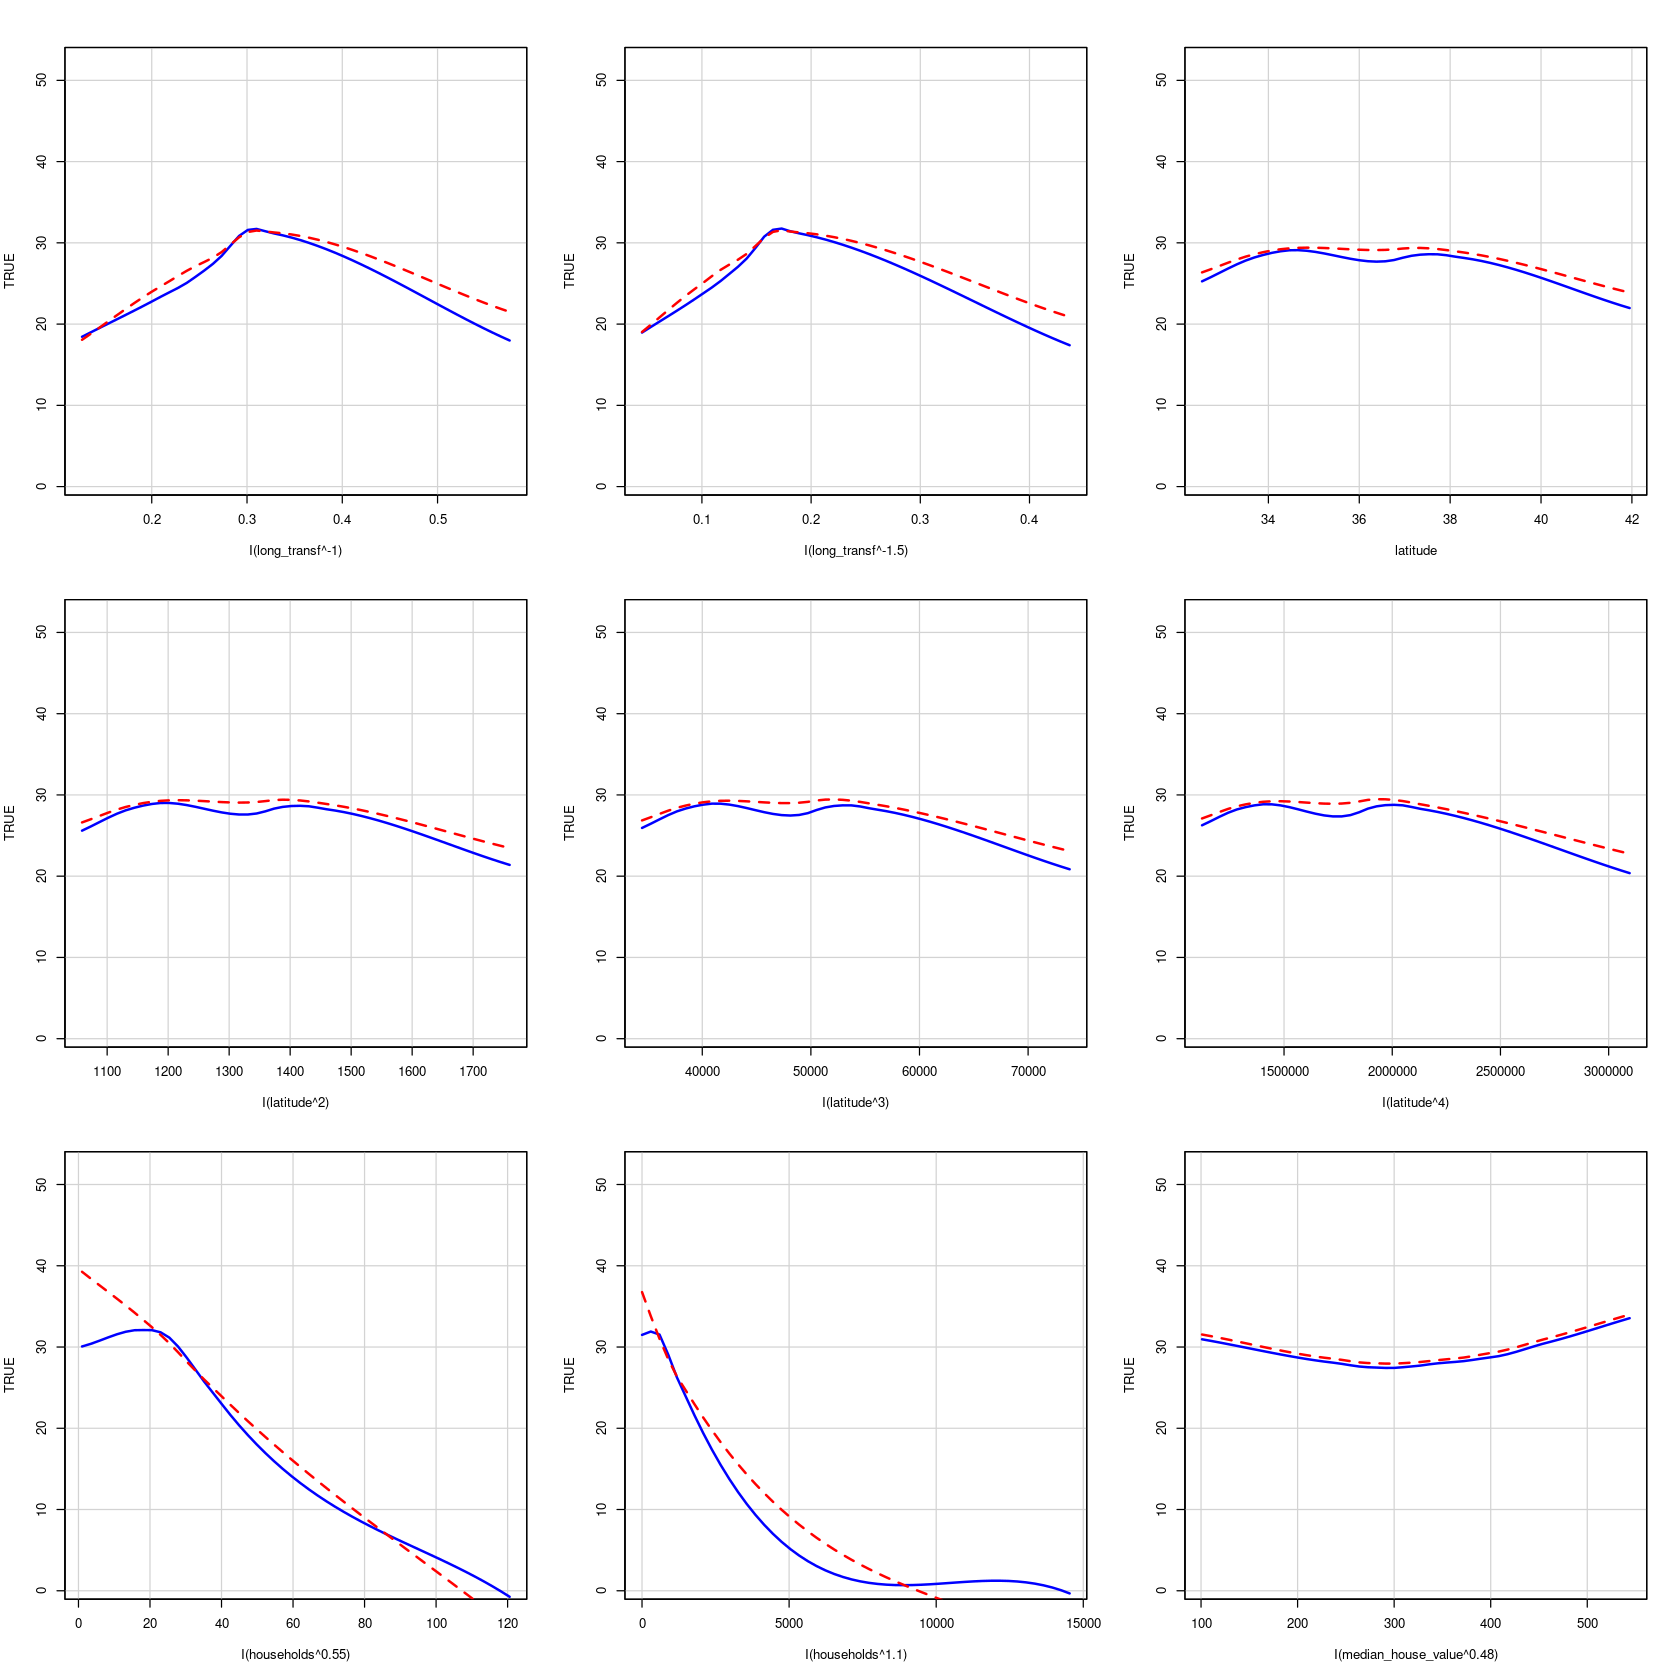

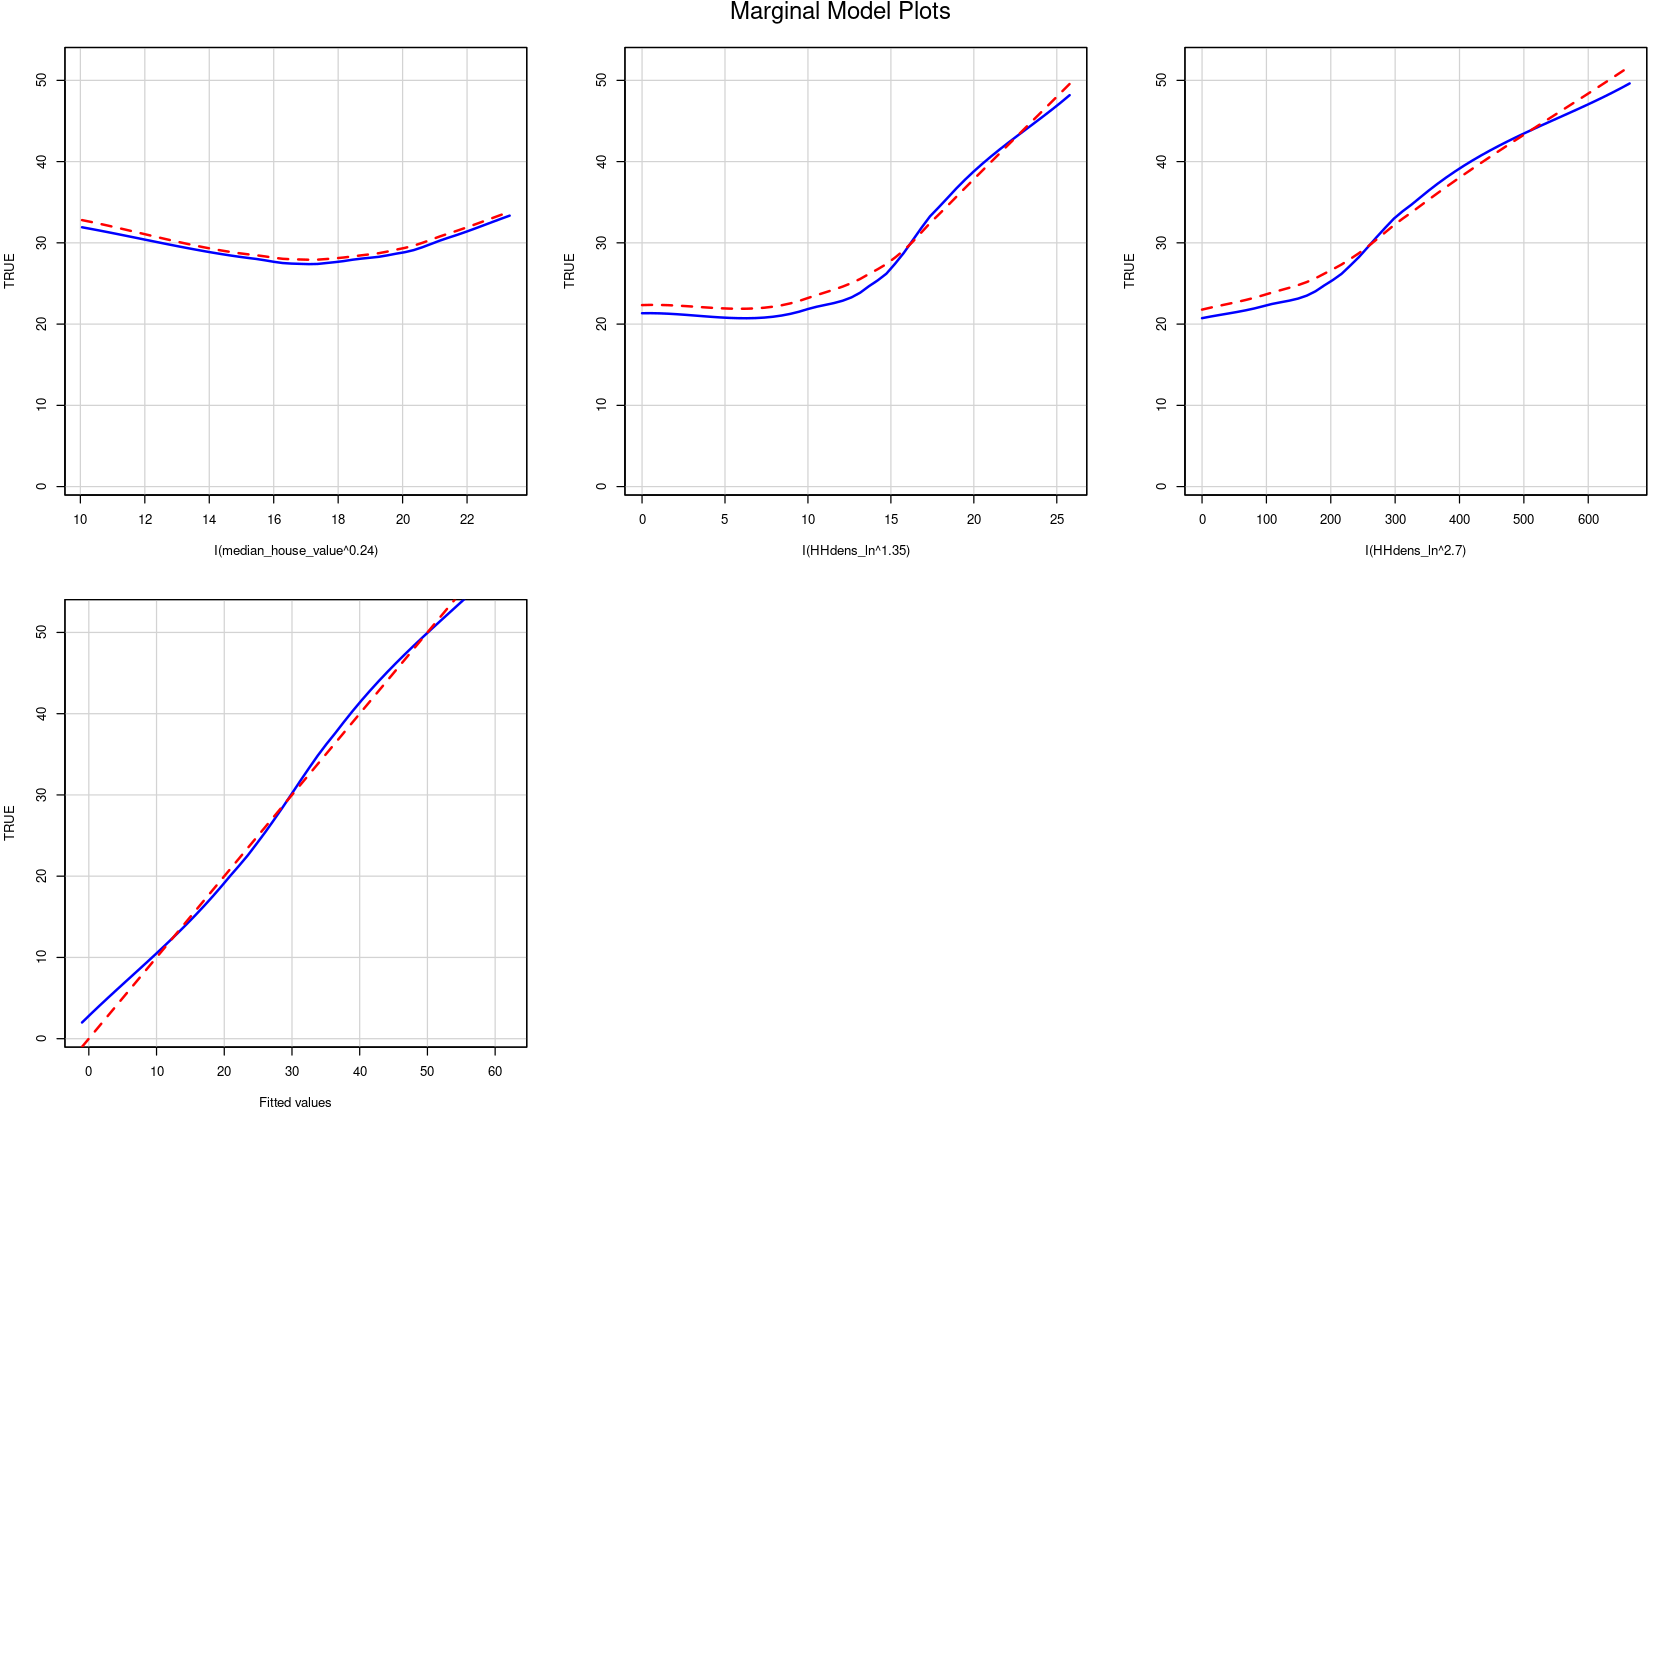

In [158]:
# The a03 model was a bit of a challenge to tune.
# Here I am showing the marginal model plots that
# helped me find the power transformations that I used.

options(repr.plot.width= 14, repr.plot.height= 14)

# blue= data; red= model
suppressWarnings(mmps(a03, ~., pch=NA))


In [7]:
# We now have 18 fewer parameters for which
# the Gibbs sampler needs to find a value.

dim(a03.summary$coefficients)[1]
# 13


[1] 13

In [161]:
# The fact that a03 is WLS rather than OLS does not
# present a problem for the Gibbs sampling algorithm.

# The sim function is from package arm.  It provides
# distributions for the inferential uncertainty of 
# each of the parameters in the a03 model.

a03.sim <- sim(a03, n.sims=3000)


In [162]:
# A model assumption for a03 is that the errors are
# normally distributed.  A parameter for this normal
# distribution is sigma, describing the spread of 
# the distribution of errors.

sigma.a03.sim <- sigma.hat(a03.sim)
str(sigma.a03.sim)


 num [1:3000] 53.7 53.9 53.8 53.9 53.8 ...


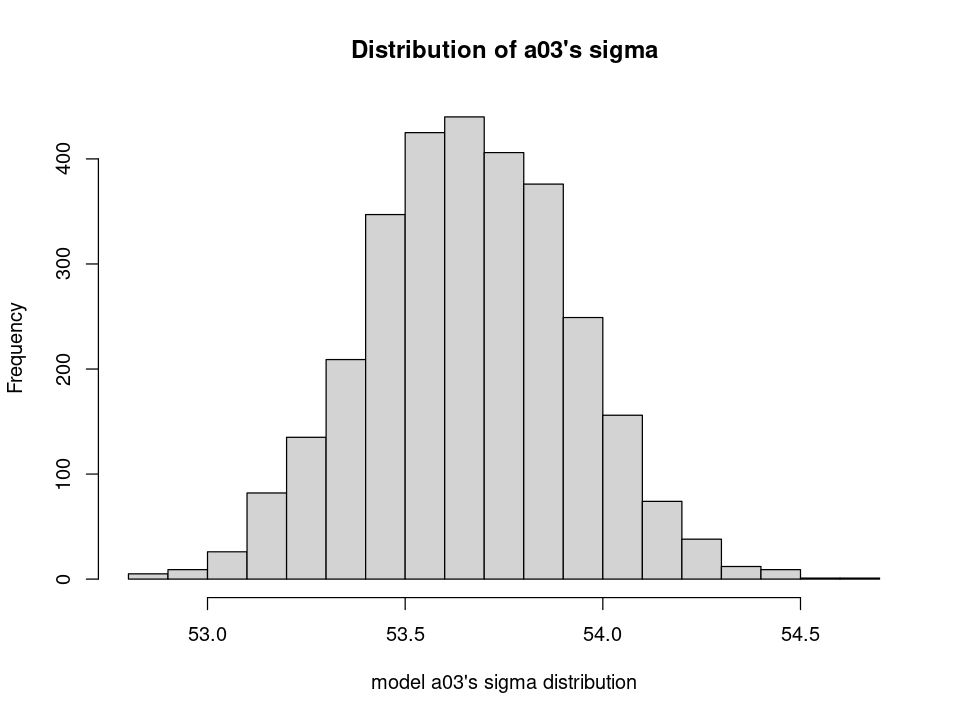

In [163]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(sigma.a03.sim, breaks=20, main="Distribution of a03's sigma",
     xlab="model a03's sigma distribution")


In [164]:
coef.a03.sim <- coef(a03.sim)
apply(coef.a03.sim, 2, quantile)


,(Intercept),I(long_transf^-1),I(long_transf^-1.5),latitude,I(latitude^2),I(latitude^3),I(latitude^4),I(households^0.55),I(households^1.1),I(median_house_value^0.48),I(median_house_value^0.24),I(HHdens_ln^1.35),I(HHdens_ln^2.7)
0%,-108935,387.39,-568.90,7463.7,-486.75,5.5003,-0.059986,-0.68950,0.0019836,0.22776,-11.606,-1.24768,0.072697
25%,-93142,431.66,-507.59,9329.9,-415.16,6.8903,-0.051048,-0.63905,0.0025905,0.26193,-10.670,-1.04153,0.081993
50%,-89234,442.82,-492.83,9737.1,-397.51,7.2015,-0.048831,-0.62556,0.0027285,0.26915,-10.405,-0.98877,0.084004
75%,-85585,455.07,-479.12,10165.7,-380.62,7.5233,-0.046708,-0.61304,0.0028787,0.27615,-10.131,-0.93499,0.085981
100%,-68522,505.73,-424.89,11905.1,-304.12,8.8312,-0.037251,-0.56204,0.0034367,0.30035,-8.796,-0.67930,0.093752


## Gibbs sampler for imputing censored housing_median_ages

See Section 18.5 of Gelman and Hill's book (and my introduction to Section 2 above).

The actual imputation process is found in Appendix A.  The reason for this has to do with the work needed for predicting a mean and median for the unknown housing median ages of the 1268 records which require an imputed value.  We want to know the mean and median to help us understand what the shape of the distribution of imputed values should look like.  What follows is an outline of the process, assuming we already have our predictions for the mean and median in hand.


Notice in the next cell that I set an upper limit for housing_median_age of 78 years.  Initially I ran the process with the upper limit at 90 (and before that, at 104).  The housing_median_age values we have are from the 1990 census.  I do not expect there to be many districts in California for which the housing median age is greater than 78, i.e., where at least half of the homes in the district were built prior to 1912.  As we increase the upper limit, the average standard deviation for a prediction increases quite a bit (e.g.,from 11 years, for an upper limit of 90, to 15 years, for an upper limit of 104).  So there is a trade-off between allowing for all possible districts in our predictions and the accuracy of our predictions for the vast majority of districts.  The more inclusive we try to be, the less accurate our predictions are, in general.  By setting a reasonable upper limit, I am trying to strike a balance.  In Appendix A, this upper limit ultimately gets lowered to age 75. 


                                        * * * * *



In [47]:
C <- 52
censored <- dat$housing_median_age >= C

# Create an upper limit.
C_upper <- 78

# Create some crude starting values for our imputed ages.
n.censored <- sum(censored)
z <- ifelse(censored, NA, dat$housing_median_age)
z[censored] <- runif(n.censored, C, C_upper)


In [48]:
length(censored)
n.censored


[1] 20603

[1] 1268

In [49]:
# See p.406 (Section 18.5) of Gelman and Hill's book.

# Fit a regression using the crude starting values of z.

a03.1 <- lm(z ~ 
            
            I(long_transf^-1) +
            I(long_transf^-1.5) +
            latitude +
            I(latitude^2) +
            I(latitude^3) + 
            I(latitude^4) +
            I(households^0.55) +
            I(households^1.1) +
            I(median_house_value^0.48) +
            I(median_house_value^0.24) +
            I(HHdens_ln^1.35) +
            I(HHdens_ln^2.7),
          
          data= dat, weights= dat$households^0.55)

# Obtain a sample draw of the model coefficients and of
# parameter sigma.
sim.1 <- sim(a03.1, n.sims=1)


In [50]:
str(sim.1)


Formal class 'sim' [package "arm"] with 2 slots
  ..@ coef : num [1, 1:13] -82615 456 -511 9036 -370 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : NULL
  .. .. ..$ : chr [1:13] "(Intercept)" "I(long_transf^-1)" "I(long_transf^-1.5)" "latitude" ...
  ..@ sigma: num 61.3


In [51]:
beta <- coef(sim.1)
dim(beta)
colnames(beta)


[1]  1 13

[1] "(Intercept)"                "I(long_transf^-1)"         
 [3] "I(long_transf^-1.5)"        "latitude"                  
 [5] "I(latitude^2)"              "I(latitude^3)"             
 [7] "I(latitude^4)"              "I(households^0.55)"        
 [9] "I(households^1.1)"          "I(median_house_value^0.48)"
[11] "I(median_house_value^0.24)" "I(HHdens_ln^1.35)"         
[13] "I(HHdens_ln^2.7)"

In [52]:
beta[, 1]
beta[, 2]


(Intercept) 
     -82615

I(long_transf^-1) 
           455.69

In [53]:
# Value of sigma from a sample draw of 1.
(sigma <- sigma.hat(sim.1))


[1] 61.251

In [54]:
# Function to draw from a constrained normal distribution.

rnorm.trunc <- function(n, mu, sigma, lo=-Inf, hi=Inf) {
    
    # We need mu to be at least the value of C in
    # order to prevent a return of Inf values.
    mu02 <- ifelse(mu < C, C, mu)
    
    p.lo <- pnorm(lo, mu02, sigma)
    p.hi <- pnorm(hi, mu02, sigma)
    u <- runif(n, p.lo, p.hi)
    return(qnorm(u, mu02, sigma))
}


In [55]:
# Create matrix X for the terms in our model.

X <- dat

X$long1 <- (X$long_transf)^-1
X$long2 <- (X$long_transf)^-1.5

X$lat2 <- (X$latitude)^2
X$lat3 <- (X$latitude)^3
X$lat4 <- (X$latitude)^4

X$hh1 <- (X$households)^0.55
X$hh2 <- (X$households)^1.10

X$median_hhval_1 <- (X$median_house_value)^0.24
X$median_hhval_2 <- (X$median_house_value)^0.48

X$HHdens_ln1 <- (X$HHdens_ln)^1.35
X$HHdens_ln2 <- (X$HHdens_ln)^2.7


X <- X[, c("long1","long2","latitude","lat2","lat3","lat4",
           "hh1","hh2","median_hhval_1","median_hhval_2",
           "HHdens_ln1","HHdens_ln2")]
intercept <- rep(1, nrow(dat))

init.colnames <- colnames(X)

X <- as.data.frame(cbind(intercept, X), col.names=c("intercept", init.colnames),
                   row.names=rownames(dat))
dim(X)
colnames(X)


[1] 20603    13

[1] "intercept"      "long1"          "long2"          "latitude"      
 [5] "lat2"           "lat3"           "lat4"           "hh1"           
 [9] "hh2"            "median_hhval_1" "median_hhval_2" "HHdens_ln1"    
[13] "HHdens_ln2"

In [56]:
# Here are means for 6 different normal
# distributions.  For each, sigma is 61.3 years.
means <- as.matrix(X) %*% t(beta)
length(means)
round(head(as.vector(means)), 2)


[1] 20603

[1] -5583.0 -4991.8 -4927.6 -4850.1 -4857.4 -4315.5

In [57]:
# All values should be between 52 and 78.
z.old <- z[censored]
round(head(z.old), 2)


[1] 70.68 75.27 66.67 69.72 62.92 65.26

In [58]:
# All values should be between 52 and 78.
z.new <- rnorm.trunc(n.censored, means[censored], sigma, lo=C, hi=C_upper)
round(head(as.vector(z.new)), 2)


[1] 61.09 60.03 62.95 69.53 74.78 60.20

In [59]:
# For the Gibbs sampler, the above is now put into
# a loop.  We first test with 100 iterations.

n <- nrow(dat)
n.chains <- 4
n.iter <- 2000

sims <- array(NA, c(n.iter, n.chains, 14 + n.censored))
dimnames(sims) <- list(NULL, NULL, c(colnames(X), "sigma", 
                                     paste("z[", (1:n)[censored],
                                           "]", sep="")))

start <- Sys.time()
for(m in 1:n.chains) {
    
    # acquire some initial values
    z[censored] <- runif(n.censored, C, C_upper)
    
    for(t in 1:n.iter) {
        
        a03.1 <- lm(z ~ 
                    
            I(long_transf^-1) +
            I(long_transf^-1.5) +
            latitude +
            I(latitude^2) +
            I(latitude^3) + 
            I(latitude^4) +
            I(households^0.55) +
            I(households^1.1) +
            I(median_house_value^0.48) +
            I(median_house_value^0.24) +
            I(HHdens_ln^1.35) +
            I(HHdens_ln^2.7),
          
            data= dat, weights= dat$households^0.55)
        
        sim.1 <- sim(a03.1, n.sims=1)
        beta <- coef(sim.1)
        sigma <- sigma.hat(sim.1)
        means <- as.matrix(X) %*% t(beta)
        z[censored] <- rnorm.trunc(n.censored, means[censored], sigma, lo=C, hi=C_upper)
        sims[t,m,] <- c(beta, sigma, z[censored])
    }
}

stop <- Sys.time()
round(stop - start, 2)
# Time difference of 5.6 mins (for 2K iterations)


Time difference of 5.63 mins

In [ ]:
# We check for convergence as follows:

sims.bugs <- R2OpenBUGS::as.bugs.array(sims, n.burnin=1000)
print(sims.bugs)

# The Rhat value for every parameter and every imputed
# value should be 1.0.


In [ ]:
str(sims.bugs)

# Output for this cell has been removed because it
# interferes with the output of cells further downstream.


In [60]:
## The actual imputation is now found in Appendix A.

# save(sims, file="/home/greg/Documents/stat/Geron_ML/datasets/housing/sims_raw_age.RData")


In [3]:
load("/home/greg/Documents/stat/Geron_ML/datasets/housing/sims_raw_age.RData")


In [4]:
# Drop the first 1000 iterations.

sims_adj <- sims[1001:2000, ,]
dim(sims_adj)


[1] 1000    4 1282

In [5]:
# Check that the means and stddevs for the parameters and 
# imputed values does not include the burn-in values.

sims_adj.bugs <- R2OpenBUGS::as.bugs.array(sims_adj)
# print(sims_adj.bugs)


In [63]:
# Extract the means and stddevs for each of the censored records.

z_means <- sims_adj.bugs$mean$z
z_sds <- sims_adj.bugs$sd$z
round(head(z_means), 2); round(head(z_sds), 2)


[1] 64.60 64.73 64.89 64.76 64.91 65.03

[1] 7.47 7.60 7.42 7.47 7.39 7.48

In [64]:
summary(z_means)
summary(z_sds)

# Notice that the minimum stddev is 7.3 years. and
# that the average stddev is close to 7.5 years.


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   64.4    64.7    64.8    64.8    64.9    65.2 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   7.31    7.44    7.48    7.48    7.51    7.64 

In [ ]:
### COMMENTS:

# Based on the work in Appendix A, I expect the mean for the
# censored records to be about 57.5, not 65.  I adjust for this
# by subtracting 8 from each prediction.  


In [65]:
# Get some predictions, using rnorm.trunc.

z_preds <- round(rnorm.trunc(n.censored, z_means, z_sds, lo=C, hi=C_upper), 1)
summary(z_preds)

# Notice that the mean and median of our predictions are around 65.


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   52.4    60.3    64.9    65.0    69.6    77.8 

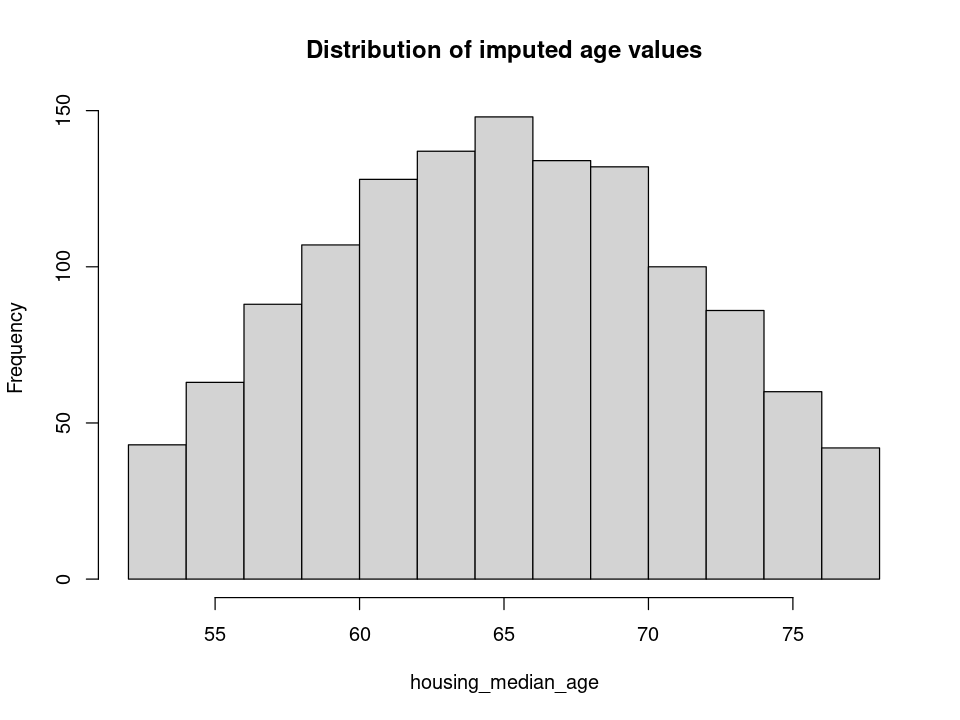

In [66]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(z_preds, breaks=14, main="Distribution of imputed age values",
     xlab="housing_median_age")


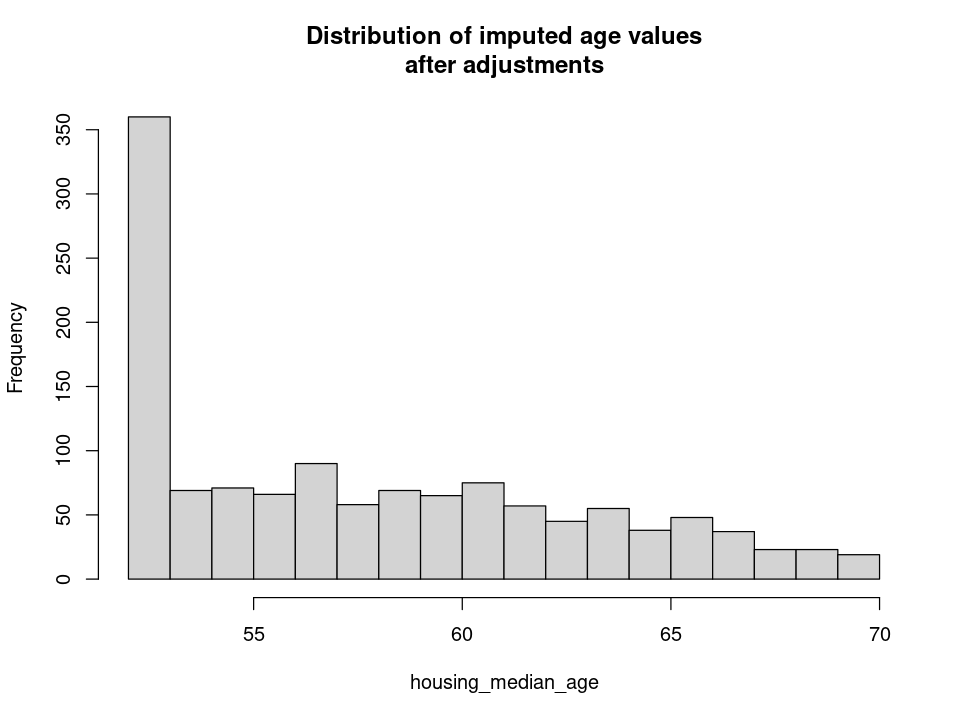

In [67]:
# Adjust the predictions based on what we learn in 
# Appendix A.  We want the mean of our imputed values
# to be about 57.5.

z_preds <- z_preds - 8
preds_adj <- ifelse(z_preds < 52, 52, z_preds)

options(repr.plot.width= 8, repr.plot.height= 6)

hist(preds_adj, breaks=14, main="Distribution of imputed age values
after adjustments",
     xlab="housing_median_age")


In [68]:
summary(preds_adj)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   52.0    52.3    56.9    57.7    61.6    69.8 

In [ ]:
### COMMENTS:

# Remaining problem with the current set of predictions:

# (1) We do not expect there to be a sudden drop in the number
# of districts as housing_median_age increases from 52 to 
# 53; we expect the drop, if there is one, to be more gradual; 

# We can fix this by adjusting z_means prior to 
# calling rnorm.trunc.


In [70]:
# The following provides us with a start.  The subtrahend
# used here will need to be adjusted once we see the truncated
# output from rnorm.trunc.

(z_means_bar <- mean(z_means))
z_means_adj <- z_means - (z_means_bar - 57)
mean(z_means_adj)


[1] 64.808

[1] 57

In [71]:
# Get new predictions.  I have lowered the upper limit from
# 78 to 75.

set.seed(1933)
z_preds <- round(rnorm.trunc(n.censored, z_means_adj, z_sds, lo=C, hi=75), 2)
summary(z_preds)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   52.0    55.7    59.1    60.0    63.4    75.0 

In [74]:
# Make another correction.

z_means_adj <- z_means - (z_means_bar - 50)
mean(z_means_adj)

set.seed(1933)
z_preds <- round(rnorm.trunc(n.censored, z_means_adj, z_sds, lo=C, hi=75), 2)
summary(z_preds)
# The mean is now at about 58.


[1] 50

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   52.0    54.3    56.8    57.9    60.5    74.9 

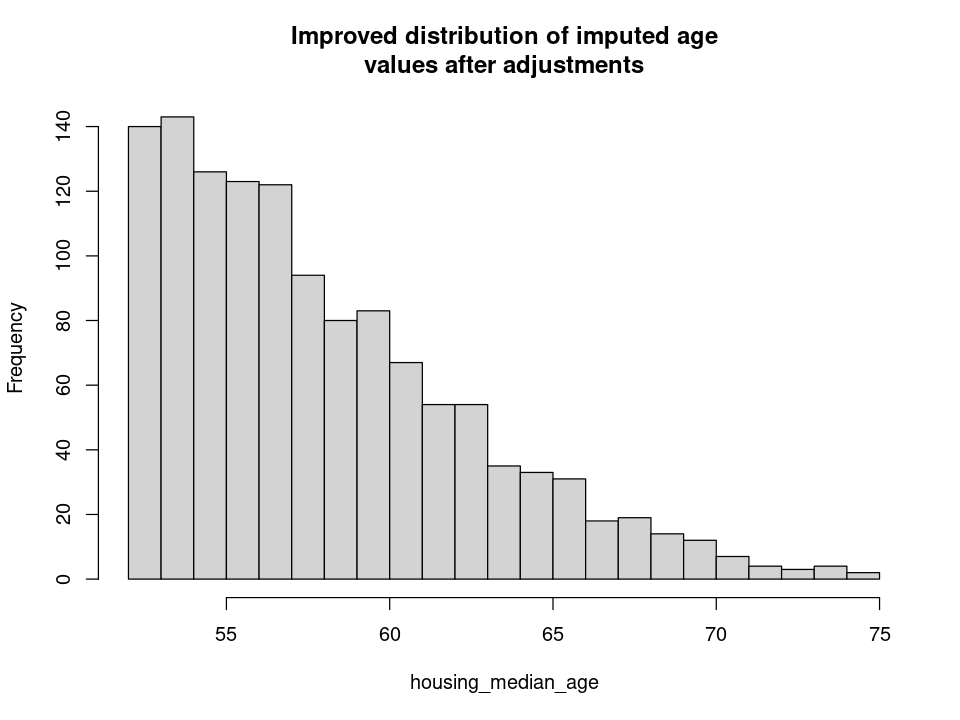

In [75]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(z_preds, breaks=20, 
     main="Improved distribution of imputed age
values after adjustments", xlab="housing_median_age")


In [76]:
# Assign imputed values.

newdat <- dat
newdat$housing_median_age[censored] <- z_preds


In [77]:
summary(newdat$housing_median_age)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0    18.0    29.0    29.0    37.0    74.9 

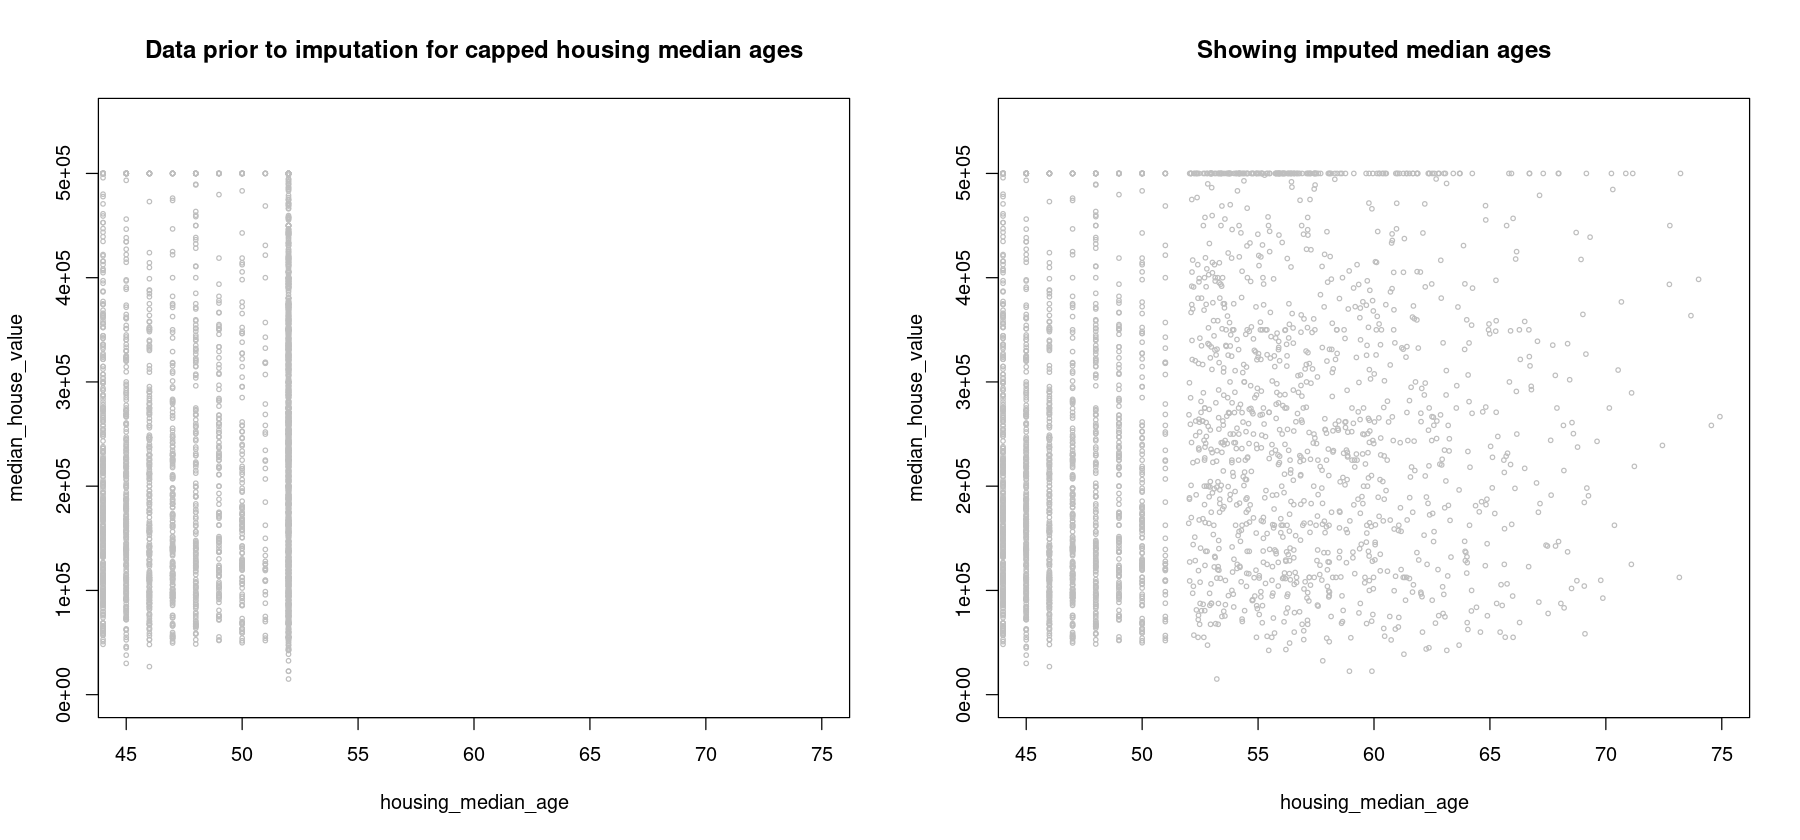

In [78]:
# Plot both before and after.

options(repr.plot.width= 15, repr.plot.height= 7)

mat <- t(as.matrix(c(1,2)))
layout(mat, widths = rep.int(20, ncol(mat)),
       heights = rep.int(7, nrow(mat)), respect = FALSE)

# layout.show(n = 2)

# plot the "before" scatter
plot(dat$housing_median_age, dat$median_house_value, type= "p", pch=1, cex=0.5, col="grey",
     xlab= "housing_median_age", ylab= "median_house_value", ylim= c(0, 0.55e06), xlim= c(45, 75),
     main= "Data prior to imputation for capped housing median ages")


# plot the newly predicted values
plot(newdat$housing_median_age, newdat$median_house_value, type= "p", pch=1, cex=0.5, col="grey",
     xlab= "housing_median_age", ylab= "median_house_value", ylim= c(0, 0.55e06), xlim= c(45, 75),
     main= "Showing imputed median ages")


### Save to disk

In [79]:
# This is done in Appendix A.

# write.csv(newdat,
#           file="/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v03.csv",
#           row.names=TRUE)


In [80]:
rm(newdat)

In [6]:
dat <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v03.csv",
                header=TRUE, row.names=1,
                colClasses= c("character", rep("numeric", 9), "character",
                              rep("numeric", 5)))
dim(dat); colnames(dat)


[1] 20603    15

[1] "longitude"          "latitude"           "housing_median_age"
 [4] "total_rooms"        "total_bedrooms"     "population"        
 [7] "households"         "median_income"      "median_house_value"
[10] "ocean_proximity"    "rooms_per_hh"       "bdrms_per_room"    
[13] "pop_per_hh"         "HHdens_ln"          "long_transf"

### Check new coefficients for model a03 against Gibbs sampler estimates

Model a03.2 below has different coefficients than the a03 model because the regression now includes the final set of imputed values. 

See pp.402-404 of Gelman and Hill's book, *Data Analysis Using Regression and Multilevel/Hierarchical Models* for more context regarding what I am doing in this section.  Any set of predictions we draw for the imputed values should leave us with a model whose coefficient estimates "align" with those generated by the Gibbs sampler.  Checking that this is so is especially important in the present case because the predictions I am using for the imputed housing_median_age values are forced to have a mean of 57 rather than 65).  If there is alignment, we have further justification for saying that our set of imputed values are plausible.

The Gibbs sampler output is valuable because it quantifies the inferential uncertainty found in the estimates for the a03 model.  As that model shows, most of the variance for age is unexplained.  Thus, the standard deviation for each of the imputed values is quite large.  The quantification of the uncertainty provides us with a way of checking the quality of our imputed values.  If our model coefficients are consistent with the uncertainty measures given by the Gibbs sampler---even though our final imputed values have a mean that is 8 years shy of the mean predicted by the Gibbs sampler,---, then we can say the imputed values make sense based on the information we have to work with.


                                       * * * * *

In [7]:
# This model passes neither the Tukey test in residualPlots() nor
# the ncv test.
# Since we only need it to check coefficients against the Gibbs
# sampler output, I will not bother to tune it.

a03.2 <- lm(housing_median_age ~ 
            
            I(long_transf^-1) +
            I(long_transf^-1.5) +
            latitude +
            I(latitude^2) +
            I(latitude^3) + 
            I(latitude^4) +
            I(households^0.55) +
            I(households^1.1) +
            I(median_house_value^0.48) +
            I(median_house_value^0.24) +
            I(HHdens_ln^1.35) +
            I(HHdens_ln^2.7),
          
            data= dat, weights= dat$households^0.55)

a03.2.summary <- summary(a03.2)
a03.2.summary[[1]] <- ""; a03.2.summary



Call:
""

Weighted Residuals:
    Min      1Q  Median      3Q     Max 
-241.01  -38.36    0.24   34.48  300.02 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)
(Intercept)                -8.76e+04   6.04e+03   -14.5   <2e-16
I(long_transf^-1)           4.46e+02   1.89e+01    23.6   <2e-16
I(long_transf^-1.5)        -4.96e+02   2.26e+01   -22.0   <2e-16
latitude                    9.56e+03   6.65e+02    14.4   <2e-16
I(latitude^2)              -3.91e+02   2.74e+01   -14.3   <2e-16
I(latitude^3)               7.08e+00   5.01e-01    14.1   <2e-16
I(latitude^4)              -4.81e-02   3.42e-03   -14.0   <2e-16
I(households^0.55)         -6.58e-01   2.08e-02   -31.7   <2e-16
I(households^1.1)           2.98e-03   2.28e-04    13.1   <2e-16
I(median_house_value^0.48)  2.81e-01   1.11e-02    25.4   <2e-16
I(median_house_value^0.24) -1.08e+01   4.20e-01   -25.7   <2e-16
I(HHdens_ln^1.35)          -1.20e+00   8.11e-02   -14.7   <2e-16
I(HHdens_ln^2.7)           

In [8]:
ncvTest(a03.2)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 75.953, Df = 1, p = <2e-16

In [9]:
residualPlots(a03.2, plot= FALSE)


                           Test stat Pr(>|Test stat|)
I(long_transf^-1)              -5.44          5.4e-08
I(long_transf^-1.5)            -5.47          4.6e-08
latitude                       -9.97          < 2e-16
I(latitude^2)                  -8.94          < 2e-16
I(latitude^3)                  -8.09          6.3e-16
I(latitude^4)                  -7.55          4.5e-14
I(households^0.55)             -7.43          1.1e-13
I(households^1.1)               4.50          6.7e-06
I(median_house_value^0.48)     -4.65          3.3e-06
I(median_house_value^0.24)     -6.48          9.2e-11
I(HHdens_ln^1.35)               9.08          < 2e-16
I(HHdens_ln^2.7)                8.88          < 2e-16
Tukey test                      3.10           0.0019


In [10]:
sim_means <- unlist(sims_adj.bugs$mean[1:14])
sim_sds <- unlist(sims_adj.bugs$sd[1:14])
print(round(head(sim_means), 2)); print(round(head(sim_sds), 2))
                                    

intercept     long1     long2  latitude      lat2      lat3 
-85547.39    450.93   -503.07   9346.51   -382.01      6.93 
intercept     long1     long2  latitude      lat2      lat3 
  6419.50     20.33     24.30    706.38     29.09      0.53 


In [11]:
# Function to check that our model coefficients, now influenced
# by the imputed values, are consistent with the Gibbs sampler
# estimates.

# (See pp.402-404 of Gelman and Hill's book.  The following 
# function is my own creation.  We will see further downstream
# that for the current model, this is a very weak test.)

check_coeffs <- function(coef_ests, coef_ses, sim_means, sim_sds,
                         tol_1=0.5, tol_2=1) {
    
    # coef_ests, coef_ses, sim_means, and sim_sds should all  
    # have the same ordering for the terms involved.
    
    n_coefs <- length(coef_ests)
    result <- rep(FALSE, n_coefs)
    names(result) <- names(coef_ests)
    
    for(i in 1:n_coefs) {
        
        upper <- sim_means[i] + tol_1*sim_sds[i]
        lower <- sim_means[i] - tol_1*sim_sds[i]
        
        coef_est <- as.numeric(coef_ests[i])
        coef_se <- as.numeric(coef_ses[i])
        coef_upper <- coef_est + tol_2*coef_se
        coef_lower <- coef_est - tol_2*coef_se
        
        if((coef_upper > lower) & (coef_upper < upper)) result[i] <- TRUE
        if((coef_lower > lower) & (coef_lower < upper)) result[i] <- TRUE
        if((coef_est > lower) & (coef_est < upper)) result[i] <- TRUE
    }
    return(result)
}


In [12]:
# tol_1 parameter set to 0.5.

coef_ests <- a03.2.summary$coefficients[, 1]
coef_ses <- a03.2.summary$coefficients[, 2]

# The following coeffs did not pass the test for 
# tol_1 = 0.5 and tol_2 = 1.
ans <- check_coeffs(coef_ests, coef_ses, sim_means, sim_sds, tol_1=0.5)
print(ans[ans==FALSE])


        I(households^0.55) I(median_house_value^0.48) 
                     FALSE                      FALSE 
         I(HHdens_ln^1.35)           I(HHdens_ln^2.7) 
                     FALSE                      FALSE 


In [13]:
# tol_1 parameter set to 1.

ans <- check_coeffs(coef_ests, coef_ses, sim_means, sim_sds, tol_1=1)
print(ans[ans==FALSE])


I(HHdens_ln^1.35)  I(HHdens_ln^2.7) 
            FALSE             FALSE 


In [14]:
# tol_1 parameter set to 1.5.

ans <- check_coeffs(coef_ests, coef_ses, sim_means, sim_sds, tol_1=1.5)
print(ans[ans==FALSE])


I(HHdens_ln^1.35)  I(HHdens_ln^2.7) 
            FALSE             FALSE 


In [15]:
# tol_1 parameter set to 2.

ans <- check_coeffs(coef_ests, coef_ses, sim_means, sim_sds, tol_1=2)
print(ans[ans==FALSE])


I(HHdens_ln^2.7) 
           FALSE 


In [18]:
# tol_1 parameter set to 2.  tol_2 set to 2.

ans <- check_coeffs(coef_ests, coef_ses, sim_means, sim_sds, tol_1=2, tol_2=2)
print(ans[ans==FALSE])


named logical(0)


In [91]:
# Check Gibbs sampler values for HHdens_ln1.

round(sim_means["HHdens_ln1"], 4)
round(sim_sds["HHdens_ln1"], 4)


HHdens_ln1 
   -1.4208

HHdens_ln1 
    0.0906

In [ ]:
### COMMENT:

# The 95% CI for the HHdens_ln1 coefficient of a03.2
# is [-1.3622, -1.0378].

# The 95% CI for this term in the Gibbs sampler is:
# [-1.6020, -1.2396].


In [92]:
# Check Gibbs sampler values for HHdens_ln2.

round(sim_means["HHdens_ln2"], 6)
round(sim_sds["HHdens_ln2"], 6)


HHdens_ln2 
   0.10818

HHdens_ln2 
   0.00359

In [ ]:
### COMMENTS:

# The 95% CI for the HHdens_ln2 coeff. of a03.2
# is [0.0892, 0.1018].  The corresponding interval
# from the Gibbs sampler is:
# [0.1010, 0.1154].

# For this term, we have only a small degree of 
# overlap at 2 standard errors.

# Is the combined effect of HHdens_ln's terms in the a03.2  
# model nearly the same as the effect the HHdens_ln terms 
# have in a model based on estimates from the Gibbs sampler? 

# The answer to this question is worked out in the cells
# that follow.  (I want to show that the overlap of the
# combined effect is much greater that what we are seeing
# for these terms individually.)


In [93]:
round(mean(dat$HHdens_ln), 4)


[1] 7.2472

In [94]:
# Get covariance of the HHdens_ln terms in 
# the Gibbs sampler output.

A <- sims_adj.bugs$sims.list$HHdens_ln1
B <- sims_adj.bugs$sims.list$HHdens_ln2
cov(A, B, method="pearson")


[1] -0.00031315

In [95]:
# Get covariance of a03.2's coefficient estimates for
# the HHdens_ln terms.

sim.a03.2 <- sim(a03.2, n.sims=3000)
beta <- coef(sim.a03.2)
colnames(beta[, 12:13])


[1] "I(HHdens_ln^1.35)" "I(HHdens_ln^2.7)"

In [96]:
cov(beta[, 12], beta[, 13], method="pearson")


[1] -0.00024196

In [97]:
# We need to compute the variance of (aW + bZ) where
# W, Z are random variables (beta[,12] and beta[,13],
# respectively) and a,b are constants (HHdens_ln^1.35
# and HHdens_ln^2.7, respectively).

# Compute the variance at the mean of HHdens_ln (7.2472).

vals <- rep(NA, 20000)
const01 <- (mean(dat$HHdens_ln))^1.35
const02 <- const01^2

mu1 <- -1.20
mu2 <- 0.0955
sig1 <- 0.0811^2
sig2 <- 0.00317^2
sig12 <- -2.41956e-04

Sigma <- matrix(c(sig1, rep(sig12, 2), sig2), 2, 2)
mu <- c(mu1, mu2)

set.seed(1231)
for(i in 1:length(vals)) {
    
    ans <- mvrnorm(n=1, mu, Sigma, empirical=FALSE)
    vals[i] <- const01*ans[1] + const02*ans[2]
}

(a03.2.HHdens.terms.sd <- round(sd(vals), 6))
# 0.59787


[1] 0.59787

In [ ]:
# We can directly compute the stddev of (aW + bZ).  Since
# the mean of HHdens_ln is rounded, we get a somewhat less
# accurate result.

# At the mean value of HHdens_ln the variance of the sum of
# the 2 terms in the a03.2 model is:

# > (14.7015^2)*(0.0811^2) + (14.7015^4)*(0.00317^2) - 2*(14.7015^3)*(0.000241956)
# [1] 0.353355

# We thus have a standard error of 0.5944.  The more accurate
# value is 0.5979, since this did not involve a rounding of the mean.


In [98]:
# Here is the corresponding computation of the stddev
# for the (aW + bZ) term using values from the Gibbs 
# sampler.

vals <- rep(NA, 20000)
const01 <- (mean(dat$HHdens_ln))^1.35
const02 <- const01^2

mu1 <- -1.4208
mu2 <- 0.108183
sig1 <- 0.0906^2
sig2 <- 0.00359^2
sig12 <- -3.13152768e-04

Sigma <- matrix(c(sig1, rep(sig12, 2), sig2), 2, 2)
mu <- c(mu1, mu2)

set.seed(1231)
for(i in 1:length(vals)) {
    
    ans <- mvrnorm(n=1, mu, Sigma, empirical=FALSE)
    vals[i] <- const01*ans[1] + const02*ans[2]
}

(gibbs.HHdens.terms.sd <- round(sd(vals), 6))
# 0.6263


[1] 0.62635

In [ ]:
### ANSWER:

# In answer to the question raised in the previous comment:


# The point estimate for the combination of HHdens_ln terms is:

# -1.20*(7.2472^1.35) + 0.0955*(7.2472^2.7) = 2.6716.  

# So our interval is:
# > 2.6716 + c(-2, 2)*0.59787
# [1] 1.476   3.867

#####################################

# At the mean value of HHdens_ln the variance of the
# 2 terms in the Gibbs sampler output is:

# > (14.7015^2)*0.0906^2 + 14.7015^4*0.00359^2 - 2*(14.7015^3)*3.13152768e-04
# [1] 0.386078

# This yields a standard error of 0.6213.  The above computation
# of 0.6263 is likely the more accurate number.

# The point estimate for the combination of terms is:

# -1.4208*(7.2472^1.35) + 0.108183*(7.2472^2.7) = 2.1360

# So our interval is:
# > 2.136 + c(-2, 2)*0.6263
# [1] 0.8834   3.3886

######################################

### OUTCOME: 

# The two intervals overlap significantly.  The effect of the 
# HHdens_ln terms in the a03.2 model (at the mean for HHdens_ln)
# is very similar to the effect of these terms in a model relying 
# on the estimates provided by the Gibbs sampler.


### Check original set of a03 coefficients against the Gibbs sampler output

If the coefficients for a03 itself are also consistent with the Gibbs sampler output, then the uncertainty around the imputed values is great enough, and the number of records needing an imputed value small enough, that the Gibbs sampler output provides us with only a very weak check on the quality of our imputed values.  (Recall that model a03 is constructed with censored housing_median_age values.  About 6.15\% of the records have a censored housing_median_age.  The adjusted R-sqrd for this model is only 0.377.)



In [23]:
# tol_1 parameter set to 0.5.

coef_ests <- a03.summary$coefficients[, 1]
coef_ses <- a03.summary$coefficients[, 2]

ans <- check_coeffs(coef_ests, coef_ses, sim_means, sim_sds, tol_1=0.5)
ans[ans==FALSE]


I(households^0.55)          I(households^1.1) 
                     FALSE                      FALSE 
I(median_house_value^0.48) I(median_house_value^0.24) 
                     FALSE                      FALSE 
         I(HHdens_ln^1.35)           I(HHdens_ln^2.7) 
                     FALSE                      FALSE

In [24]:
# tol_1 parameter set to 1.

ans <- check_coeffs(coef_ests, coef_ses, sim_means, sim_sds, tol_1=1)
ans[ans==FALSE]


I(households^0.55)          I(households^1.1) 
                     FALSE                      FALSE 
I(median_house_value^0.48) I(median_house_value^0.24) 
                     FALSE                      FALSE 
         I(HHdens_ln^1.35)           I(HHdens_ln^2.7) 
                     FALSE                      FALSE

In [25]:
# tol_1 parameter set to 1.5.

ans <- check_coeffs(coef_ests, coef_ses, sim_means, sim_sds, tol_1=1.5)
ans[ans==FALSE]


I(households^0.55) I(median_house_value^0.48) 
                     FALSE                      FALSE 
         I(HHdens_ln^1.35)           I(HHdens_ln^2.7) 
                     FALSE                      FALSE

In [26]:
# tol_1 parameter set to 2.  (tol_2 is at default value of 1.)

ans <- check_coeffs(coef_ests, coef_ses, sim_means, sim_sds, tol_1=2)
ans[ans==FALSE]


I(households^0.55)  I(HHdens_ln^1.35)   I(HHdens_ln^2.7) 
             FALSE              FALSE              FALSE

In [27]:
# tol_1 parameter set to 2.  tol_2 set to 2.

ans <- check_coeffs(coef_ests, coef_ses, sim_means, sim_sds, tol_1=2, tol_2=2)
ans[ans==FALSE]


I(HHdens_ln^1.35)  I(HHdens_ln^2.7) 
            FALSE             FALSE

In [ ]:
### COMMENTS:

# a03's coefficients are also in line with the Gibbs sampler
# output.  This means that the check I am making here is not that
# stringent of a test!  (The a03 model has all z_preds still 
# set to the cap of 52 years.) 
# I suspect the lack of stringency is mostly due to the low R-sqrd 
# of our model and the relatively small number of records for which
# we need an imputed value.


## Final Comments re: imputation of censored housing_median_age values

The imputed values, despite constraining the mean to be 57 rather than 65, are certainly plausible based on the fact that the coefficients of the a03.2 model are consistent with the results from the Gibbs sampler.  As we saw, this validity check is not especially strong in this instance, due in part to the low R-sqrd of the a03 model.  I expect the test will be more stringent when we check the imputed values for median_house_value since the model used then will have an R-sqrd around 0.73.

A very different validity/consistency check is found in Appendix A.  It is based on our predictions for the mean and median of the imputed values.



                                      * * * * *

In [ ]:
#&* Bookmark

## Impute for censored median_house_value

4.8\% of the records have a censored median_house_value.  The actual imputation is found in Appendix B.  In what follows, I simply show what the process looks like once we have predictions for the mean and median in hand.

In [28]:
dat <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v03.csv",
                header=TRUE, row.names=1,
                colClasses= c("character", rep("numeric", 9), "character",
                              rep("numeric", 5)))
dim(dat)


[1] 20603    15

In [4]:
# Check that we have imputed values for housing_median_age.

summary(dat$housing_median_age)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0    18.0    29.0    29.0    37.0    74.9 

In [105]:
# This model has an adjusted R-sqrd of 0.73 and uses only 
# 6 predictors.

m01 <- lm(I(median_house_value^0.18) ~ 
          
           I(median_income^0.77) +
           I(long_transf^-0.5) +
           I(long_transf^-1) +
           I(long_transf^-1.5) +
           latitude +
           I(latitude^2) +
           I(latitude^3) + 
           I(latitude^4) +
           pop_per_hh +
           I(pop_per_hh^2) +
           I(housing_median_age^0.15) +
           HHdens_ln +
           HHdens_ln:long_transf +
           HHdens_ln:median_income +
           HHdens_ln:housing_median_age:median_income,
                  
          data= dat)

m01.summary <- summary(m01)
m01.summary[[1]] <- ""; round(m01.summary$adj.r.squared, 3)


[1] 0.73

In [106]:
ncvTest(m01)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.00043388, Df = 1, p = 0.983

In [107]:
residualPlots(m01, plot=FALSE)


                           Test stat Pr(>|Test stat|)
I(median_income^0.77)         -14.13           <2e-16
I(long_transf^-0.5)             1.99            0.046
I(long_transf^-1)              11.11           <2e-16
I(long_transf^-1.5)            11.55           <2e-16
latitude                        0.89            0.373
I(latitude^2)                  -0.40            0.692
I(latitude^3)                  33.30           <2e-16
I(latitude^4)                  33.28           <2e-16
pop_per_hh                     -1.32            0.186
I(pop_per_hh^2)               -13.36           <2e-16
I(housing_median_age^0.15)      0.46            0.645
HHdens_ln                      11.34           <2e-16
Tukey test                      0.07            0.944


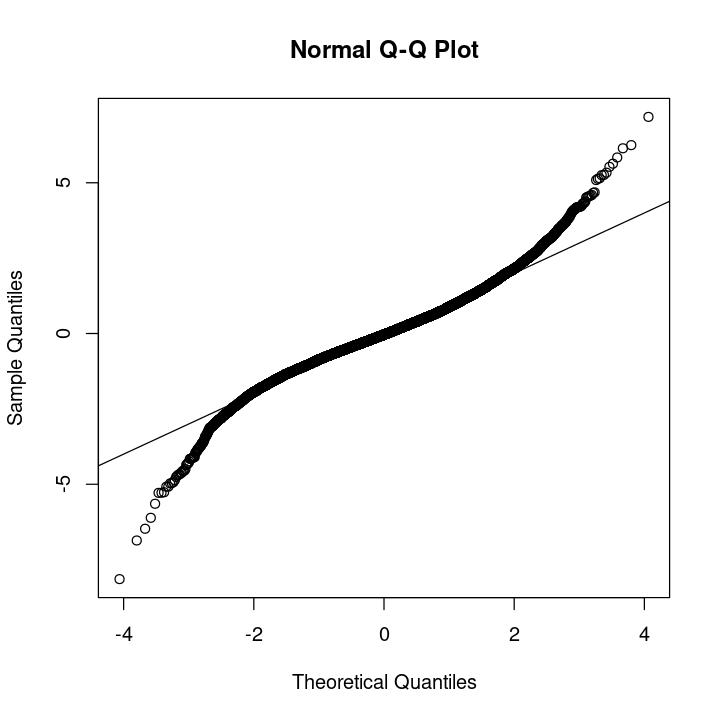

In [108]:
options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(m01, type= "pearson")))
qqline(ans$x, probs = c(0.25, 0.75))


In [109]:
# Get a sense of the parameter distributions.

m01.sim <- sim(m01, n.sims=3000)


In [110]:
sigma.m01.sim <- sigma.hat(m01.sim)
str(sigma.m01.sim)


 num [1:3000] 0.469 0.469 0.465 0.47 0.467 ...


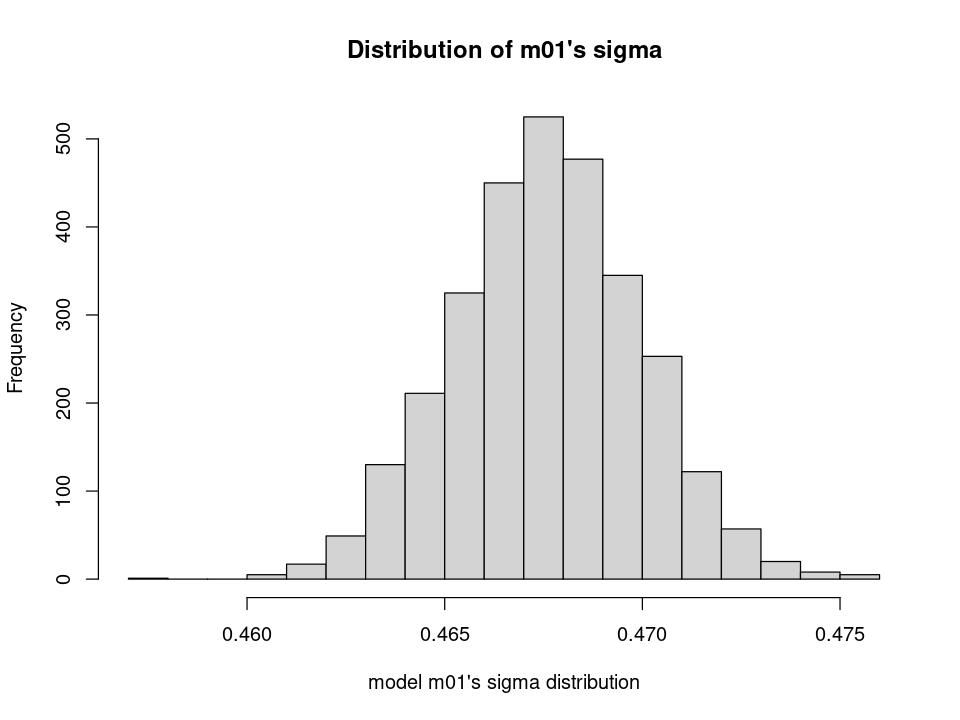

In [111]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(sigma.m01.sim, breaks=20, main="Distribution of m01's sigma",
     xlab="model m01's sigma distribution")


In [ ]:
# sigma.hat is small because of the power transformation
# on the response variable.


### Gibbs sampler for imputing censored median_house_values

In [5]:
# Because of the transformation on the response variable,
# and the correspondingly low sigma, we need to transform
# our limits.

cap <- 500000
response_var_power <- 0.18
C <- cap^response_var_power
C_upper <- (1.68*cap)^response_var_power

censored <- (dat$median_house_value)^response_var_power >= C

# Create some crude starting values.
n.censored <- sum(censored)
z <- ifelse(censored, NA, (dat$median_house_value)^response_var_power)
z[censored] <- runif(n.censored, C, C_upper)


In [6]:
length(censored)
n.censored


[1] 20603

[1] 990

In [7]:
summary(z[censored])


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   10.6    10.9    11.2    11.1    11.4    11.7 

In [9]:
# See p.406 (Section 18.5) of Gelman and Hill's book.

# Fit a regression using the crude starting values of z.

m01_tst <- lm(z ~ 
              
           I(median_income^0.77) +
           I(long_transf^-0.5) +
           I(long_transf^-1) +
           I(long_transf^-1.5) +
           latitude +
           I(latitude^2) +
           I(latitude^3) + 
           I(latitude^4) +
           pop_per_hh +
           I(pop_per_hh^2) +
           I(housing_median_age^0.15) +
           HHdens_ln +
           HHdens_ln:long_transf +
           HHdens_ln:median_income +
           HHdens_ln:housing_median_age:median_income,
                  
           data= dat)    

# Obtain a sample draw of the model coefficients and of
# parameter sigma.
sim.1 <- sim(m01_tst, n.sims=1)


In [10]:
beta <- coef(sim.1)
dim(beta)
colnames(beta)


[1]  1 16

[1] "(Intercept)"                               
 [2] "I(median_income^0.77)"                     
 [3] "I(long_transf^-0.5)"                       
 [4] "I(long_transf^-1)"                         
 [5] "I(long_transf^-1.5)"                       
 [6] "latitude"                                  
 [7] "I(latitude^2)"                             
 [8] "I(latitude^3)"                             
 [9] "I(latitude^4)"                             
[10] "pop_per_hh"                                
[11] "I(pop_per_hh^2)"                           
[12] "I(housing_median_age^0.15)"                
[13] "HHdens_ln"                                 
[14] "HHdens_ln:long_transf"                     
[15] "HHdens_ln:median_income"                   
[16] "HHdens_ln:median_income:housing_median_age"

In [11]:
# Function to draw from a constrained normal distribution.

rnorm.trunc03 <- function(n, mu, sigma, lo=-Inf, hi=Inf) {
    
    # We need each mu to be >= C.  Otherwise the return 
    # value will be Inf.
    mu02 <- ifelse(mu <= C, (cap + 100)^response_var_power, mu)
    
    p.lo <- pnorm(lo, mu02, sigma)
    p.hi <- pnorm(hi, mu02, sigma)
    u <- runif(n, p.lo, p.hi)
    return(qnorm(u, mu02, sigma))
}


In [12]:
# Create matrix X for the terms in our model.

X <- dat

X$median_income <- (X$median_income)^0.77

X$lat2 <- (X$latitude)^2
X$lat3 <- (X$latitude)^3
X$lat4 <- (X$latitude)^4

X$long_1 <- (X$long_transf)^-0.5
X$long_2 <- (X$long_transf)^-1
X$long_3 <- (X$long_transf)^-1.5

X$pphh1 <-  X$pop_per_hh
X$pphh2 <- (X$pop_per_hh)^2

X$housing_median_age <- (X$housing_median_age)^0.15

X$HHdens_by_long <- X$HHdens_ln * X$long_transf
X$HHdens_by_income <- X$HHdens_ln * X$median_income
X$HHdens_3way <- X$HHdens_ln * X$median_income * X$housing_median_age



X <- X[, c("median_income","long_1","long_2","long_3","latitude","lat2",
           "lat3","lat4","pphh1","pphh2", "housing_median_age",
           "HHdens_ln", "HHdens_by_long","HHdens_by_income",
           "HHdens_3way")]
intercept <- rep(1, nrow(dat))

init.colnames <- colnames(X)

X <- as.data.frame(cbind(intercept, X), col.names=c("intercept", init.colnames),
                   row.names=rownames(dat))
dim(X)
colnames(X)


[1] 20603    16

[1] "intercept"          "median_income"      "long_1"            
 [4] "long_2"             "long_3"             "latitude"          
 [7] "lat2"               "lat3"               "lat4"              
[10] "pphh1"              "pphh2"              "housing_median_age"
[13] "HHdens_ln"          "HHdens_by_long"     "HHdens_by_income"  
[16] "HHdens_3way"

In [14]:
# Here are means for 6 different normal
# distributions.

means <- as.matrix(X) %*% t(beta)
length(means)
round(head(as.vector(means)^(1/response_var_power)))


[1] 20603

[1] 487225 542237 377700 304489 235164 245952

In [15]:
# All values should be between 500K and 840K

inv_pwr <- 1/response_var_power

z.old <- z[censored]
round(head(z.old)^inv_pwr)


[1] 691253 715833 591220 654524 522458 584975

In [16]:
# All values should be between 500K and 840K.
sigma <- sigma.hat(sim.1)
round(sigma, 4)

z.new <- rnorm.trunc03(n.censored, means[censored], sigma, lo=C, hi=C_upper)
round(head(as.vector(z.new)^inv_pwr))


[1] 0.5053

[1] 595130 657206 641615 746826 715478 781043

In [17]:
summary(z.new^inv_pwr)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 500421  562735  627294  643864  716224  848788 

In [125]:
# For the Gibbs sampler, the above is now put into
# a loop.  We first test with 100 iterations.

n <- nrow(dat)
n.chains <- 4
n.iter <- 2000

sims <- array(NA, c(n.iter, n.chains, 17 + n.censored))
dimnames(sims) <- list(NULL, NULL, c(colnames(X), "sigma", 
                                     paste("z[", (1:n)[censored],
                                           "]", sep="")))

start <- Sys.time()
for(m in 1:n.chains) {
    
    # acquire some initial values
    z[censored] <- runif(n.censored, C, C_upper)
    
    for(t in 1:n.iter) {
        
        m01.1 <- lm(z ~ 
                    
           I(median_income^0.77) +
           I(long_transf^-0.5) +
           I(long_transf^-1) +
           I(long_transf^-1.5) +
           latitude +
           I(latitude^2) +
           I(latitude^3) + 
           I(latitude^4) +
           pop_per_hh +
           I(pop_per_hh^2) +
           I(housing_median_age^0.15) +
           HHdens_ln +
           HHdens_ln:long_transf +
           HHdens_ln:median_income +
           HHdens_ln:housing_median_age:median_income,
                  
           data= dat)   
        
        sim.1 <- sim(m01.1, n.sims=1)
        beta <- coef(sim.1)
        sigma <- sigma.hat(sim.1)
        means <- as.matrix(X) %*% t(beta)
        z[censored] <- rnorm.trunc03(n.censored, means[censored], sigma, lo=C, hi=C_upper)
        stopifnot(sum(z[censored] < Inf) == n.censored)
        sims[t,m,] <- c(beta, sigma, z[censored])
    }
}

stop <- Sys.time()
round(stop - start, 2)
# Time difference of 4.49 minutes.


Time difference of 4.49 mins

In [ ]:
# Check for convergence.

sims.bugs <- R2OpenBUGS::as.bugs.array(sims, n.burnin=1000)
print(sims.bugs)

# The Rhat value for every parameter and every imputed
# value should be 1.0.


In [126]:
save(sims, file="/home/greg/Documents/stat/Geron_ML/datasets/housing/sims_raw_hhvals.RData")


In [29]:
load("/home/greg/Documents/stat/Geron_ML/datasets/housing/sims_raw_hhvals.RData")


In [30]:
# Drop the first 1000 iterations.

sims_adj <- sims[1001:2000, ,]
dim(sims_adj)


[1] 1000    4 1007

In [31]:
sims_adj.bugs <- R2OpenBUGS::as.bugs.array(sims_adj)
# print(sims_adj.bugs)


In [21]:
# Extract the means and stddevs for each of the censored records.

z_means <- sims_adj.bugs$mean$z
z_sds <- sims_adj.bugs$sd$z
round(head(z_means), 2); round(head(z_sds), 2)


[1] 10.97 10.97 10.98 10.99 10.98 11.23

[1] 0.26 0.25 0.26 0.26 0.26 0.28

In [22]:
summary(z_means)
summary(z_sds)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   11.0    11.0    11.0    11.1    11.1    11.6 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.112   0.256   0.258   0.259   0.268   0.289 

In [23]:
summary(round(z_means^inv_pwr))


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 598750  602703  604117  631143  646072  804975 

In [24]:
# Average estimate of the sd.

(sd_estimate <- round((11 + 0.26)^inv_pwr) - round(11^inv_pwr))
# 84,572


[1] 84572

In [25]:
# Here is a more accurate summary for the stddevs.

ans <- round((z_means + z_sds)^inv_pwr) - round(z_means^inv_pwr)
summary(ans)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  44307   82382   83402   86320   91259  101305 

In [ ]:
### COMMENTS:

# Based on the work in Appendix B, I expect the mean for the
# censored records to be about 610K if the upper limit for
# median house value is 840K.


In [26]:
# Get some predictions, using rnorm.trunc03.

set.seed(1933)
z_preds <- round(rnorm.trunc03(n.censored, z_means, z_sds, lo=C, hi=C_upper), 5)
z_preds <- round(z_preds^inv_pwr)
summary(z_preds)

# Notice that the mean is at 640.5K.


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 501582  579400  629716  640532  695060  849573 

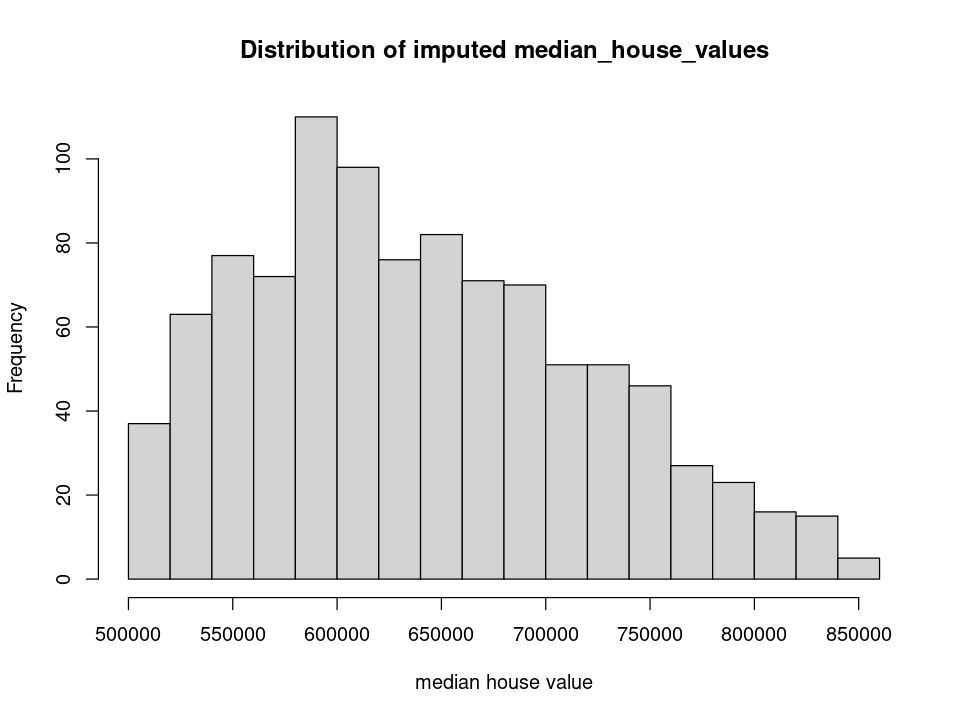

In [27]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(z_preds, breaks=14, main="Distribution of imputed median_house_values",
     xlab="median house value")


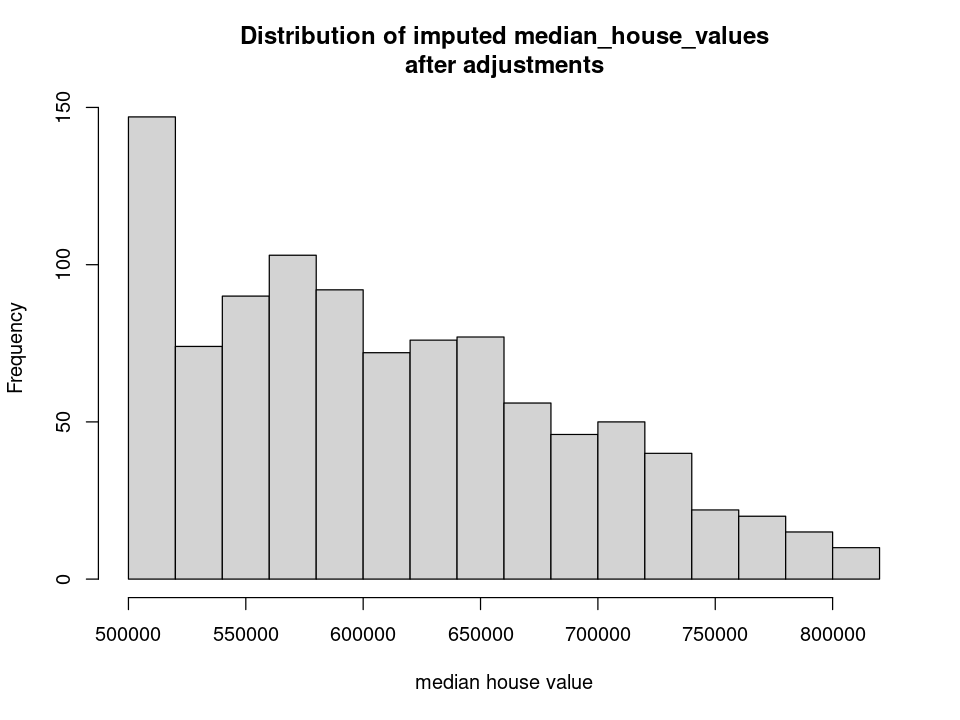

In [28]:
# Adjust the predictions based on what we learn in 
# Appendix B and what is noted in the above comment.

z_preds <- z_preds - 32000
preds_adj <- ifelse(z_preds < 500000, 500000, z_preds)

options(repr.plot.width= 8, repr.plot.height= 6)

hist(preds_adj, breaks=14, main="Distribution of imputed median_house_values
after adjustments",
     xlab="median house value")


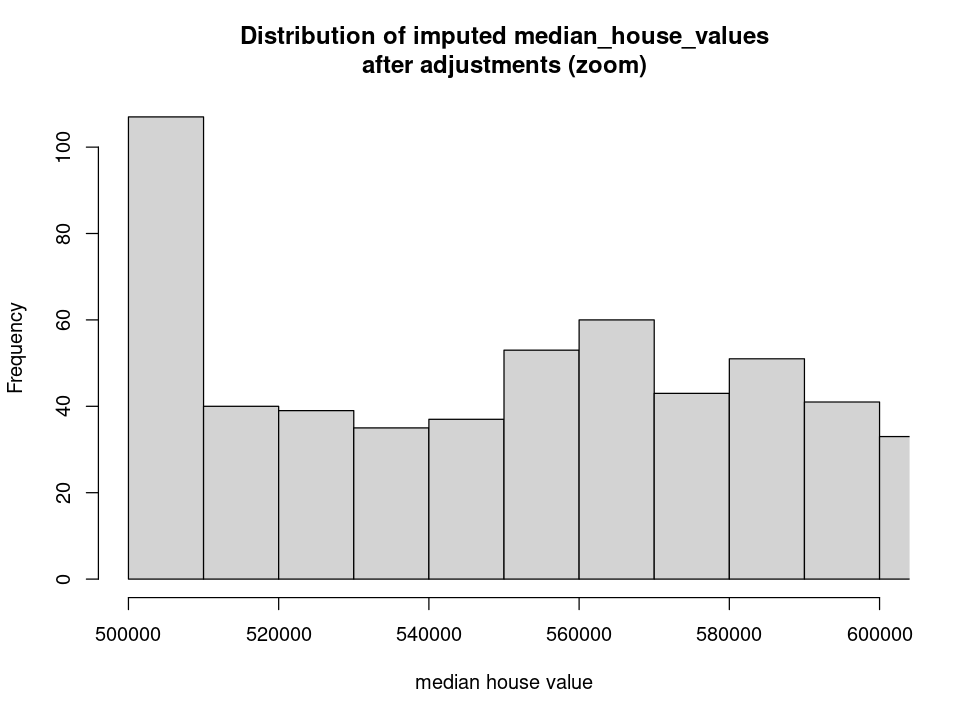

In [29]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(preds_adj, breaks=40, 
     main="Distribution of imputed median_house_values
after adjustments (zoom)", xlim= c(500000, 600000),
     xlab="median house value")


In [30]:
summary(preds_adj)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 500000  547400  597716  609561  663060  817573 

In [ ]:
### COMMENTS:

# As with the imputation of housing_median_age values,
# we do not want there to be a sudden drop in the number
# of districts as median_house_value increases from 500K to 
# 510K; we expect the drop, if there is one, to be more gradual; 

# The solution is to correct the z_means before calling rnorm.trunc03.
# We want to shift the z_means over by the same amount.  
# rnorm.trunc03 can then correct the means that are below C.


In [31]:
# The following provides us with a start.  The 609K value
# used here will need to be adjusted once we see the truncated
# output from rnorm.trunc03.

(z_means_bar <- mean(z_means))

z_means_adj <- z_means - (z_means_bar - 609000^response_var_power)
summary(z_means_adj)
round(mean(z_means_adj)^inv_pwr)


[1] 11.063

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   10.9    10.9    10.9    11.0    11.0    11.5 

[1] 609000

In [32]:
# Get new predictions.

set.seed(1933)
z_preds <- round(rnorm.trunc03(n.censored, z_means_adj, z_sds, lo=C, hi=C_upper), 5)
z_preds <- round(z_preds^inv_pwr)
summary(z_preds)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 501086  565854  612752  625431  675770  849209 

In [33]:
C_upper


[1] 11.676

In [36]:
# Make another correction.  Also adjust C_upper.

C_upper <- 11.65

z_means_adj <- z_means - (z_means_bar - 585000^response_var_power)

set.seed(1933)
z_preds <- round(rnorm.trunc03(n.censored, z_means_adj, z_sds, lo=C, hi=C_upper), 5)
z_preds <- round(z_preds^inv_pwr)
summary(z_preds)
# The mean is now at 608.5K.


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 500735  552602  593890  608521  654246  838247 

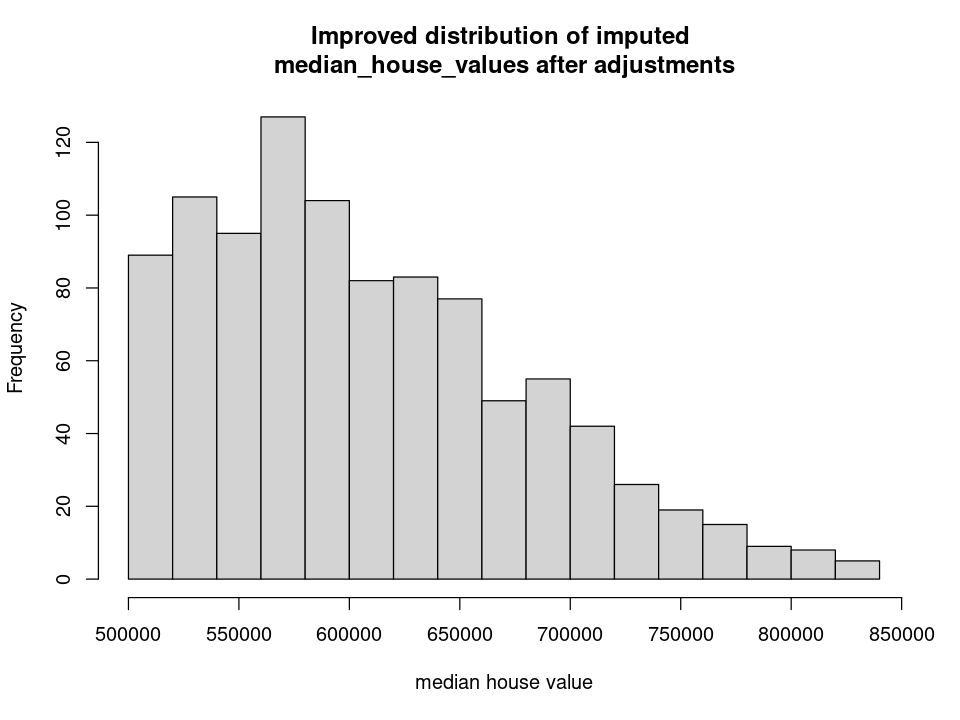

In [37]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(z_preds, breaks=20, main="Improved distribution of imputed 
median_house_values after adjustments",
     xlab="median house value")


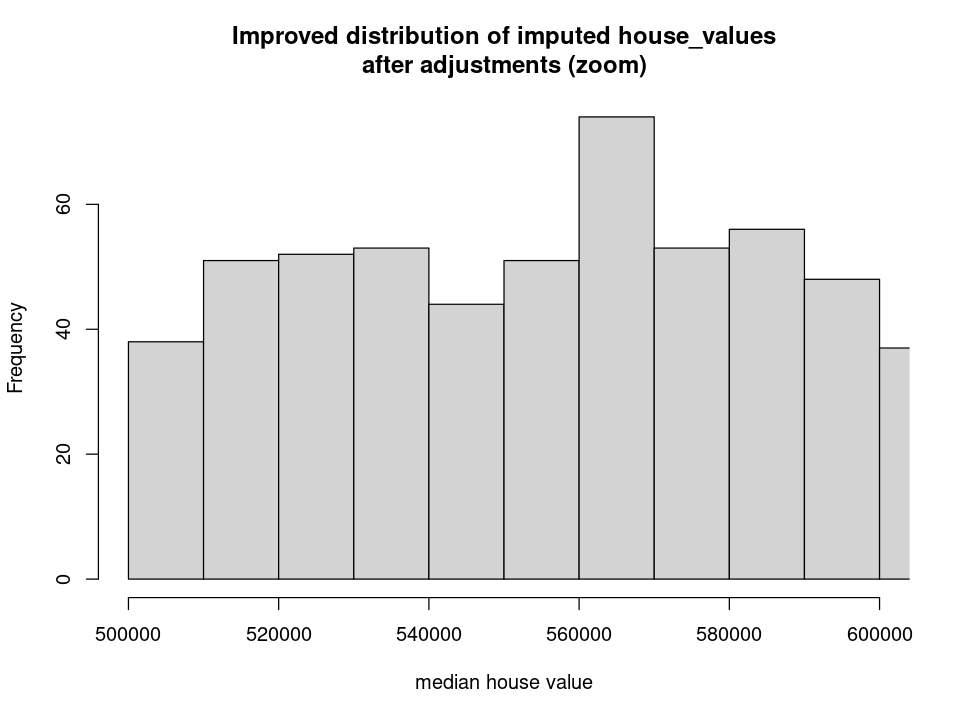

In [38]:
# We have eliminated the sharp drop-off of districts after
# the 500K value.

options(repr.plot.width= 8, repr.plot.height= 6)

hist(z_preds, breaks=40, 
     main="Improved distribution of imputed house_values
after adjustments (zoom)", xlim= c(500000, 600000),
     xlab="median house value")


In [39]:
# Assign imputed values.

newdat <- dat
newdat$median_house_value[censored] <- z_preds
summary(newdat$median_house_value)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  14999  119600  179800  212123  264950  838247 

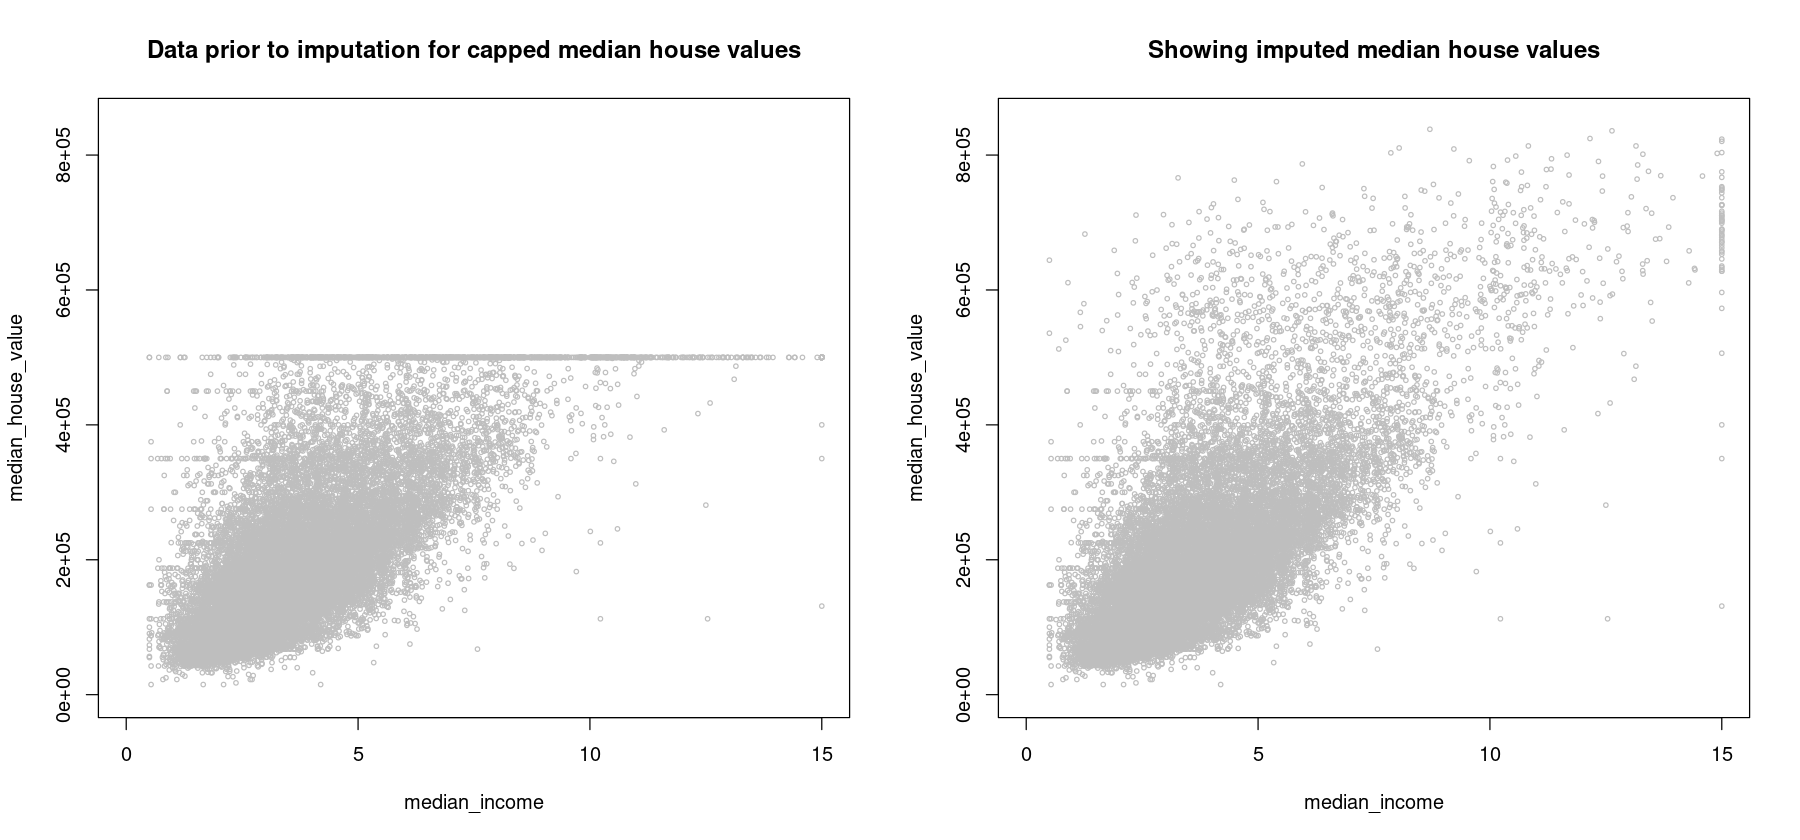

In [40]:
# Plot both before and after.

options(repr.plot.width= 15, repr.plot.height= 7)

mat <- t(as.matrix(c(1,2)))
layout(mat, widths = rep.int(20, ncol(mat)),
       heights = rep.int(7, nrow(mat)), respect = FALSE)

# layout.show(n = 2)

# plot the "before" scatter
plot(dat$median_income, dat$median_house_value, type= "p", pch=1, cex=0.5, col="grey",
     xlab= "median_income", ylab= "median_house_value", ylim= c(0, 0.85e06), xlim= c(0, 15),
     main= "Data prior to imputation for capped median house values")


# plot the newly predicted values
plot(newdat$median_income, newdat$median_house_value, type= "p", pch=1, cex=0.5, col="grey",
     xlab= "median_income", ylab= "median_house_value", ylim= c(0, 0.85e06), xlim= c(0, 15),
     main= "Showing imputed median house values")


### Save to disk

In [41]:
# This step is now in Appendix B.

# write.csv(newdat,
#           file="/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v04.csv",
#           row.names=TRUE)


In [42]:
rm(newdat)


### Check new coefficients for model m01 against Gibbs sampler estimates

In [3]:
dat <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v04.csv",
                header=TRUE, row.names=1,
                colClasses= c("character", rep("numeric", 9), "character",
                              rep("numeric", 5)))
dim(dat)


[1] 20603    15

In [5]:
# Check that we have imputed values for median_house_value.

summary(dat$median_house_value)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  14999  119600  179800  212225  264950  781010 

In [17]:
# m02 is m01, but with the imputed values for median_house_value.

# The power on the response variable changes significantly: from
# 0.18 to 0.09.  Also, the power on median_income changes from
# 0.77 to 0.82.

# These changes are needed so that the model has constant variance
# and linearity with respect to the fitted values.

m02 <- lm(I(median_house_value^0.09) ~ 
          
           I(median_income^0.82) +
           I(long_transf^-0.5) +
           I(long_transf^-1) +
           I(long_transf^-1.5) +
           latitude +
           I(latitude^2) +
           I(latitude^3) + 
           I(latitude^4) +
           pop_per_hh +
           I(pop_per_hh^2) +
           I(housing_median_age^0.15) +
           HHdens_ln +
           HHdens_ln:long_transf +
           HHdens_ln:median_income +
           HHdens_ln:housing_median_age:median_income,
                  
           data= dat)   
          
m02.summary <- summary(m02)
m02.summary[[1]] <- ""; round(m02.summary$adj.r.squared, 3)


[1] 0.736

In [18]:
ncvTest(m02)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.052471, Df = 1, p = 0.819

In [19]:
residualPlots(m02, plot= FALSE)


                           Test stat Pr(>|Test stat|)
I(median_income^0.82)         -11.00           <2e-16
I(long_transf^-0.5)             1.99            0.047
I(long_transf^-1)              10.81           <2e-16
I(long_transf^-1.5)            11.27           <2e-16
latitude                       -1.87            0.061
I(latitude^2)                  -0.58            0.560
I(latitude^3)                  33.48           <2e-16
I(latitude^4)                  33.46           <2e-16
pop_per_hh                     -0.89            0.375
I(pop_per_hh^2)               -13.70           <2e-16
I(housing_median_age^0.15)     -0.38            0.702
HHdens_ln                      11.37           <2e-16
Tukey test                     -0.02            0.983


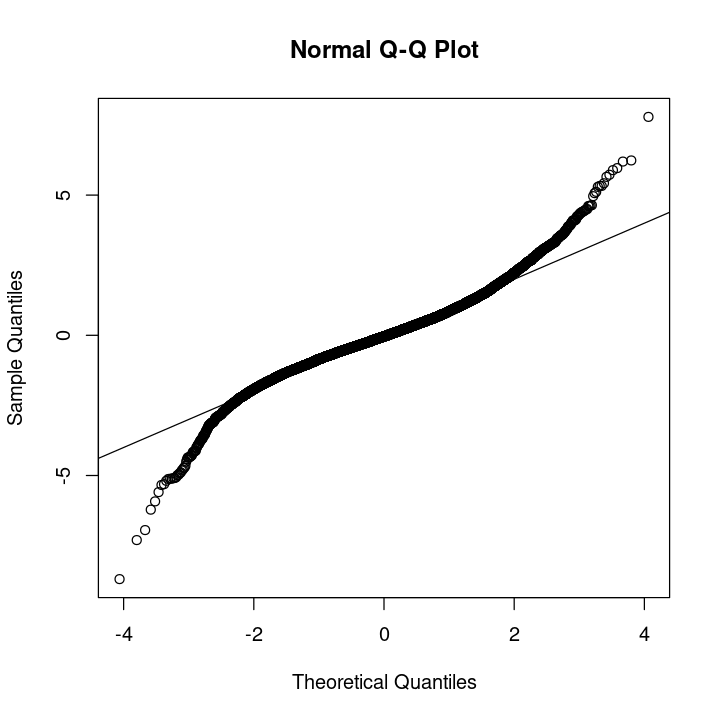

In [20]:
options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(m02, type= "pearson")))
qqline(ans$x, probs = c(0.25, 0.75))


In [ ]:
### COMMENTS:

# The significant change made to the power transformation
# of the response variable of model m02 means that we cannot
# run the coefficient test against the Gibbs sampler output.

# We can run the test on a model with the exact same power
# transformations as m01, although it is not a model we are
# interested in.  But such a check would allow us to see
# whether the change of the mean (from 640K to 611K) is 
# consistent with the Gibbs sampler output.


In [ ]:
sim_means <- unlist(sims_adj.bugs$mean[1:17])
sim_sds <- unlist(sims_adj.bugs$sd[1:17])
round(head(sim_means), 2); round(head(sim_sds), 2)
round(tail(sim_means), 2)


In [34]:
m03 <- lm(I(median_house_value^0.18) ~ 
          
           I(median_income^0.77) +
           I(long_transf^-0.5) +
           I(long_transf^-1) +
           I(long_transf^-1.5) +
           latitude +
           I(latitude^2) +
           I(latitude^3) + 
           I(latitude^4) +
           pop_per_hh +
           I(pop_per_hh^2) +
           I(housing_median_age^0.15) +
           HHdens_ln +
           HHdens_ln:long_transf +
           HHdens_ln:median_income +
           HHdens_ln:housing_median_age:median_income,
                  
           data= dat) 
          
m03.summary <- summary(m03)
m03.summary[[1]] <- ""; round(m03.summary$adj.r.squared, 3)


[1] 0.736

In [36]:
# tol_1 parameter set to 0.5.  tol_2 at default value of 1.

coef_ests <- m03.summary$coefficients[, 1]
coef_ses <- m03.summary$coefficients[, 2]

ans <- check_coeffs(coef_ests, coef_ses, sim_means, sim_sds, tol_1=0.5)
print(ans[ans==FALSE])

# So within a tolerance of 0.5 standard deviation, all of the m03 model 
# estimates are consistent with the Gibbs sampler output.  This means 
# that we have plausible imputed values for median_house_value and 
# that enforcing a mean of 611K on the imputed values did not cause 
# them to be outside of the inferential uncertainty associated with 
# model m01.


named logical(0)


# Section 3: Create training and test sets using stratified sampling

Because median income is such a strong predictor of median house prices (its linear correlation with log(median_house_value) is over 65%), we want to use stratified sampling relative to this variable when creating the training and test sets.  This ensures that the training set is representative of the larger population (i.e., the data to which our models will be applied were we to put a model into production) with respect to the variable that likely matters most for the purpose of making good predictions. 

Following Geron's lead, we divide median income by 1.5 in order to reduce the number of income categories that we have to work with.  The max value for median_income is 15.

80 percent of the records will be used for the training set, the remainder for the test set.


In [29]:
dat <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v04.csv",
                header=TRUE, row.names=1,
                colClasses= c("character", rep("numeric", 9), "character",
                              rep("numeric", 5)))
dim(dat)
colnames(dat)


[1] 20603    15

[1] "longitude"          "latitude"           "housing_median_age"
 [4] "total_rooms"        "total_bedrooms"     "population"        
 [7] "households"         "median_income"      "median_house_value"
[10] "ocean_proximity"    "rooms_per_hh"       "bdrms_per_room"    
[13] "pop_per_hh"         "HHdens_ln"          "long_transf"

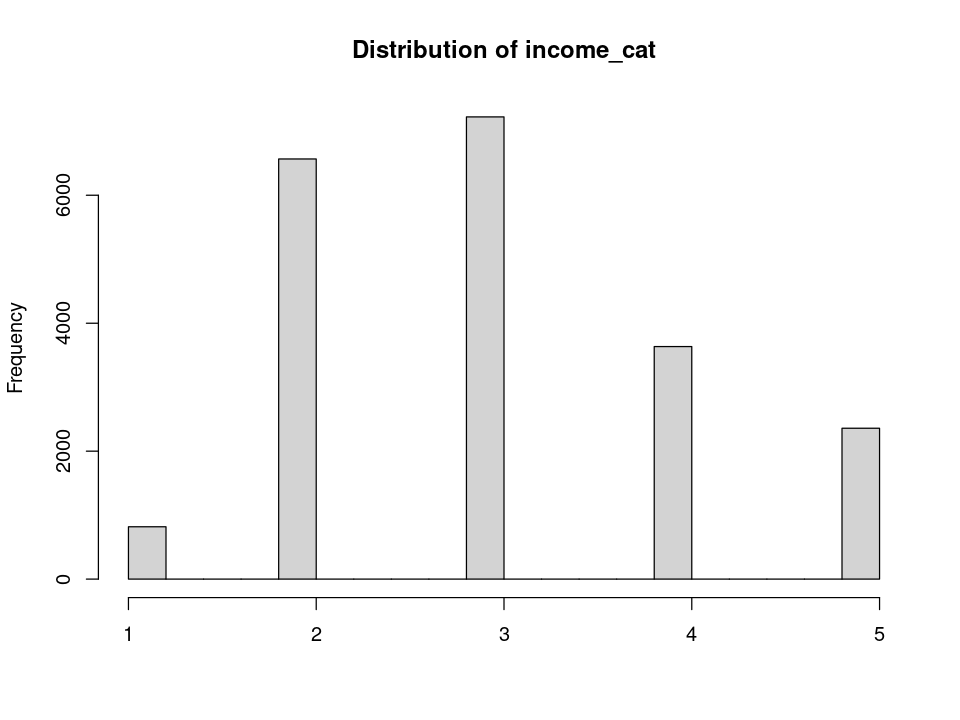

In [30]:
dat$income_cat <- ceiling(dat$median_income/ 1.5)

dat$income_cat <- ifelse(dat$income_cat > 5, 5, dat$income_cat)

options(repr.plot.width= 8, repr.plot.height= 6)

hist(dat$income_cat, main="Distribution of income_cat", xlab="")


In [31]:
ans <- table(as.factor(dat$income_cat))
counts <- as.numeric(ans)
percents <- 100 * round(counts/nrow(dat), 4)
names(percents) <- names(ans); print(percents)

# Percent of records in each income category:


    1     2     3     4     5 
 3.97 31.87 35.07 17.64 11.44 


In [32]:
# Shuffle dat.

set.seed(4321)
smp <- sample(rownames(dat), nrow(dat), replace=FALSE)
dat <- dat[smp,]
smp02 <- sample(rownames(dat), nrow(dat), replace=FALSE)
dat <- dat[smp02,]
rm(smp, smp02)


In [33]:
# Construct training and test sets.

n.train <- floor(0.8 * nrow(dat))
n.test <- nrow(dat) - n.train
percents02 <- percents/100

total_rows <- 0
train_rows <- c()

for(lev in names(ans)) {
    
    percent <- as.numeric(percents02[lev])
    ifelse(as.numeric(lev) < 5, n <- round(percent*n.train),
           n <- n.train - total_rows)
    total_rows <- total_rows + n
    set.seed(9871)
    smp <- sample(rownames(dat[which(dat$income_cat== as.numeric(lev)),]),
                  n, replace=FALSE)
    train_rows <- c(train_rows, smp)
}

length(train_rows)== n.train


[1] TRUE

In [34]:
train <- dat[train_rows,]
test <- dat[which(!(rownames(dat) %in% rownames(train))),]
(nrow(test) + nrow(train)) == nrow(dat)

round(table(as.factor(train$income_cat))/nrow(train), 3)
round(table(as.factor(test$income_cat))/nrow(test), 3)


[1] TRUE


    1     2     3     4     5 
0.040 0.319 0.351 0.176 0.115 


    1     2     3     4     5 
0.040 0.319 0.351 0.177 0.114 

### Save to disk

In [35]:
# Shuffle train.
set.seed(4321)
smp <- sample(rownames(train), nrow(train), replace=FALSE)
train <- train[smp,]

# Shuffle test.
set.seed(4321)
smp <- sample(rownames(test), nrow(test), replace=FALSE)
test <- test[smp,]


write.csv(train, file="/home/greg/Documents/stat/Geron_ML/datasets/housing/train_revised_27JUN2021.csv",
          row.names=TRUE)

write.csv(test, file="/home/greg/Documents/stat/Geron_ML/datasets/housing/test_revised_27JUN2021.csv",
          row.names=TRUE)

dim(train)
# 16482   16


[1] 16482    16

# Section 4: Explore the data and consider more models

In [36]:
rm(dat, test)


In [6]:
train <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/train_revised_27JUN2021.csv",
                header=TRUE, row.names=1,
                colClasses= c("character", rep("numeric", 9), "character",
                              rep("numeric", 5), "character"))
dim(train)
# 16,482    16

colnames(train)


[1] 16482    16

[1] "longitude"          "latitude"           "housing_median_age"
 [4] "total_rooms"        "total_bedrooms"     "population"        
 [7] "households"         "median_income"      "median_house_value"
[10] "ocean_proximity"    "rooms_per_hh"       "bdrms_per_room"    
[13] "pop_per_hh"         "HHdens_ln"          "long_transf"       
[16] "income_cat"

In [37]:
# Create a dataframe with the m02 predictors and their transformations.

smp <- sample(rownames(train), 7000, replace= FALSE)
df_plot <- train[smp, c("housing_median_age", "median_income", "HHdens_ln",
                        "latitude", "long_transf", "pop_per_hh")]
df_plot$housing_median_age <- df_plot$housing_median_age^0.15
df_plot$long_transf <- df_plot$long_transf^-1
df_plot$median_income <- df_plot$median_income^0.77


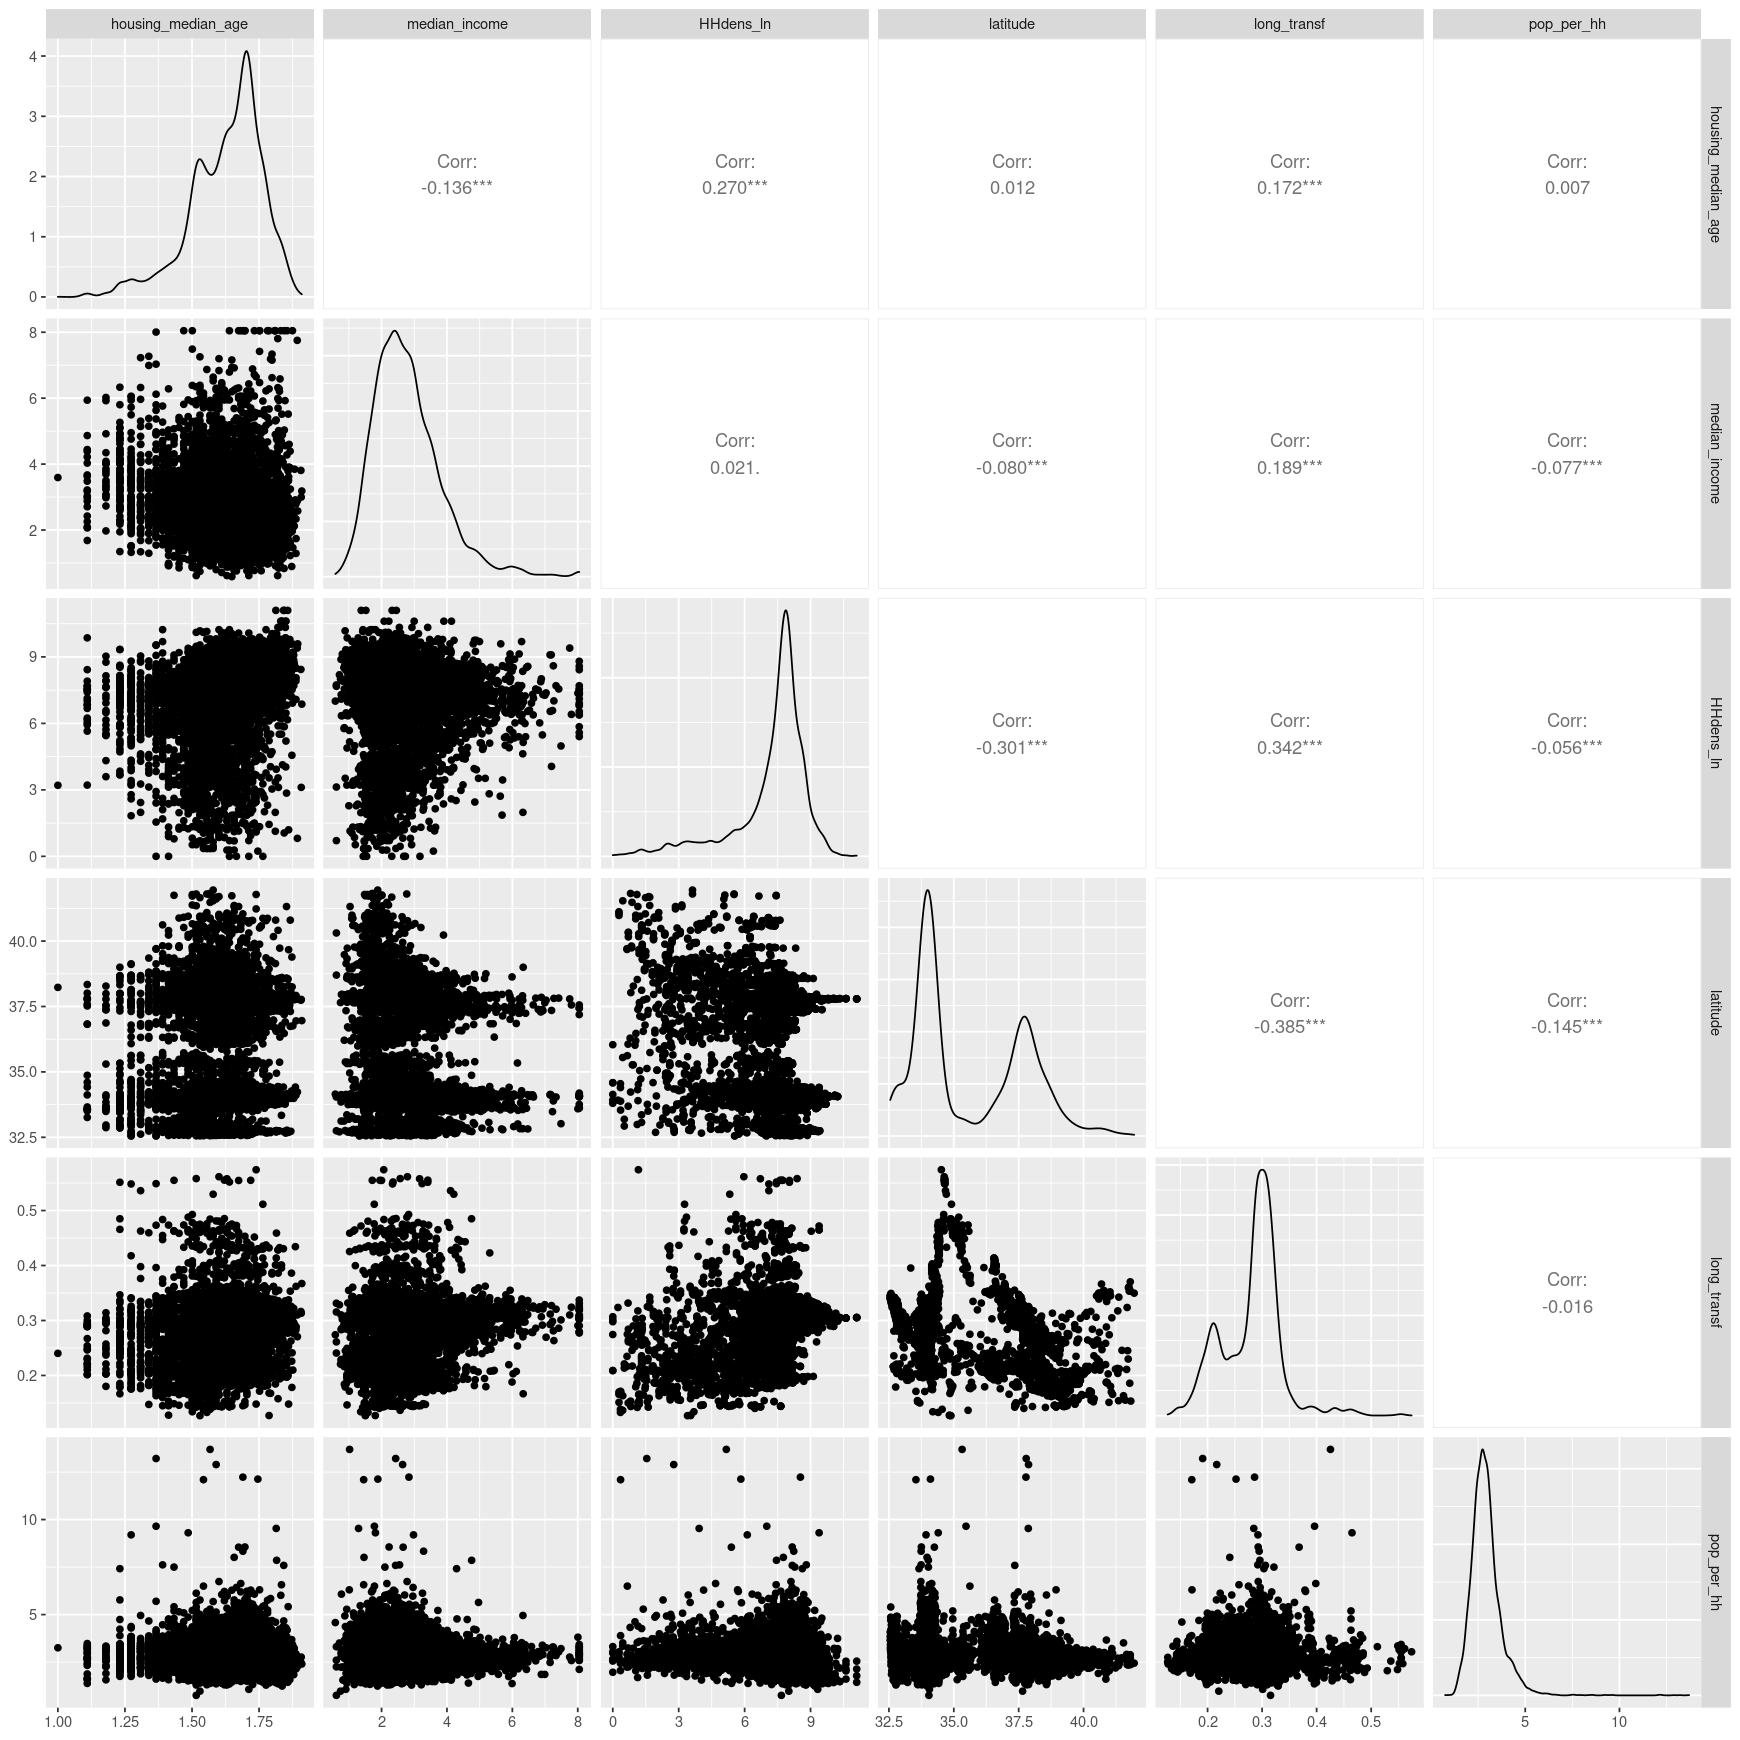

In [38]:
options(repr.plot.width= 14.5, repr.plot.height= 14.5)

p4 <- ggpairs(df_plot)
p4


In [70]:
# Look at a model that includes the ocean_proximity term.

# g02 is exactly like m02 except for the addition of 
# ocean_proximity and that it is constructed from 
# only the training set data.

g02 <- lm(I(median_house_value^0.077) ~ 
          
           I(median_income^0.81) +
           I(long_transf^-0.5) +
           I(long_transf^-1) +
           I(long_transf^-1.5) +
           latitude +
           I(latitude^2) +
           I(latitude^3) + 
           I(latitude^4) +
          
           ocean_proximity +
          
           pop_per_hh +
           I(pop_per_hh^2) +
           I(housing_median_age^0.15) +
           HHdens_ln +
           HHdens_ln:long_transf +
           HHdens_ln:median_income +
           HHdens_ln:housing_median_age:median_income,
                  
           data= train)  

g02.summary <- summary(g02)
g02.summary[[1]] <- ""; round(g02.summary$adj.r.squared, 3)


[1] 0.737

In [71]:
ncvTest(g02)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.8295, Df = 1, p = 0.362

In [72]:
residualPlots(g02, plot=FALSE)


                           Test stat Pr(>|Test stat|)
I(median_income^0.81)          -8.82          < 2e-16
I(long_transf^-0.5)            -0.97             0.33
I(long_transf^-1)               6.74          1.7e-11
I(long_transf^-1.5)             7.11          1.2e-12
latitude                        0.86             0.39
I(latitude^2)                   0.24             0.81
I(latitude^3)                  29.08          < 2e-16
I(latitude^4)                  29.08          < 2e-16
pop_per_hh                     -1.51             0.13
I(pop_per_hh^2)               -12.52          < 2e-16
I(housing_median_age^0.15)     -0.53             0.59
HHdens_ln                      10.44          < 2e-16
Tukey test                      0.03             0.97


In [ ]:
### COMMENT:

# Adding ocean_proximity to the model improves the R-sqrd by
# only two-tenths of one percent.  For our linear model, it
# may not be worth the trouble.  I will compare g02 with 
# the next model, g03, using rmse scores and cross-validation.


In [8]:
# Rename m02 to g03.  Model g03 is only on the training 
# set data.  Accordingly, it requires some further tuning.

response_var_power <- 0.098

g03 <- lm(I(median_house_value^response_var_power) ~ 
          
           I(median_income^0.831) +
           I(long_transf^-0.5) +
           I(long_transf^-1) +
           I(long_transf^-1.5) +
           latitude +
           I(latitude^2) +
           I(latitude^3) + 
           I(latitude^4) +
           pop_per_hh +
           I(pop_per_hh^2) +
           I(housing_median_age^0.15) +
           HHdens_ln +
           HHdens_ln:long_transf +
           HHdens_ln:median_income +
           HHdens_ln:housing_median_age:median_income,
                  
           data= train)  

g03.summary <- summary(g03)
g03.summary[[1]] <- ""; round(g03.summary$adj.r.squared, 3)


[1] 0.735

In [82]:
ncvTest(g03)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.029752, Df = 1, p = 0.863

In [83]:
residualPlots(g03, plot=FALSE)


                           Test stat Pr(>|Test stat|)
I(median_income^0.831)         -9.91           <2e-16
I(long_transf^-0.5)            -0.99             0.32
I(long_transf^-1)               9.85           <2e-16
I(long_transf^-1.5)            10.28           <2e-16
latitude                        1.17             0.24
I(latitude^2)                  -0.08             0.94
I(latitude^3)                  30.23           <2e-16
I(latitude^4)                  30.22           <2e-16
pop_per_hh                     -1.52             0.13
I(pop_per_hh^2)               -12.75           <2e-16
I(housing_median_age^0.15)     -0.62             0.54
HHdens_ln                      10.38           <2e-16
Tukey test                     -0.01             0.99


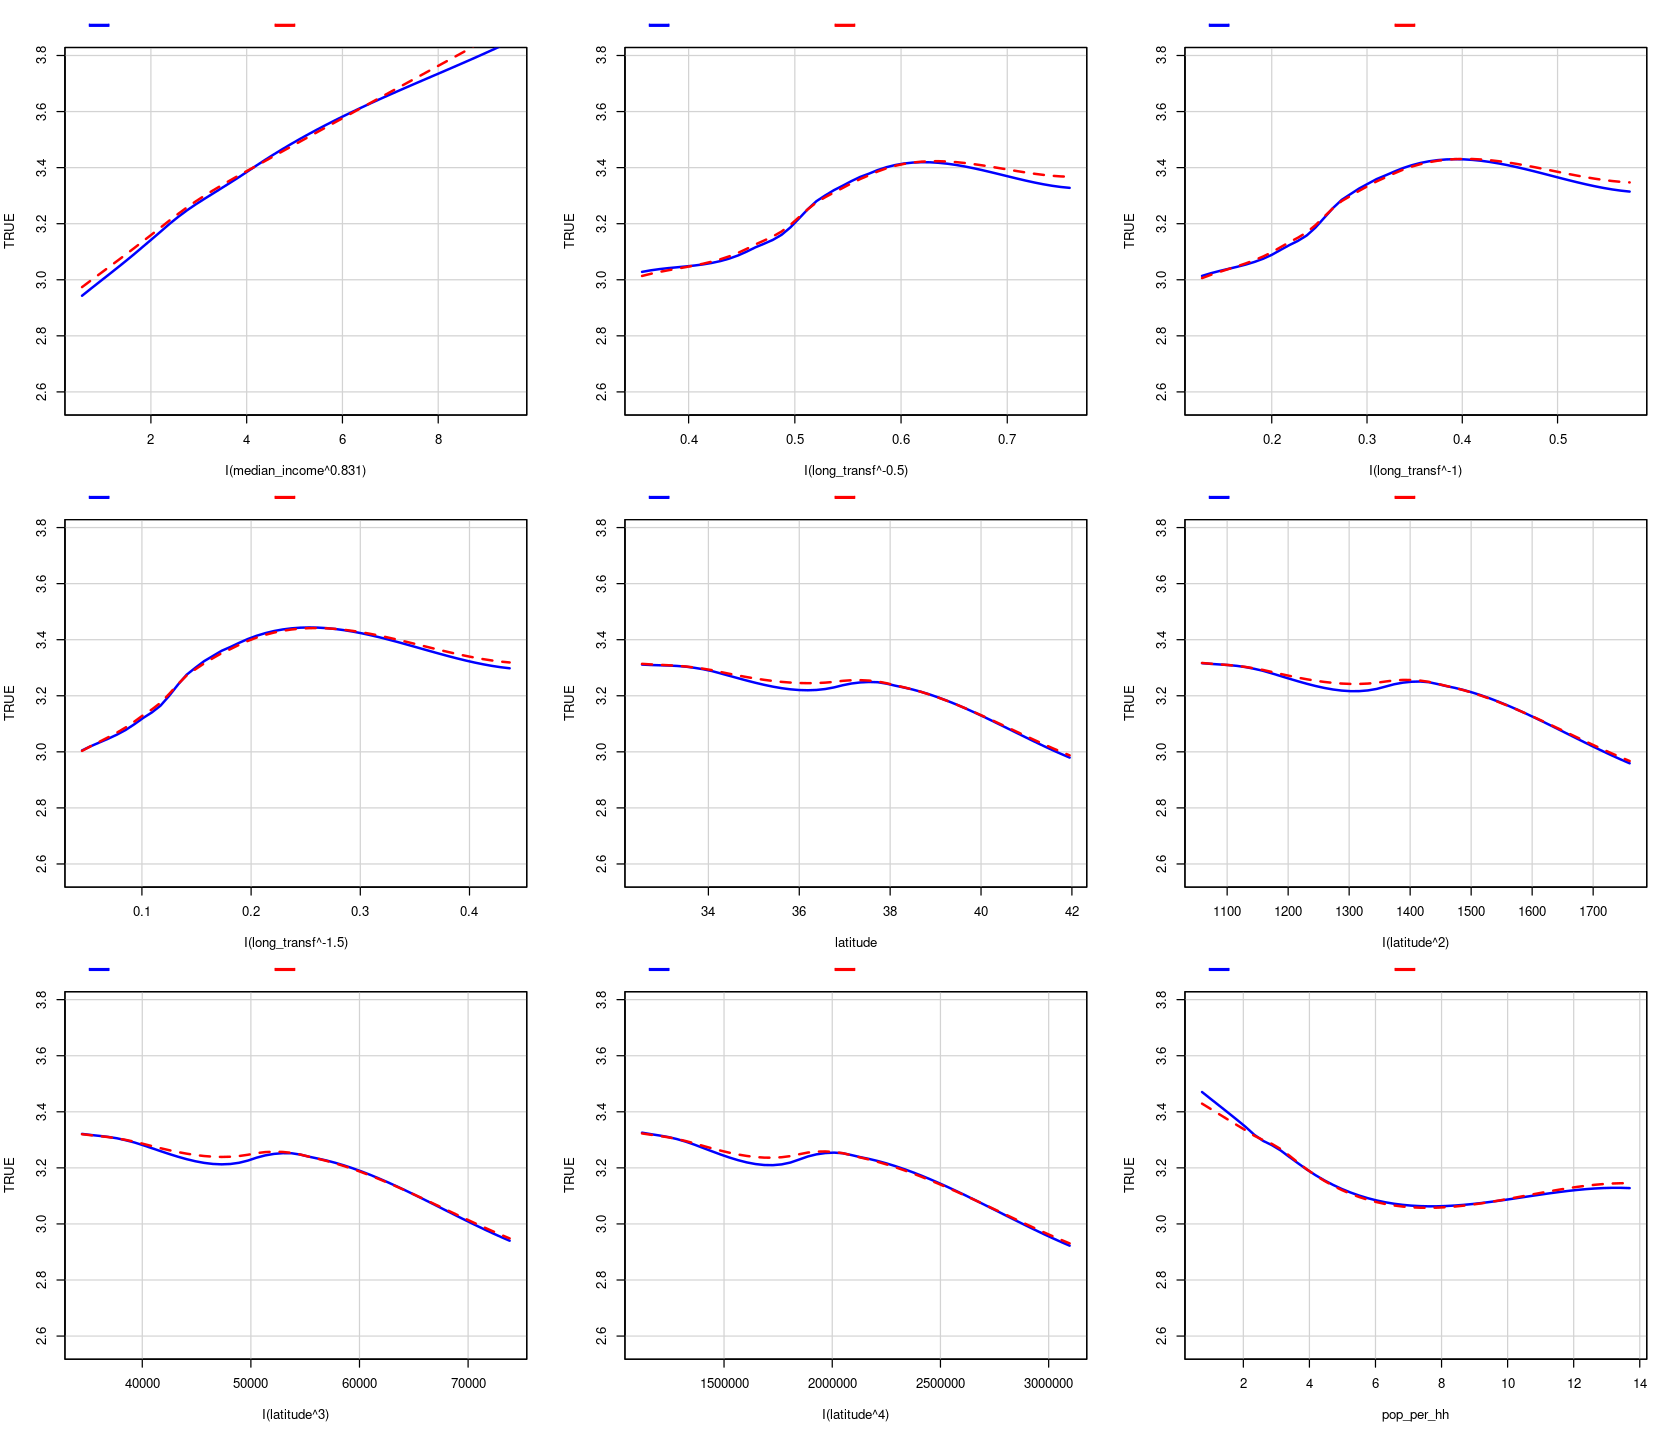

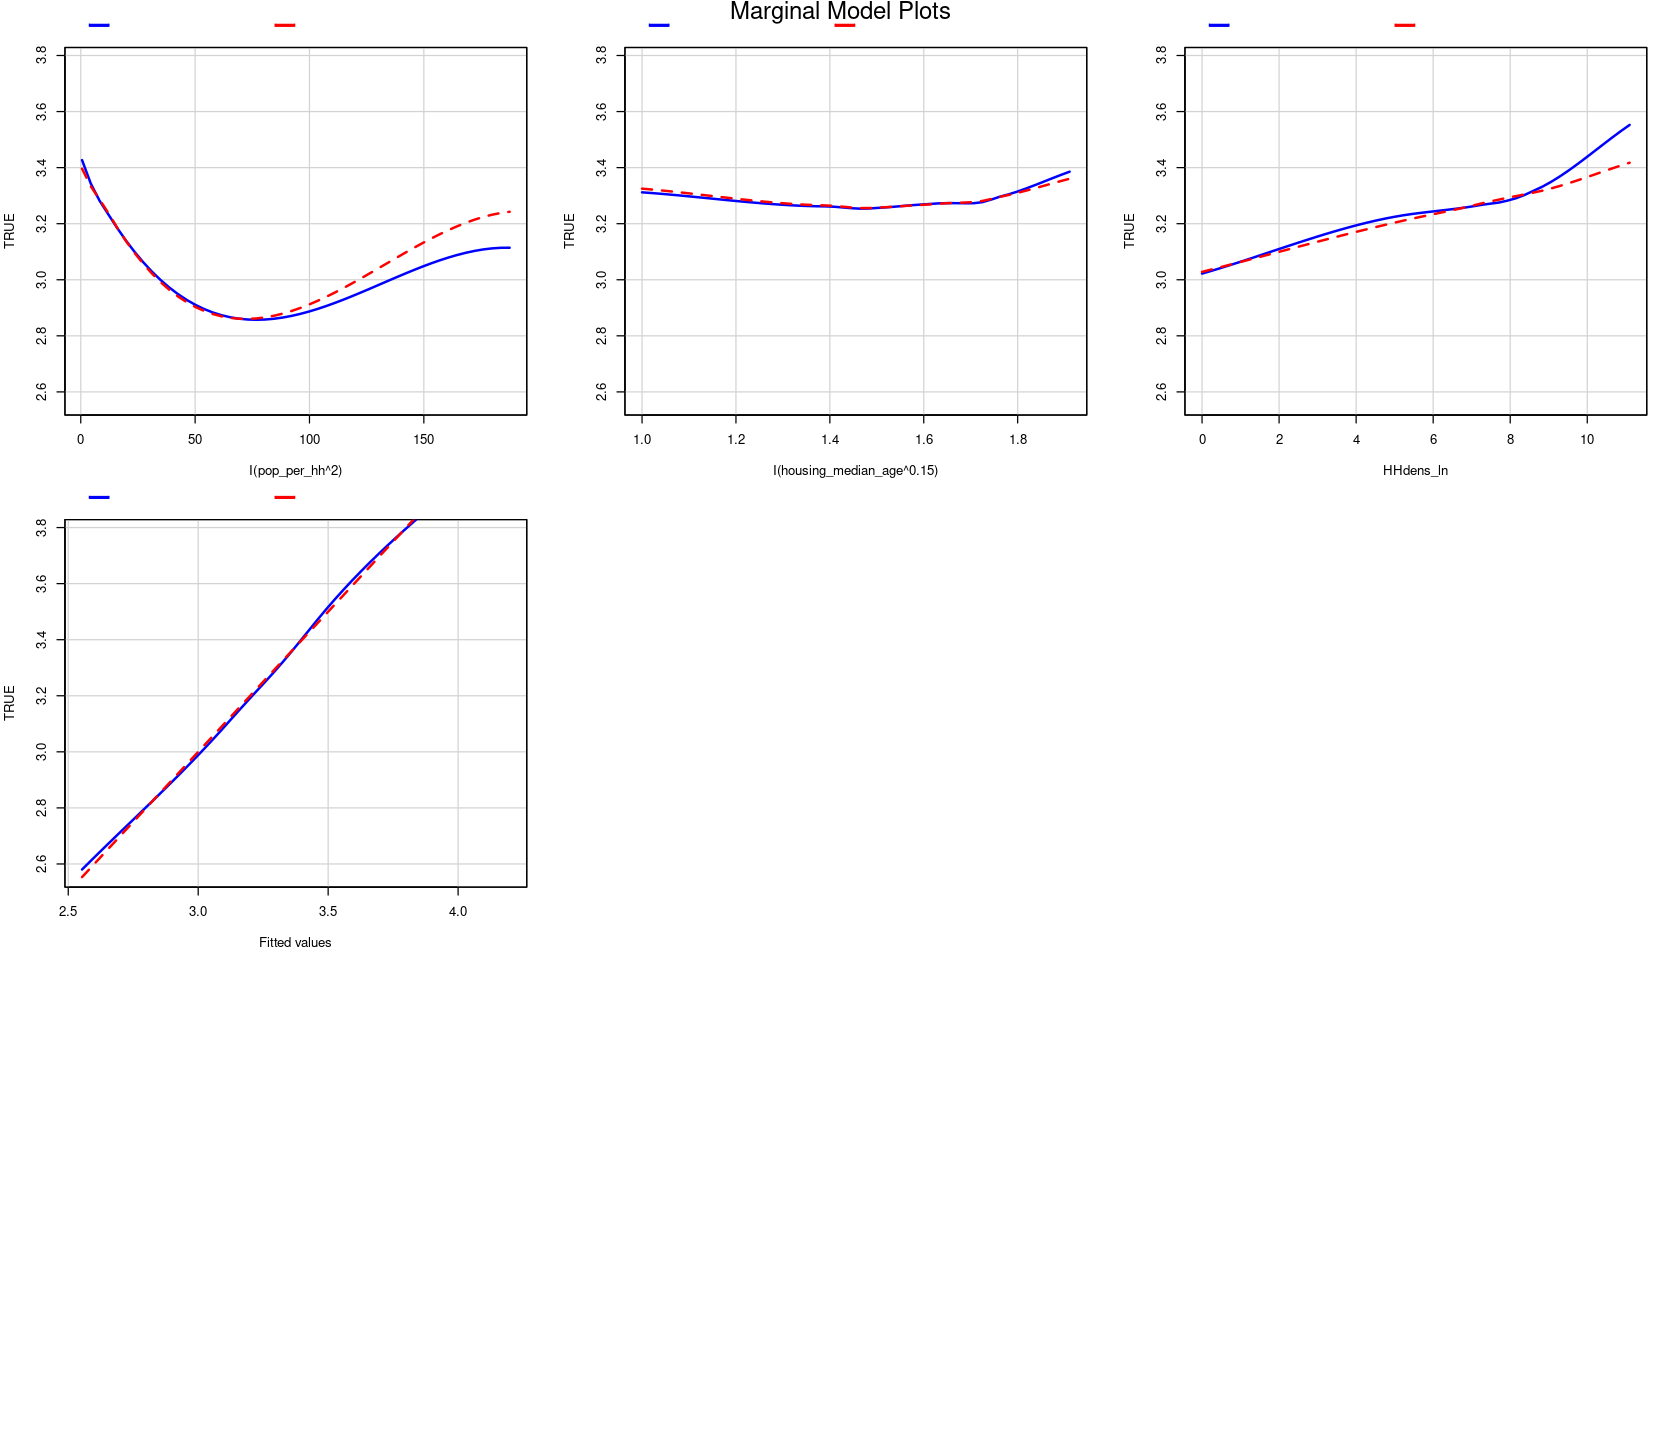

In [84]:
options(repr.plot.width= 14, repr.plot.height= 12)

# blue= data; red= model
suppressWarnings(mmps(g03, ~., pch=NA))


In [ ]:
### COMMENTS:

# g03 relies on only 6 predictors, all of which are numeric.
# The R-sqrd is 73.5%.  It has constant variance with
# respect to the fitted values, and it has linearity 
# with respect to the fitted values.  The marginal model
# plots look pretty good.


## Compute rmse on trainset for model g03

In [85]:
# rmse score on train set for g03.

response_var_power <- 0.098

predictions <- predict.lm(g03, newdata = train)
preds_transf <- predictions^(1/response_var_power)

print(round(sqrt((1/nrow(train)) * sum((as.numeric(preds_transf) - 
                                          train$median_house_value)^2))))
# 76,786


[1] 76786


## Compute g03 rmse on testset

In [10]:
testdat <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/test_revised_27JUN2021.csv",
                    header=TRUE, row.names=1,
                    colClasses= c("character", rep("numeric", 9), "character",
                                  rep("numeric", 5), "character"))
dim(testdat)
# 4121    16


[1] 4121   16

In [87]:
predictions <- predict.lm(g03, newdata = testdat)
preds_transf <- predictions^(1/response_var_power)

print(round(sqrt((1/nrow(testdat)) * sum((as.numeric(preds_transf) - 
                                          testdat$median_house_value)^2))))
# 75,709


[1] 75709


In [89]:
# Get rmse score on the testset when median_house_value < 500K.

newtest <- testdat[which(testdat$median_house_value < 500000),]
dim(newtest)
# 3924     16

predictions <- predict.lm(g03, newdata = newtest)
preds_transf <- predictions^(1/response_var_power)

print(round(sqrt((1/nrow(newtest)) * sum((as.numeric(preds_transf) - 
                                          newtest$median_house_value)^2))))
# 55,806


[1] 3924   16

[1] 55806


In [ ]:
### COMMENT:

# The average error increases by 20K once we include predictions
# for districts with a median_house_value >= 500K.  This large 
# delta illustrates how difficult it is to get accurate predictions
# for these districts.  Keep in mind that we have only a small 
# amount of data for this region of the response variable's range;
# only 4.5-5% of our trainset records are in this range.


In [12]:
# Get rmse score on the testset when median_house_value <= 150K.

newtest <- testdat[which(testdat$median_house_value <= 150000),]
dim(newtest)
# 1538     16

predictions <- predict.lm(g03, newdata = newtest)
preds_transf <- predictions^(1/response_var_power)

print(round(sqrt((1/nrow(newtest)) * sum((as.numeric(preds_transf) - 
                                          newtest$median_house_value)^2))))
# 38,397

# The error is much larger than I would have thought.


[1] 1538   16

[1] 38397


# Section 5: geospatial plot

The following plot is useful for thinking about the data we are working with.

Only the training set data is plotted.



                                    * * * * * 

In [ ]:
# See https://r-spatial.org/r/2018/10/25/ggplot2-sf.html.
# Many of the following packages have important dependencies.
# Linux users might do best installing the packages in
# pure R (e.g., do not use RStudio or JupyterNotebooks).

require(sf)
theme_set(theme_bw())
require(rnaturalearth)
require(rnaturalearthdata)
require(sp)
require(rgeos)
require(maps)
require(ggspatial)


In [174]:
# Load state maps data.

states <- suppressMessages(st_as_sf(map("state", plot = FALSE, fill = TRUE)))
head(states)


,ID,geom
,<chr>,<MULTIPOLYGON [°]>
1,alabama,MULTIPOLYGON (((-87.462 30....
2,arizona,MULTIPOLYGON (((-114.64 35....
3,arkansas,MULTIPOLYGON (((-94.051 33....
4,california,MULTIPOLYGON (((-120.01 42....
5,colorado,MULTIPOLYGON (((-102.06 40....
6,connecticut,MULTIPOLYGON (((-73.499 42....


In [23]:
CA <- states[which(states$ID == "california"),]
dim(CA)


[1] 1 2

In [29]:
# Map county boundaries.

counties <- st_as_sf(map("county", plot = FALSE, fill = TRUE))
counties <- subset(counties, grepl("california", counties$ID))


In [161]:
# Prepare data for plotting.

geodat <- train[, c("longitude","latitude","population","median_house_value")]
geodat$median_house_value <- round(geodat$median_house_value/1000)

y <- cut(geodat$median_house_value, breaks=c(15, 90, 180, 360, 800), 
         include.lowest=TRUE, right=FALSE, ordered_result=TRUE)
table(y)

geodat$hhval_discrete <- y



geodat$population <- round(geodat$population)

zz <- cut(geodat$population, breaks=c(2, 800, 2400, 40000), 
          include.lowest=TRUE, right=FALSE, ordered_result=TRUE,
          labels=c("< 800", "800-2400"," >= 2400"))
table(zz)

geodat$pop_discrete <- zz


y
  [15,90)  [90,180) [180,360) [360,800] 
     2085      6115      6372      1910 

zz
   < 800 800-2400  >= 2400 
    4246    10290     1946 

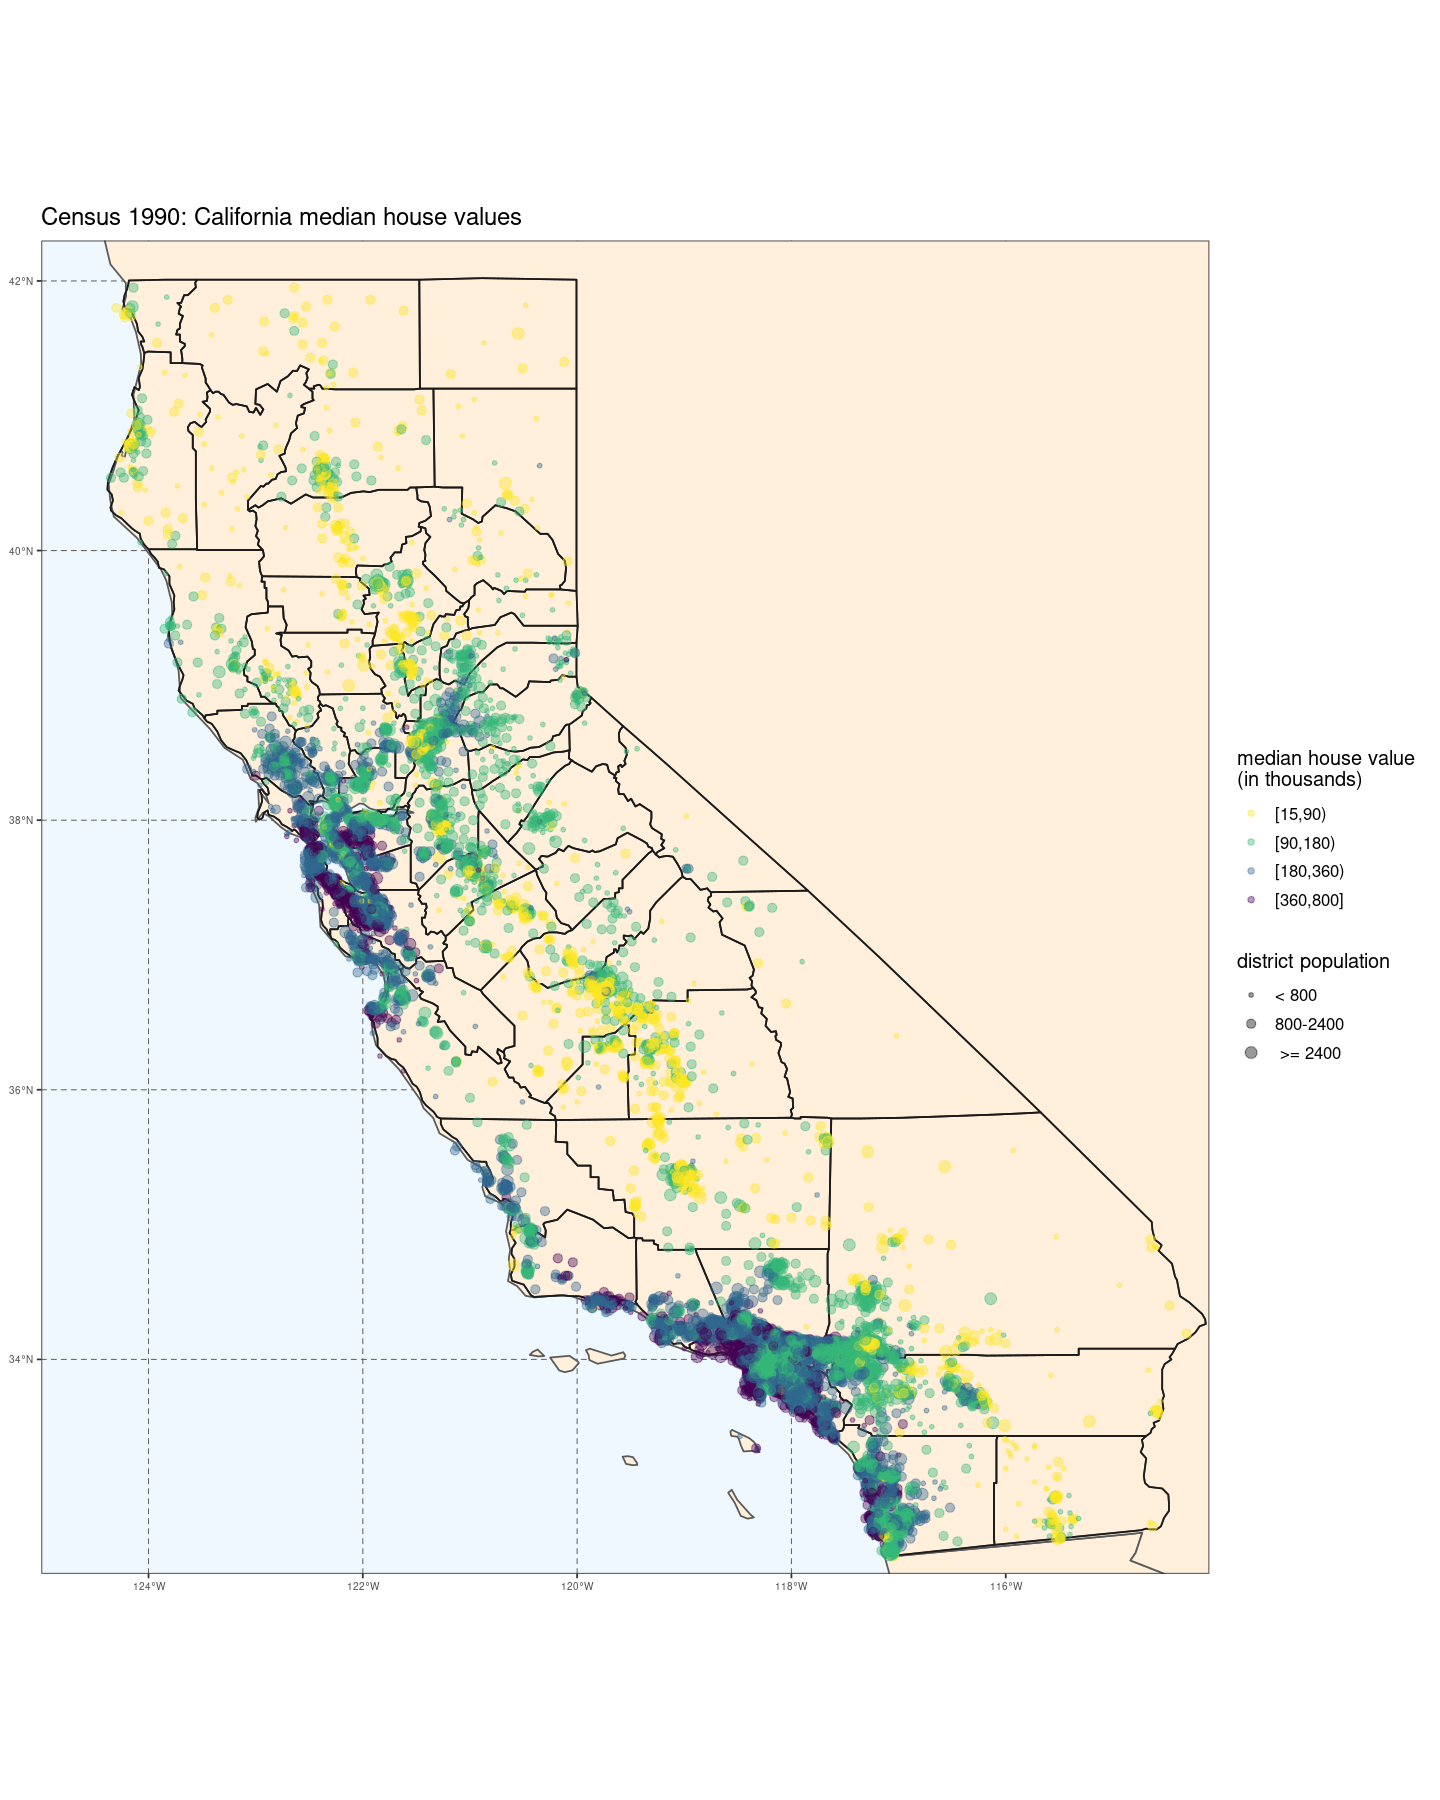

In [172]:
# The following plot is meant to be looked at in a pdf viewer.
# The saved pdf file is included in my CA_housing_analysis 
# repository.

options(repr.plot.width= 12, repr.plot.height= 15)

ggplot(data = world) +
    geom_sf(fill = "antiquewhite1") +
    geom_sf(data = CA, fill = NA) +
    geom_sf(data = counties, fill = NA, color = gray(.1)) +
    geom_point(data= geodat, mapping= aes(longitude, latitude,
                                          colour= hhval_discrete,
                                          size=pop_discrete), alpha=0.4) +
    suppressWarnings(scale_size_discrete(name="district population",
                                         range=c(1,3))) +
    scale_colour_viridis_d(alpha=0.7, direction=-1, name="median house value
(in thousands)") +
    coord_sf(xlim = c(-125.0, -114.1), ylim = c(32.41, 42.3), expand = FALSE) +
    ggtitle("Census 1990: California median house values") +
    theme(panel.grid.major = element_line(color = gray(0.4), linetype = "dashed", 
        size = 0.3), panel.background = element_rect(fill = "aliceblue")) +
    theme(axis.text= element_text(size = 6)) +
    theme(axis.title= element_blank()) +
    theme(title= element_text(size= 12)) +
    theme(legend.text= element_text(size=10)) +
    theme(legend.title=element_text(size=12))


In [173]:
ggsave("/home/greg/Documents/stat/github_repos/CA_housing/CA_housing_map_v01.pdf",
       device="pdf", scale=1, dpi=600, units="cm", width=18, height=36)


# Section 6: Comparative rmse score for model g03

We can get a much better score for comparing to the models of Part02 by averaging over many different samples of our testset data.


In [25]:
testdat <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/test_revised_27JUN2021.csv",
                    header=TRUE, row.names=1,
                    colClasses= c("character", rep("numeric", 9), "character",
                                  rep("numeric", 5), "character"))
dim(testdat)
# 4121    16


[1] 4121   16

In [26]:
# Function for obtaining a set of scores on the testset data
# using model g03.

response_var_power <- 0.098
n_rcds <- 1000

get_testdatScores_g03 <- function(seedv, dat) {
    
    seedv_len <- length(seedv)
    vout <- rep(NA, seedv_len)
    
    for(h in 1:seedv_len) {

        set.seed(seedv[h])
        # It is expected that dat is testdat, which has 4K rcds
        smp <- sample(rownames(dat), n_rcds, replace= FALSE)
        df <- dat[smp,]
        
        preds <- predict.lm(g03, newdata= df)
        preds_transf <- preds^(1/response_var_power)

        vout[h] <- round(sqrt((1/n_rcds) * sum((as.numeric(preds_transf) - 
                                          df$median_house_value)^2)))
    }
    return(round(mean(vout)))
}


In [27]:
# First shuffle testdat.

set.seed(6514)
smp01 <- sample(rownames(testdat), nrow(testdat), replace=FALSE)
testdat <- testdat[smp01,]
smp02 <- sample(rownames(testdat), nrow(testdat), replace=FALSE)
testdat <- testdat[smp02,]


In [28]:
# Get comparative rmse score for model g03.

set.seed(1821)
seed_vector <- sample(1:9999, 500, replace=FALSE)

start <- Sys.time()
# paste("Start time: ", start, sep="")
g03_rmse <- get_testdatScores_g03(seed_vector, testdat)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 1.12 mins

g03_rmse
# 75,471


Time difference of 1.78 secs

[1] 75471

In [29]:
# Get a comparative rmse score for model g03 when 
# testdat$median_house_value < 500K.

newdat <- testdat[which(testdat$median_house_value < 500000),]

set.seed(1821)
seed_vector <- sample(1:9999, 500, replace=FALSE)

start <- Sys.time()
# paste("Start time: ", start, sep="")
g03_rmse02 <- get_testdatScores_g03(seed_vector, newdat)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 1.12 mins

g03_rmse02
# 55,832


Time difference of 1.56 secs

[1] 55832

# Final Comments on Part01

Our current best linear model is g03.  Its rmse score on the testset data is **75.5K** and its rmse score on the testset data below 500K is **55.8K**.  While we will be able to find much better predictive models in Part02, none will be as transparent as g03.  

The main predictors for median house value in model g03 are income, location, and urbanacity.  Less important predictors are housing_median_age and population per household.  

We can make use of g03's trainset residuals to improve our predictions on the testset data, but there will be a price in terms of computation time.  One method is to identify nearest neighbors in the trainset data, where nearness is measured not simply in terms of distance but also in terms of the relative importance of each predictor in the model.  We can then compute an offset for the prediction of each record of the testset data by taking a weighted average of the residuals of the record's nearest neighbors in the trainset data.  I have seen about a 3% reduction in the rmse score for predictions < 500K using this method.

A closer look at g03's residuals will likely provide valuable insights for constructing better linear models.  I leave that project for another time.

